# Model Selection

We'll go go through linear regression, a bagging model (random forest) and two boosting models (XGBoost and LightBGM) to see how they perform to decide which model to choose (or perhaps ensemble them).

## 1. Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
CONFIG_DIR = BASE_DIR / 'config'

CURATED_DATA_DIR = DATA_DIR / 'curated.market'
FEATURES_DIR = DATA_DIR / 'features.L1'

print(f"Base dir: {BASE_DIR.resolve()}")
print(f"Data dir: {DATA_DIR.resolve()}")
print(f"Config dir: {CONFIG_DIR.resolve()}")

Base dir: /Users/aayushrijal/Documents/GitHub/volatility_forecast
Data dir: /Users/aayushrijal/Documents/GitHub/volatility_forecast/data
Config dir: /Users/aayushrijal/Documents/GitHub/volatility_forecast/config


## 2. Load Data

### 2.1 Load Curated Market Data

In [3]:
print("loading curated market data...")

date_dirs = []

#get all sub dirs whose name start with "date=" and sort them
#only include dates from 2010-01 onwards
for d in CURATED_DATA_DIR.iterdir():
    if not d.is_dir():
        continue
    if not d.name.startswith("date="):
        continue
    #filter: only dates >= 2010-01
    if d.name < "date=2010-01":
        continue
    date_dirs.append(d)
date_dirs = sorted(date_dirs)

print(f"Found {len(date_dirs)} date partitions (from 2010-01 onwards)")
print(f"Date range: {date_dirs[0].name} to {date_dirs[-1].name}")

#load all partitions
dfs = [] 
for date_dir in date_dirs: 
    parquet_files = list(date_dir.glob('*.parquet'))
    if parquet_files:
        df = pd.read_parquet(parquet_files[0])
        dfs.append(df)

#concat (row-wise) all the dataframes in dfs folder
market_data = pd.concat(dfs, ignore_index=True)

print(f"\nLoaded {len(market_data):,} rows of market data")
print(f"Columns: {list(market_data.columns)}")
print(f"Date range: {market_data['date'].min()} to {market_data['date'].max()}")

loading curated market data...
Found 4004 date partitions (from 2010-01 onwards)
Date range: date=2010-01-04 to date=2025-12-02
Found 4004 date partitions (from 2010-01 onwards)
Date range: date=2010-01-04 to date=2025-12-02

Loaded 20,019 rows of market data
Columns: ['symbol', 'date', 'close', 'adj_close', 'ret']
Date range: 2010-01-04 00:00:00 to 2025-12-02 00:00:00

Loaded 20,019 rows of market data
Columns: ['symbol', 'date', 'close', 'adj_close', 'ret']
Date range: 2010-01-04 00:00:00 to 2025-12-02 00:00:00


In [4]:
market_data.head(6)

,symbol,date,close,adj_close,ret
0,HYG,2010-01-04,88.529999,35.435684,NaN
1,SPY,2010-01-04,113.330002,85.279213,NaN
2,TLT,2010-01-04,89.809998,56.984108,NaN
3,^VIX,2010-01-04,20.040001,20.040001,NaN
4,^VIX3M,2010-01-04,22.770000,22.770000,NaN
5,HYG,2010-01-05,88.949997,35.603798,0.004733


In [5]:
print(market_data.isnull().sum())

symbol       0
date         0
close        0
adj_close    0
ret          5
dtype: int64


### 2.2 Compute Target Variable (rv_5d)

Target = 5-day forward realized volatility

In [6]:
# just to make this cell idempotent
# drop rv_5d if it already exists
if 'rv_5d' in market_data.columns:
    market_data = market_data.drop(columns=['rv_5d'])

market_data = market_data.sort_values('date').reset_index(drop=True)

print(f"Column 'ret' contains log return: log(adj_close_t / adj_close_t-1)")
print(f"Mean: {market_data['ret'].mean():.6f}")
print(f"Std: {market_data['ret'].std():.6f}")
print(f"Missing: {market_data['ret'].isna().sum()} rows")

#compute 5 day forward realized volatility
spy_data = market_data[market_data['symbol'] == 'SPY'].copy()
spy_data = spy_data.sort_values('date').reset_index(drop=True)

#forward looking realized volatility: sqrt(sum of next 5 squared returns)
spy_data['rv_5d'] = np.sqrt(
    spy_data['ret'].shift(-1)**2 + 
    spy_data['ret'].shift(-2)**2 + 
    spy_data['ret'].shift(-3)**2 + 
    spy_data['ret'].shift(-4)**2 + 
    spy_data['ret'].shift(-5)**2
)

#keeping only date and rv_5d for SPY
target_data = spy_data[['date', 'rv_5d']].copy()

#merge back to market_data to have rv_5d for all symbols
market_data = market_data.merge(target_data, on='date', how='left')

print(f"\nTarget variable (rv_5d) computed from SPY")
print(f"Mean: {market_data['rv_5d'].mean():.6f}")
print(f"Std: {market_data['rv_5d'].std():.6f}")
print(f"Min: {market_data['rv_5d'].min():.6f}")
print(f"Max: {market_data['rv_5d'].max():.6f}")
print(f"Missing: {market_data['rv_5d'].isna().sum()} rows (expected: last 5 days + non-SPY)")


Column 'ret' contains log return: log(adj_close_t / adj_close_t-1)
Mean: 0.000151
Std: 0.041873
Missing: 5 rows

Target variable (rv_5d) computed from SPY
Mean: 0.019564
Std: 0.014534
Min: 0.001851
Max: 0.189043
Missing: 24 rows (expected: last 5 days + non-SPY)


In [7]:
market_data.head(20)

,symbol,date,close,adj_close,ret,rv_5d
0,HYG,2010-01-04,88.529999,35.435684,NaN,0.006182
1,SPY,2010-01-04,113.330002,85.279213,NaN,0.006182
2,TLT,2010-01-04,89.809998,56.984108,NaN,0.006182
3,^VIX,2010-01-04,20.040001,20.040001,NaN,0.006182
4,^VIX3M,2010-01-04,22.770000,22.770000,NaN,0.006182
5,^VIX3M,2010-01-05,22.389999,22.389999,-0.016829,0.010910
6,TLT,2010-01-05,90.389999,57.352043,0.006436,0.010910
7,^VIX,2010-01-05,19.350000,19.350000,-0.035038,0.010910
8,HYG,2010-01-05,88.949997,35.603798,0.004733,0.010910
9,SPY,2010-01-05,113.629997,85.504921,0.002643,0.010910


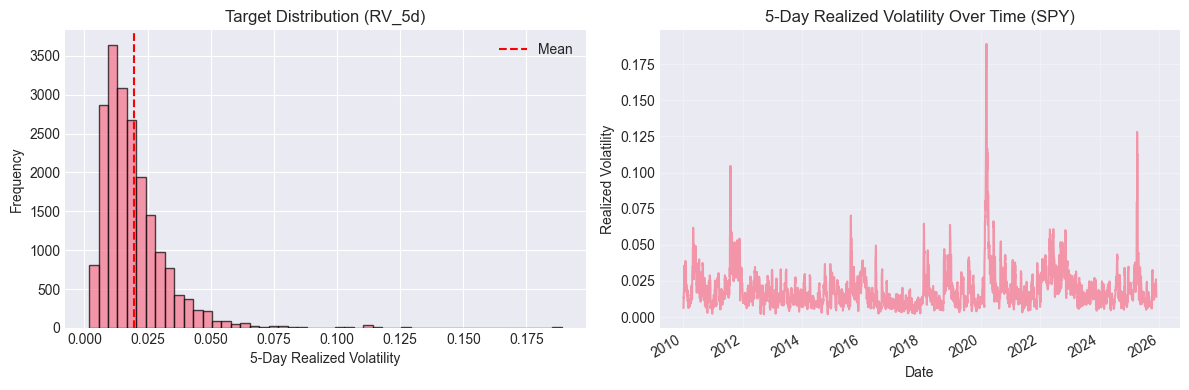

In [8]:
# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(market_data['rv_5d'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('5-Day Realized Volatility')
plt.ylabel('Frequency')
plt.title('Target Distribution (RV_5d)')
plt.axvline(market_data['rv_5d'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

plt.subplot(1, 2, 2)
spy_data.set_index('date')['rv_5d'].plot(figsize=(12, 4), alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.title('5-Day Realized Volatility Over Time (SPY)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
target_data.head()

,date,rv_5d
0,2010-01-04,0.006182
1,2010-01-05,0.010910
2,2010-01-06,0.013758
3,2010-01-07,0.013373
4,2010-01-08,0.017181


### 2.3 Load Features

In [10]:
print("loading features...")

#only include dates from 2010-01 onwards
feature_date_dirs = sorted([
    d for d in FEATURES_DIR.iterdir() 
    if d.is_dir() and d.name.startswith('date=') and d.name >= 'date=2010-01'
])

print(f"Found {len(feature_date_dirs)} feature partitions (from 2010-01 onwards)")

feature_dfs = []
for date_dir in feature_date_dirs:
    parquet_files = list(date_dir.glob('*.parquet'))
    if parquet_files:
        df = pd.read_parquet(parquet_files[0])
        feature_dfs.append(df)

features_data = pd.concat(feature_dfs, ignore_index=True)

print(f"\nLoaded {len(features_data):,} rows of features")
print(f"Features: {list(features_data.columns)}")
print(f"Date range: {features_data['date'].min()} to {features_data['date'].max()}")

loading features...
Found 4004 feature partitions (from 2010-01 onwards)

Loaded 4,004 rows of features
Features: ['date', 'spy_ret_1d', 'spy_ret_5d', 'spy_ret_10d', 'spy_ret_20d', 'spy_ret_60d', 'spy_vol_5d', 'spy_vol_10d', 'spy_vol_20d', 'spy_vol_60d', 'drawdown_60d', 'vix', 'vix3m', 'vix_term', 'rsi_spy_14', 'corr_spy_tlt_20d', 'corr_spy_hyg_20d', 'corr_spy_tlt_60d', 'corr_spy_hyg_60d', 'hyg_tlt_spread', 'rv_vix_spread_20d']
Date range: 2010-01-04 00:00:00 to 2025-12-02 00:00:00

Loaded 4,004 rows of features
Features: ['date', 'spy_ret_1d', 'spy_ret_5d', 'spy_ret_10d', 'spy_ret_20d', 'spy_ret_60d', 'spy_vol_5d', 'spy_vol_10d', 'spy_vol_20d', 'spy_vol_60d', 'drawdown_60d', 'vix', 'vix3m', 'vix_term', 'rsi_spy_14', 'corr_spy_tlt_20d', 'corr_spy_hyg_20d', 'corr_spy_tlt_60d', 'corr_spy_hyg_60d', 'hyg_tlt_spread', 'rv_vix_spread_20d']
Date range: 2010-01-04 00:00:00 to 2025-12-02 00:00:00


In [11]:
features_data.head(61)

,date,spy_ret_1d,spy_ret_5d,spy_ret_10d,spy_ret_20d,spy_ret_60d,spy_vol_5d,spy_vol_10d,spy_vol_20d,spy_vol_60d,drawdown_60d,vix,vix3m,vix_term,rsi_spy_14,corr_spy_tlt_20d,corr_spy_hyg_20d,corr_spy_tlt_60d,corr_spy_hyg_60d,hyg_tlt_spread,rv_vix_spread_20d
0,2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.040001,22.770000,1.136228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,0.002644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.350000,22.389999,1.157106,NaN,NaN,NaN,NaN,NaN,-0.001705,NaN
2,2010-01-06,0.000704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.160000,21.799999,1.137787,NaN,NaN,NaN,NaN,NaN,0.016059,NaN
3,2010-01-07,0.004212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.059999,21.600000,1.133263,NaN,NaN,NaN,NaN,NaN,0.002349,NaN
4,2010-01-08,0.003322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.129999,21.000000,1.158301,NaN,NaN,NaN,NaN,NaN,0.002009,NaN
5,2010-01-11,0.001396,0.012277,NaN,NaN,NaN,0.006182,NaN,NaN,NaN,NaN,17.549999,21.270000,1.211966,NaN,NaN,NaN,NaN,NaN,0.004610,NaN
6,2010-01-12,-0.009370,0.000264,NaN,NaN,NaN,0.010910,NaN,NaN,NaN,NaN,18.250000,21.790001,1.193973,NaN,NaN,NaN,NaN,NaN,-0.022120,NaN
7,2010-01-13,0.008411,0.007971,NaN,NaN,NaN,0.013757,NaN,NaN,NaN,NaN,17.850000,21.290001,1.192717,NaN,NaN,NaN,NaN,NaN,0.013936,NaN
8,2010-01-14,0.002701,0.006460,NaN,NaN,NaN,0.013372,NaN,NaN,NaN,NaN,17.629999,20.709999,1.174702,NaN,NaN,NaN,NaN,NaN,-0.012787,NaN
9,2010-01-15,-0.011287,-0.008150,NaN,NaN,NaN,0.017181,NaN,NaN,NaN,NaN,17.910000,21.480000,1.199330,NaN,NaN,NaN,NaN,NaN,-0.010201,NaN


### 2.4 Merge Features with Target

In [12]:
print("merging features with target...")

print(f"Target data: {len(target_data):,} unique dates")
print(f"Features data: {len(features_data):,} rows")

full_data = features_data.merge(target_data, on='date', how='inner')

full_data.head()

merging features with target...
Target data: 4,004 unique dates
Features data: 4,004 rows


,date,spy_ret_1d,spy_ret_5d,spy_ret_10d,spy_ret_20d,spy_ret_60d,spy_vol_5d,spy_vol_10d,spy_vol_20d,spy_vol_60d,drawdown_60d,vix,vix3m,vix_term,rsi_spy_14,corr_spy_tlt_20d,corr_spy_hyg_20d,corr_spy_tlt_60d,corr_spy_hyg_60d,hyg_tlt_spread,rv_vix_spread_20d,rv_5d
0,2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.040001,22.770000,1.136228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006182
1,2010-01-05,0.002644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.350000,22.389999,1.157106,NaN,NaN,NaN,NaN,NaN,-0.001705,NaN,0.010910
2,2010-01-06,0.000704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.160000,21.799999,1.137787,NaN,NaN,NaN,NaN,NaN,0.016059,NaN,0.013758
3,2010-01-07,0.004212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.059999,21.600000,1.133263,NaN,NaN,NaN,NaN,NaN,0.002349,NaN,0.013373
4,2010-01-08,0.003322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.129999,21.000000,1.158301,NaN,NaN,NaN,NaN,NaN,0.002009,NaN,0.017181


In [13]:
print(f"\nMerged dataset created")
print(f"Total rows: {len(full_data):,}")
print(f"Total columns: {len(full_data.columns)}")
print(f"Missing values:")
missing_summary = full_data.isna().sum()[full_data.isna().sum() > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("None")


Merged dataset created
Total rows: 4,004
Total columns: 22
Missing values:
spy_ret_1d            1
spy_ret_5d            5
spy_ret_10d          10
spy_ret_20d          20
spy_ret_60d          60
spy_vol_5d            5
spy_vol_10d          10
spy_vol_20d          20
spy_vol_60d          60
drawdown_60d         59
rsi_spy_14           13
corr_spy_tlt_20d     20
corr_spy_hyg_20d     20
corr_spy_tlt_60d     60
corr_spy_hyg_60d     60
hyg_tlt_spread        1
rv_vix_spread_20d    20
rv_5d                 5
dtype: int64


### 2.5 Clean Data & Train/Val Split

In [14]:
#drop NaN
print(f"before cleaning: {len(full_data):,} rows")
full_data_clean = full_data.dropna().reset_index(drop=True)
print(f"after cleaning: {len(full_data_clean):,} rows")
print(f"dropped {len(full_data) - len(full_data_clean):,} rows with missing values")

#sort by date
full_data_clean = full_data_clean.sort_values('date').reset_index(drop=True)


before cleaning: 4,004 rows
after cleaning: 3,939 rows
dropped 65 rows with missing values


In [15]:
full_data_clean.head()

,date,spy_ret_1d,spy_ret_5d,spy_ret_10d,spy_ret_20d,spy_ret_60d,spy_vol_5d,spy_vol_10d,spy_vol_20d,spy_vol_60d,drawdown_60d,vix,vix3m,vix_term,rsi_spy_14,corr_spy_tlt_20d,corr_spy_hyg_20d,corr_spy_tlt_60d,corr_spy_hyg_60d,hyg_tlt_spread,rv_vix_spread_20d,rv_5d
0,2010-03-31,-0.003413,0.001369,0.003255,0.045110,0.035980,0.007427,0.013506,0.023040,0.068534,0.003492,17.590000,19.920000,1.132462,67.495229,-0.033156,0.662250,-0.405903,0.748288,-0.010002,-17.566960,0.012753
1,2010-04-01,0.006814,0.009810,0.010582,0.048901,0.040150,0.009947,0.015119,0.023835,0.068821,0.000000,17.469999,19.900000,1.139096,71.402127,-0.050705,0.572180,-0.413888,0.739692,0.000028,-17.446164,0.012611
2,2010-04-05,0.008117,0.018527,0.023773,0.042825,0.047563,0.012824,0.016392,0.020799,0.069294,0.000000,17.020000,19.350000,1.136898,74.947145,0.037408,0.370867,-0.436399,0.735425,0.016321,-16.999202,0.009782
3,2010-04-06,0.002355,0.014554,0.020796,0.045005,0.045706,0.011400,0.015678,0.020931,0.069206,0.000000,16.230000,18.840000,1.160813,72.626120,0.023968,0.323680,-0.437735,0.728944,0.004897,-16.209069,0.009524
4,2010-04-07,-0.005729,0.008144,0.008059,0.037615,0.036654,0.012741,0.015150,0.021637,0.069363,0.005713,16.620001,19.190001,1.154633,62.684144,-0.138823,0.284009,-0.445642,0.721776,-0.011227,-16.598364,0.013610


In [ ]:
#train/val split (90/10 walk forward)
split_index = int(len(full_data_clean) * 0.9)

train_df = full_data_clean.iloc[:split_index].copy()
val_df = full_data_clean.iloc[split_index:].copy()

print(f"Train: {len(train_df):,} rows ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"Val: {len(val_df):,} rows ({val_df['date'].min()} to {val_df['date'].max()})")
print(f"Split ratio: {len(train_df)/len(full_data_clean):.1%} / {len(val_df)/len(full_data_clean):.1%}")

feature_cols = [col for col in full_data_clean.columns if col not in ['date', 'rv_5d']]
print(f"\nFeature columns: {len(feature_cols)}:")
print(f"{feature_cols}")

Train: 3,151 rows (2010-03-31 00:00:00 to 2022-10-04 00:00:00)
Val: 788 rows (2022-10-05 00:00:00 to 2025-11-24 00:00:00)
Split ratio: 80.0% / 20.0%

Feature columns: 20:
['spy_ret_1d', 'spy_ret_5d', 'spy_ret_10d', 'spy_ret_20d', 'spy_ret_60d', 'spy_vol_5d', 'spy_vol_10d', 'spy_vol_20d', 'spy_vol_60d', 'drawdown_60d', 'vix', 'vix3m', 'vix_term', 'rsi_spy_14', 'corr_spy_tlt_20d', 'corr_spy_hyg_20d', 'corr_spy_tlt_60d', 'corr_spy_hyg_60d', 'hyg_tlt_spread', 'rv_vix_spread_20d']


## 3. Linear Regression (Ridge & Lasso)

Linear regression with regularization serves as our baseline. Despite its simplicity, it's interpretable, fast, and often surprisingly competitive on well-engineered features.

### 3.1 Baseline Model

In [17]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [18]:
#prepare data
X_train = train_df[feature_cols].values
y_train = train_df['rv_5d'].values
X_val = val_df[feature_cols].values
y_val = val_df['rv_5d'].values

#standardize features (required for linear models with regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Features: {len(feature_cols)}")
print(f"\nFeatures standardized (mean≈0, std≈1)")

Training samples: 3151
Validation samples: 788
Features: 20

Features standardized (mean≈0, std≈1)


In [19]:
#train baseline Ridge (alpha=1.0)
ridge_baseline = Ridge(alpha=1.0, random_state=42)
ridge_baseline.fit(X_train_scaled, y_train)

#predict
ridge_baseline_train_pred = ridge_baseline.predict(X_train_scaled)
ridge_baseline_val_pred = ridge_baseline.predict(X_val_scaled)

#eval
ridge_baseline_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_baseline_train_pred))
ridge_baseline_val_rmse = np.sqrt(mean_squared_error(y_val, ridge_baseline_val_pred))
ridge_baseline_train_mae = mean_absolute_error(y_train, ridge_baseline_train_pred)
ridge_baseline_val_mae = mean_absolute_error(y_val, ridge_baseline_val_pred)
ridge_baseline_train_r2 = r2_score(y_train, ridge_baseline_train_pred)
ridge_baseline_val_r2 = r2_score(y_val, ridge_baseline_val_pred)

print(f"Ridge Baseline Results:")
print(f"Train RMSE: {ridge_baseline_train_rmse:.6f}")
print(f"Val RMSE:   {ridge_baseline_val_rmse:.6f}")
print(f"Train R²:   {ridge_baseline_train_r2:.4f}")
print(f"Val R²:     {ridge_baseline_val_r2:.4f}")
print(f"Train-Val Gap: {ridge_baseline_train_rmse - ridge_baseline_val_rmse:.6f}")

Ridge Baseline Results:
Train RMSE: 0.009483
Val RMSE:   0.009356
Train R²:   0.6068
Val R²:     0.4216
Train-Val Gap: 0.000126


In [20]:
#train baseline Lasso (alpha=1.0)
lasso_baseline = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso_baseline.fit(X_train_scaled, y_train)

#predict
lasso_baseline_train_pred = lasso_baseline.predict(X_train_scaled)
lasso_baseline_val_pred = lasso_baseline.predict(X_val_scaled)

#eval
lasso_baseline_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_baseline_train_pred))
lasso_baseline_val_rmse = np.sqrt(mean_squared_error(y_val, lasso_baseline_val_pred))
lasso_baseline_train_mae = mean_absolute_error(y_train, lasso_baseline_train_pred)
lasso_baseline_val_mae = mean_absolute_error(y_val, lasso_baseline_val_pred)
lasso_baseline_train_r2 = r2_score(y_train, lasso_baseline_train_pred)
lasso_baseline_val_r2 = r2_score(y_val, lasso_baseline_val_pred)

n_zeroed = np.sum(lasso_baseline.coef_ == 0)

print(f"Lasso Baseline Results:")
print(f"Train RMSE: {lasso_baseline_train_rmse:.6f}")
print(f"Val RMSE:   {lasso_baseline_val_rmse:.6f}")
print(f"Train R²:   {lasso_baseline_train_r2:.4f}")
print(f"Val R²:     {lasso_baseline_val_r2:.4f}")
print(f"Train-Val Gap: {lasso_baseline_train_rmse - lasso_baseline_val_rmse:.6f}")
print(f"\nFeature selection: {n_zeroed}/{len(feature_cols)} features zeroed out")

Lasso Baseline Results:
Train RMSE: 0.015123
Val RMSE:   0.012308
Train R²:   0.0000
Val R²:     -0.0009
Train-Val Gap: 0.002815

Feature selection: 20/20 features zeroed out


In [21]:
#baseline comparison
ridge_baseline_results = pd.DataFrame({
    'Metric': ['Train RMSE', 'Val RMSE', 'Train MAE', 'Val MAE', 'Train R²', 'Val R²'],
    'Ridge': [ridge_baseline_train_rmse, ridge_baseline_val_rmse, 
              ridge_baseline_train_mae, ridge_baseline_val_mae,
              ridge_baseline_train_r2, ridge_baseline_val_r2],
    'Lasso': [lasso_baseline_train_rmse, lasso_baseline_val_rmse,
              lasso_baseline_train_mae, lasso_baseline_val_mae,
              lasso_baseline_train_r2, lasso_baseline_val_r2]
})

print("="*70)
print("BASELINE MODELS COMPARISON (alpha=1.0)")
print("="*70)
print(ridge_baseline_results.to_string(index=False))

BASELINE MODELS COMPARISON (alpha=1.0)
    Metric    Ridge     Lasso
Train RMSE 0.009483  0.015123
  Val RMSE 0.009356  0.012308
 Train MAE 0.006040  0.009975
   Val MAE 0.005697  0.007624
  Train R² 0.606814  0.000000
    Val R² 0.421626 -0.000870


### 3.2 Hyperparameter Tuning

In [22]:
#parameter save path
PARAMS_DIR = Path('../notebooks')
PARAMS_DIR.mkdir(exist_ok=True)
LINEAR_PARAMS_FILE = PARAMS_DIR / 'linear_params_2010.json'

#time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

#alpha search space (log scale)
alpha_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

total_combinations = len(alpha_grid['alpha']) * 2  # Ridge + Lasso

print(f"Linear Regression Grid Search Configuration:")
print(f"Total combinations: {total_combinations} (Ridge: {len(alpha_grid['alpha'])}, Lasso: {len(alpha_grid['alpha'])})")
print(f"Features: All {len(feature_cols)} features (scaled)")
print(f"CV folds: {tscv.n_splits}")
print(f"Parameters will be saved to: {LINEAR_PARAMS_FILE}")

Linear Regression Grid Search Configuration:
Total combinations: 14 (Ridge: 7, Lasso: 7)
Features: All 20 features (scaled)
CV folds: 5
Parameters will be saved to: ../notebooks/linear_params_2010.json


In [23]:
#check if saved parameters exist
if LINEAR_PARAMS_FILE.exists():
    print(f"Found saved parameters at {LINEAR_PARAMS_FILE}")
    print("Loading saved parameters...\n")
    
    with open(LINEAR_PARAMS_FILE, 'r') as f:
        saved_data = json.load(f)
    
    ridge_tuned_params = saved_data['ridge_params']
    lasso_tuned_params = saved_data['lasso_params']
    ridge_tuned_cv_score = saved_data['ridge_cv_score']
    lasso_tuned_cv_score = saved_data['lasso_cv_score']
    
    print(f"Ridge best alpha: {ridge_tuned_params['alpha']}")
    print(f"Ridge CV RMSE: {ridge_tuned_cv_score:.6f}")
    print(f"\nLasso best alpha: {lasso_tuned_params['alpha']}")
    print(f"Lasso CV RMSE: {lasso_tuned_cv_score:.6f}")
    
else:
    print("No saved parameters found. Running grid search...")
    print("This will take a few minutes...\n")
    
    #Ridge grid search
    print("[1/2] Tuning Ridge...")
    ridge_grid_search = GridSearchCV(
        Ridge(random_state=42),
        param_grid=alpha_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    ridge_grid_search.fit(X_train_scaled, y_train)
    ridge_tuned_params = ridge_grid_search.best_params_
    ridge_tuned_cv_score = np.sqrt(-ridge_grid_search.best_score_)
    
    print(f"✓ Ridge best alpha: {ridge_tuned_params['alpha']}, CV RMSE: {ridge_tuned_cv_score:.6f}")
    
    #Lasso grid search
    print("\n[2/2] Tuning Lasso...")
    lasso_grid_search = GridSearchCV(
        Lasso(random_state=42, max_iter=10000),
        param_grid=alpha_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    lasso_grid_search.fit(X_train_scaled, y_train)
    lasso_tuned_params = lasso_grid_search.best_params_
    lasso_tuned_cv_score = np.sqrt(-lasso_grid_search.best_score_)
    
    print(f"✓ Lasso best alpha: {lasso_tuned_params['alpha']}, CV RMSE: {lasso_tuned_cv_score:.6f}")
    
    #save parameters
    save_data = {
        'ridge_params': ridge_tuned_params,
        'lasso_params': lasso_tuned_params,
        'ridge_cv_score': ridge_tuned_cv_score,
        'lasso_cv_score': lasso_tuned_cv_score,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    with open(LINEAR_PARAMS_FILE, 'w') as f:
        json.dump(save_data, f, indent=2)
    
    print(f"\n✓ Parameters saved to {LINEAR_PARAMS_FILE}")

No saved parameters found. Running grid search...
This will take a few minutes...

[1/2] Tuning Ridge...
✓ Ridge best alpha: 100.0, CV RMSE: 0.010131

[2/2] Tuning Lasso...
✓ Ridge best alpha: 100.0, CV RMSE: 0.010131

[2/2] Tuning Lasso...
✓ Lasso best alpha: 0.001, CV RMSE: 0.010515

✓ Parameters saved to ../notebooks/linear_params_2010.json
✓ Lasso best alpha: 0.001, CV RMSE: 0.010515

✓ Parameters saved to ../notebooks/linear_params_2010.json


### 3.3 Evaluate Tuned Models

In [24]:
#train Ridge with best alpha
ridge_tuned = Ridge(alpha=ridge_tuned_params['alpha'], random_state=42)
ridge_tuned.fit(X_train_scaled, y_train)

#predict
ridge_tuned_train_pred = ridge_tuned.predict(X_train_scaled)
ridge_tuned_val_pred = ridge_tuned.predict(X_val_scaled)

#eval
ridge_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_tuned_train_pred))
ridge_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, ridge_tuned_val_pred))
ridge_tuned_train_mae = mean_absolute_error(y_train, ridge_tuned_train_pred)
ridge_tuned_val_mae = mean_absolute_error(y_val, ridge_tuned_val_pred)
ridge_tuned_train_r2 = r2_score(y_train, ridge_tuned_train_pred)
ridge_tuned_val_r2 = r2_score(y_val, ridge_tuned_val_pred)

print(f"Ridge Tuned (alpha={ridge_tuned_params['alpha']}) Results:")
print(f"Train RMSE: {ridge_tuned_train_rmse:.6f}")
print(f"Val RMSE:   {ridge_tuned_val_rmse:.6f}")
print(f"Train R²:   {ridge_tuned_train_r2:.4f}")
print(f"Val R²:     {ridge_tuned_val_r2:.4f}")

Ridge Tuned (alpha=100.0) Results:
Train RMSE: 0.009562
Val RMSE:   0.009422
Train R²:   0.6002
Val R²:     0.4135


In [25]:
#train Lasso with best alpha
lasso_tuned = Lasso(alpha=lasso_tuned_params['alpha'], random_state=42, max_iter=10000)
lasso_tuned.fit(X_train_scaled, y_train)

#predict
lasso_tuned_train_pred = lasso_tuned.predict(X_train_scaled)
lasso_tuned_val_pred = lasso_tuned.predict(X_val_scaled)

#eval
lasso_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_tuned_train_pred))
lasso_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, lasso_tuned_val_pred))
lasso_tuned_train_mae = mean_absolute_error(y_train, lasso_tuned_train_pred)
lasso_tuned_val_mae = mean_absolute_error(y_val, lasso_tuned_val_pred)
lasso_tuned_train_r2 = r2_score(y_train, lasso_tuned_train_pred)
lasso_tuned_val_r2 = r2_score(y_val, lasso_tuned_val_pred)

n_zeroed_tuned = np.sum(lasso_tuned.coef_ == 0)

print(f"Lasso Tuned (alpha={lasso_tuned_params['alpha']}) Results:")
print(f"Train RMSE: {lasso_tuned_train_rmse:.6f}")
print(f"Val RMSE:   {lasso_tuned_val_rmse:.6f}")
print(f"Train R²:   {lasso_tuned_train_r2:.4f}")
print(f"Val R²:     {lasso_tuned_val_r2:.4f}")
print(f"\nFeature selection: {n_zeroed_tuned}/{len(feature_cols)} features zeroed out")

Lasso Tuned (alpha=0.001) Results:
Train RMSE: 0.009731
Val RMSE:   0.009374
Train R²:   0.5860
Val R²:     0.4194

Feature selection: 11/20 features zeroed out


In [26]:
#tuned models comparison
ridge_tuned_results = pd.DataFrame({
    'Metric': ['Train RMSE', 'Val RMSE', 'Train MAE', 'Val MAE', 'Train R²', 'Val R²'],
    'Ridge': [ridge_tuned_train_rmse, ridge_tuned_val_rmse,
              ridge_tuned_train_mae, ridge_tuned_val_mae,
              ridge_tuned_train_r2, ridge_tuned_val_r2],
    'Lasso': [lasso_tuned_train_rmse, lasso_tuned_val_rmse,
              lasso_tuned_train_mae, lasso_tuned_val_mae,
              lasso_tuned_train_r2, lasso_tuned_val_r2]
})

print("="*70)
print("TUNED MODELS PERFORMANCE")
print("="*70)
print(ridge_tuned_results.to_string(index=False))

#improvement over baseline
ridge_improvement = (ridge_baseline_val_rmse - ridge_tuned_val_rmse) / ridge_baseline_val_rmse * 100
lasso_improvement = (lasso_baseline_val_rmse - lasso_tuned_val_rmse) / lasso_baseline_val_rmse * 100

print(f"\n{'='*70}")
print("IMPROVEMENT OVER BASELINE")
print(f"{'='*70}")
print(f"Ridge: {ridge_baseline_val_rmse:.6f} → {ridge_tuned_val_rmse:.6f} ({ridge_improvement:+.2f}%)")
print(f"Lasso: {lasso_baseline_val_rmse:.6f} → {lasso_tuned_val_rmse:.6f} ({lasso_improvement:+.2f}%)")

TUNED MODELS PERFORMANCE
    Metric    Ridge    Lasso
Train RMSE 0.009562 0.009731
  Val RMSE 0.009422 0.009374
 Train MAE 0.006035 0.006113
   Val MAE 0.005756 0.005635
  Train R² 0.600207 0.585969
    Val R² 0.413542 0.419435

IMPROVEMENT OVER BASELINE
Ridge: 0.009356 → 0.009422 (-0.70%)
Lasso: 0.012308 → 0.009374 (+23.84%)


### 3.4 Model Selection (Ridge vs Lasso)

Compare Ridge and Lasso using the same selection logic as RF and XGBoost: 0.5% RMSE threshold with R² as tiebreaker.

In [27]:
#compare Ridge vs Lasso
print("="*70)
print("MODEL SELECTION: Ridge vs Lasso")
print("="*70)

#comparison table
comparison_df = pd.DataFrame({
    'Model': ['Ridge (Tuned)', 'Lasso (Tuned)'],
    'Val RMSE': [ridge_tuned_val_rmse, lasso_tuned_val_rmse],
    'Val R²': [ridge_tuned_val_r2, lasso_tuned_val_r2],
    'Val MAE': [ridge_tuned_val_mae, lasso_tuned_val_mae],
    'Train RMSE': [ridge_tuned_train_rmse, lasso_tuned_train_rmse],
    'Alpha': [ridge_tuned_params['alpha'], lasso_tuned_params['alpha']]
})

print(comparison_df.to_string(index=False))

#selection logic: 0.5% threshold + R² tiebreaker
rmse_diff = abs(ridge_tuned_val_rmse - lasso_tuned_val_rmse)
rmse_pct = rmse_diff / min(ridge_tuned_val_rmse, lasso_tuned_val_rmse) * 100

print(f"\nRMSE difference: {rmse_diff:.6f} ({rmse_pct:.2f}%)")

if rmse_pct < 0.5:
    print("→ RMSE difference < 0.5% threshold, using R² as tiebreaker")
    if ridge_tuned_val_r2 > lasso_tuned_val_r2:
        selected_approach = 'Ridge'
        linear_final = ridge_tuned
        linear_final_train_pred = ridge_tuned_train_pred
        linear_final_val_pred = ridge_tuned_val_pred
        linear_final_params = ridge_tuned_params
    else:
        selected_approach = 'Lasso'
        linear_final = lasso_tuned
        linear_final_train_pred = lasso_tuned_train_pred
        linear_final_val_pred = lasso_tuned_val_pred
        linear_final_params = lasso_tuned_params
else:
    if ridge_tuned_val_rmse < lasso_tuned_val_rmse:
        selected_approach = 'Ridge'
        linear_final = ridge_tuned
        linear_final_train_pred = ridge_tuned_train_pred
        linear_final_val_pred = ridge_tuned_val_pred
        linear_final_params = ridge_tuned_params
    else:
        selected_approach = 'Lasso'
        linear_final = lasso_tuned
        linear_final_train_pred = lasso_tuned_train_pred
        linear_final_val_pred = lasso_tuned_val_pred
        linear_final_params = lasso_tuned_params

print(f"\n{'='*70}")
print(f"✓ SELECTED: {selected_approach}")
print(f"{'='*70}")

MODEL SELECTION: Ridge vs Lasso
        Model  Val RMSE   Val R²  Val MAE  Train RMSE      Alpha
Ridge (Tuned)  0.009422 0.413542 0.005756    0.009562 100.000000
Lasso (Tuned)  0.009374 0.419435 0.005635    0.009731   0.001000

RMSE difference: 0.000047 (0.51%)

✓ SELECTED: Lasso


In [28]:
#compute final metrics
linear_final_train_rmse = np.sqrt(mean_squared_error(y_train, linear_final_train_pred))
linear_final_val_rmse = np.sqrt(mean_squared_error(y_val, linear_final_val_pred))
linear_final_train_mae = mean_absolute_error(y_train, linear_final_train_pred)
linear_final_val_mae = mean_absolute_error(y_val, linear_final_val_pred)
linear_final_train_r2 = r2_score(y_train, linear_final_train_pred)
linear_final_val_r2 = r2_score(y_val, linear_final_val_pred)

train_val_gap = linear_final_train_rmse - linear_final_val_rmse
gap_percentage = abs(train_val_gap) / linear_final_train_rmse * 100

baseline_val_rmse = min(ridge_baseline_val_rmse, lasso_baseline_val_rmse)
improvement = (baseline_val_rmse - linear_final_val_rmse) / baseline_val_rmse * 100

print(f"\n{selected_approach} Final Model Performance:")
print(f"Train RMSE: {linear_final_train_rmse:.6f}")
print(f"Val RMSE:   {linear_final_val_rmse:.6f}")
print(f"Train MAE:  {linear_final_train_mae:.6f}")
print(f"Val MAE:    {linear_final_val_mae:.6f}")
print(f"Train R²:   {linear_final_train_r2:.4f}")
print(f"Val R²:     {linear_final_val_r2:.4f}")
print(f"\nGeneralization:")
print(f"Train-Val RMSE gap: {train_val_gap:.6f} ({gap_percentage:.2f}%)")
print(f"Improvement over baseline: {improvement:.2f}%")


Lasso Final Model Performance:
Train RMSE: 0.009731
Val RMSE:   0.009374
Train MAE:  0.006113
Val MAE:    0.005635
Train R²:   0.5860
Val R²:     0.4194

Generalization:
Train-Val RMSE gap: 0.000357 (3.67%)
Improvement over baseline: -0.19%


In [29]:
#calculate feature importance (coefficients)
linear_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': linear_final.coef_,
    'abs_coefficient': np.abs(linear_final.coef_)
}).sort_values('abs_coefficient', ascending=False)

#top 10 features
top_10_features = linear_importance.head(10)[['feature', 'coefficient']].to_dict('records')

#all features
all_features = linear_importance[['feature', 'coefficient']].to_dict('records')

print("\nFeature Importance (Top 10):")
for feat in top_10_features:
    print(f"  {feat['feature']}: {feat['coefficient']:.6f}")


Feature Importance (Top 10):
  vix: 0.005652
  vix_term: -0.001529
  spy_vol_5d: 0.001464
  spy_ret_10d: -0.001450
  spy_vol_10d: 0.001032
  drawdown_60d: 0.000629
  spy_ret_5d: -0.000226
  spy_ret_20d: -0.000193
  rv_vix_spread_20d: -0.000006
  spy_vol_60d: 0.000000


In [30]:
#save comprehensive metrics to JSON
LINEAR_METRICS_FILE = PARAMS_DIR / 'linear_final_metrics_2010.json'

linear_metrics_to_save = {
    'model_name': f'Linear Regression ({selected_approach})',
    'selected_approach': selected_approach,
    'timestamp': pd.Timestamp.now().isoformat(),
    'data_info': {
        'n_train': len(y_train),
        'n_val': len(y_val),
        'n_features': len(feature_cols)
    },
    'hyperparameters': linear_final_params,
    'metrics': {
        'train': {
            'rmse': float(linear_final_train_rmse),
            'mae': float(linear_final_train_mae),
            'r2': float(linear_final_train_r2)
        },
        'validation': {
            'rmse': float(linear_final_val_rmse),
            'mae': float(linear_final_val_mae),
            'r2': float(linear_final_val_r2)
        },
        'generalization': {
            'train_val_gap_rmse': float(train_val_gap),
            'gap_percentage': float(gap_percentage)
        }
    },
    'feature_importance': {
        'top_10': top_10_features,
        'all_features': all_features
    },
    'comparison': {
        'baseline_val_rmse': float(baseline_val_rmse),
        'improvement_pct': float(improvement)
    }
}

with open(LINEAR_METRICS_FILE, 'w') as f:
    json.dump(linear_metrics_to_save, f, indent=2)

print(f"\n✓ Metrics saved to {LINEAR_METRICS_FILE.name}")


✓ Metrics saved to linear_final_metrics_2010.json


### 3.5 Feature Importance (Coefficients)

In [31]:
#feature importance already calculated in metrics save cell above
print("="*70)
print(f"FEATURE IMPORTANCE ({selected_approach} coefficients)")
print("="*70)
print(linear_importance[['feature', 'coefficient']].head(10).to_string(index=False))

if selected_approach == 'Lasso':
    n_nonzero = np.sum(linear_final.coef_ != 0)
    print(f"\nLasso selected {n_nonzero}/{len(feature_cols)} features")

FEATURE IMPORTANCE (Lasso coefficients)
          feature  coefficient
              vix     0.005652
         vix_term    -0.001529
       spy_vol_5d     0.001464
      spy_ret_10d    -0.001450
      spy_vol_10d     0.001032
     drawdown_60d     0.000629
       spy_ret_5d    -0.000226
      spy_ret_20d    -0.000193
rv_vix_spread_20d    -0.000006
      spy_vol_60d     0.000000

Lasso selected 9/20 features


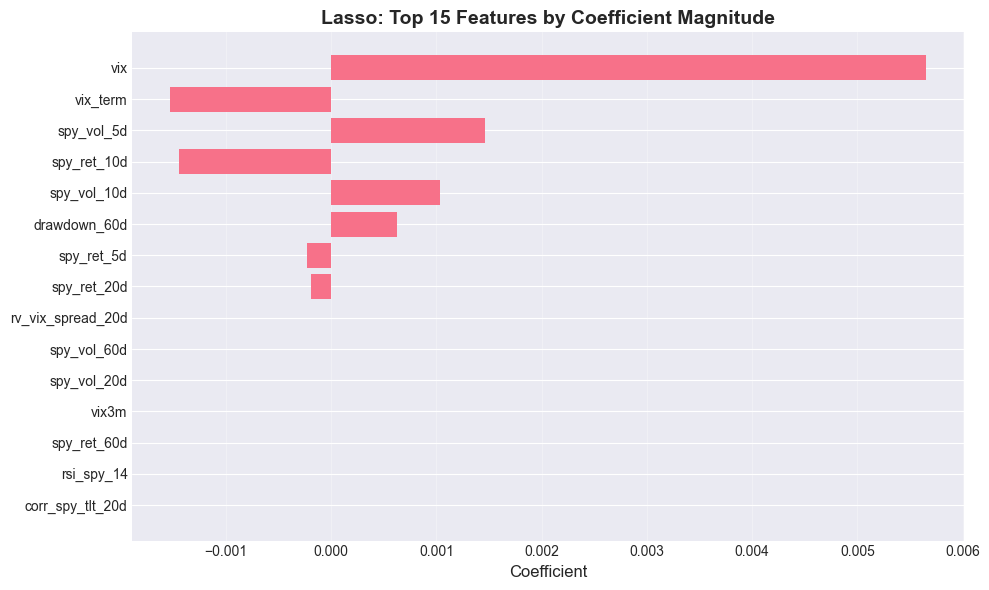

In [32]:
#visualize top 15 features
top_15 = linear_importance.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_15['feature'], top_15['coefficient'])
plt.xlabel('Coefficient', fontsize=12)
plt.title(f'{selected_approach}: Top 15 Features by Coefficient Magnitude', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 3.6 Overfitting Diagnostics

In [33]:
#train-val gap analysis
print("="*70)
print("GENERALIZATION ANALYSIS")
print("="*70)
print(f"Train RMSE: {linear_final_train_rmse:.6f}")
print(f"Val RMSE: {linear_final_val_rmse:.6f}")
print(f"Gap: {train_val_gap:.6f} ({gap_percentage:.2f}%)")
print(f"\nTrain R²: {linear_final_train_r2:.4f}")
print(f"Val R²:{linear_final_val_r2:.4f}")

if gap_percentage < 5:
    print("\nGap < 5%: Model generalizes well")
elif gap_percentage < 10:
    print("\nGap 5-10%: Slight overfitting, monitor")
else:
    print("\nGap > 10%: Significant overfitting detected")

GENERALIZATION ANALYSIS
Train RMSE: 0.009731
Val RMSE: 0.009374
Gap: 0.000357 (3.67%)

Train R²: 0.5860
Val R²:0.4194

Gap < 5%: Model generalizes well


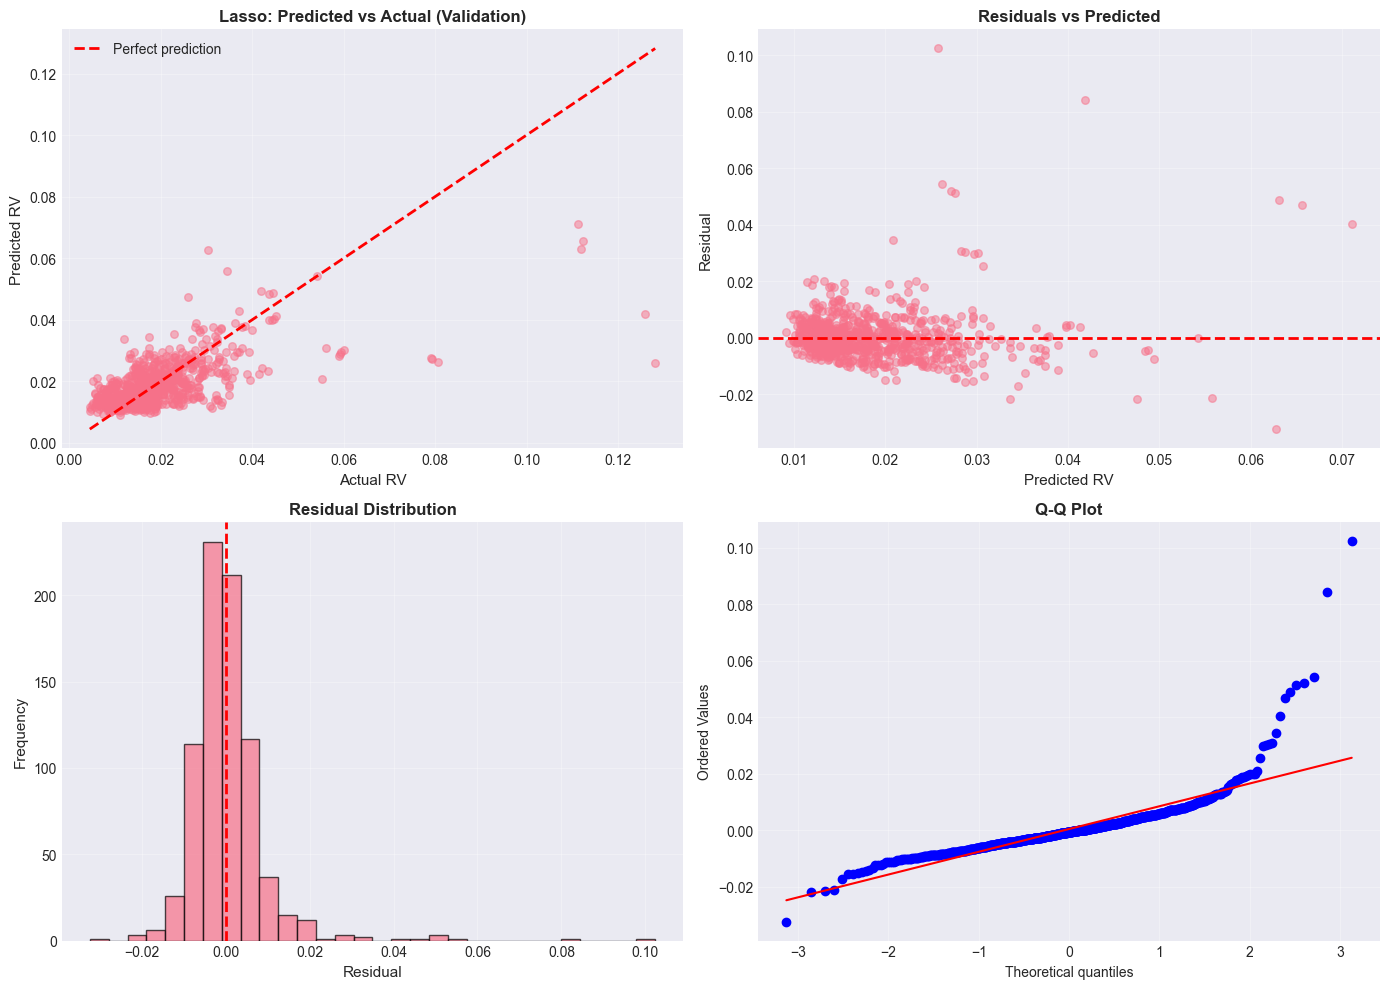

In [34]:
#residual analysis
linear_residuals = y_val - linear_final_val_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#1. predictions vs actual
axes[0, 0].scatter(y_val, linear_final_val_pred, alpha=0.5, s=30)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual RV', fontsize=11)
axes[0, 0].set_ylabel('Predicted RV', fontsize=11)
axes[0, 0].set_title(f'{selected_approach}: Predicted vs Actual (Validation)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

#2. residuals vs predicted
axes[0, 1].scatter(linear_final_val_pred, linear_residuals, alpha=0.5, s=30)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted RV', fontsize=11)
axes[0, 1].set_ylabel('Residual', fontsize=11)
axes[0, 1].set_title('Residuals vs Predicted', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

#3. residual distribution
axes[1, 0].hist(linear_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residual', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

#4. QQ plot
from scipy import stats
stats.probplot(linear_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
#residual statistics
print("="*70)
print("RESIDUAL STATISTICS")
print("="*70)
print(f"Mean:   {linear_residuals.mean():.6f} (should be ≈0)")
print(f"Std:    {linear_residuals.std():.6f}")
print(f"Min:    {linear_residuals.min():.6f}")
print(f"Max:    {linear_residuals.max():.6f}")
print(f"Median: {np.median(linear_residuals):.6f}")

#check for patterns
from scipy.stats import shapiro
stat, p_value = shapiro(linear_residuals)
print(f"\nShapiro-Wilk test for normality:")
print(f"Statistic: {stat:.4f}")
print(f"P-value:   {p_value:.4f}")
if p_value > 0.05:
    print("Residuals appear normally distributed (p > 0.05)")
else:
    print("Residuals may not be normally distributed (p < 0.05)")

RESIDUAL STATISTICS
Mean:   0.000371 (should be ≈0)
Std:    0.009367
Min:    -0.032381
Max:    0.102350
Median: -0.000716

Shapiro-Wilk test for normality:
Statistic: 0.7411
P-value:   0.0000
Residuals may not be normally distributed (p < 0.05)


## 4. Random Forest 

Random Forest uses bagging (bootstrap aggregating) to build an ensemble of decision trees, each tree is trained on a random subset of data with random feature subsets at each split. this reduces variance and prevents overfitting.

### 4.1 Baseline Model

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [37]:
#train baseline Random Forest with default parameters
rf_baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

#predict
rf_baseline_train_pred = rf_baseline.predict(X_train)
rf_baseline_val_pred = rf_baseline.predict(X_val)

#eval
rf_baseline_train_rmse = np.sqrt(mean_squared_error(y_train, rf_baseline_train_pred))
rf_baseline_val_rmse = np.sqrt(mean_squared_error(y_val, rf_baseline_val_pred))
rf_baseline_val_r2 = r2_score(y_val, rf_baseline_val_pred)

print(f"Random Forest Baseline Results:")
print(f"Train RMSE: {rf_baseline_train_rmse:.6f}")
print(f"Val RMSE: {rf_baseline_val_rmse:.6f}")
print(f"Val R²: {rf_baseline_val_r2:.4f}")
print(f"Train-Val Gap: {rf_baseline_train_rmse - rf_baseline_val_rmse:.6f}")
print(f"Baseline uses all {X_train.shape[1]} features")

Random Forest Baseline Results:
Train RMSE: 0.002801
Val RMSE: 0.009560
Val R²: 0.3962
Train-Val Gap: -0.006759
Baseline uses all 20 features


### 4.2 Hyperparameter Tuning

In [38]:
#parameter save paths
PARAMS_DIR = Path('../notebooks')
PARAMS_DIR.mkdir(exist_ok=True)
RF_PARAMS_FILE = PARAMS_DIR / 'rf_best_params_2010.json'
RF_OOB_PARAMS_FILE = PARAMS_DIR / 'rf_oob_results_2010.json'

#hyperparameter grid with regularization
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True]
}

total_combinations = 1
for param, values in rf_param_grid.items():
    total_combinations *= len(values)
    
print(f"Random Forest Grid Search Configuration:")
print(f"Total combinations: {total_combinations:,}")
print(f"Features: All {X_train.shape[1]} features")
print(f"CV folds: {tscv.n_splits}")
print(f"Regularization: max_depth + min_samples_split + min_samples_leaf")
print(f"Parameters will be saved to: {RF_PARAMS_FILE}")

Random Forest Grid Search Configuration:
Total combinations: 405
Features: All 20 features
CV folds: 5
Regularization: max_depth + min_samples_split + min_samples_leaf
Parameters will be saved to: ../notebooks/rf_best_params_2010.json


In [39]:
#check if saved parameters exist
if RF_PARAMS_FILE.exists():
    print(f"Found saved parameters at {RF_PARAMS_FILE}")
    print("loading saved parameters...\n")
    
    with open(RF_PARAMS_FILE, 'r') as f:
        saved_data = json.load(f)
    
    rf_tuned_params = saved_data['best_params']
    rf_tuned_cv_score = saved_data['cv_score']
    
    # Train model with saved parameters
    rf_tuned = RandomForestRegressor(**rf_tuned_params, random_state=42, n_jobs=-1)
    rf_tuned.fit(X_train, y_train)
    
    print(f"Loaded Best CV RMSE: {rf_tuned_cv_score:.6f}")
    print(f"\nLoaded Parameters:")
    for param, value in rf_tuned_params.items():
        print(f"  {param}: {value}")
    print("\n(To rerun grid search, delete the params file and rerun this cell)")
    
else:
    print("No saved parameters found. Running grid search...\n")
    
    # Execute grid search with time-series cross-validation
    rf_grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        rf_param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    rf_grid_search.fit(X_train, y_train)
    
    # Extract best model and parameters
    rf_tuned = rf_grid_search.best_estimator_
    rf_tuned_params = rf_grid_search.best_params_
    rf_tuned_cv_score = -rf_grid_search.best_score_
    
    # Save parameters for future use
    save_data = {
        'best_params': rf_tuned_params,
        'cv_score': rf_tuned_cv_score,
        'timestamp': pd.Timestamp.now().isoformat(),
        'n_train_samples': len(X_train),
        'n_features': X_train.shape[1]
    }
    
    with open(RF_PARAMS_FILE, 'w') as f:
        json.dump(save_data, f, indent=2)
    
    print(f"Grid Search Complete!")
    print(f"Best CV RMSE: {rf_tuned_cv_score:.6f}")
    print(f"Parameters saved to: {RF_PARAMS_FILE}")
    print(f"Best Parameters:")
    for param, value in rf_tuned_params.items():
        print(f"  {param}: {value}")

No saved parameters found. Running grid search...

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Grid Search Complete!
Best CV RMSE: 0.009963
Parameters saved to: ../notebooks/rf_best_params_2010.json
Best Parameters:
  bootstrap: True
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 100
Grid Search Complete!
Best CV RMSE: 0.009963
Parameters saved to: ../notebooks/rf_best_params_2010.json
Best Parameters:
  bootstrap: True
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 100


### 4.3 Evaluate Tuned Model

In [40]:
#evaluate tuned model
rf_tuned_train_pred = rf_tuned.predict(X_train)
rf_tuned_val_pred = rf_tuned.predict(X_val)

rf_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, rf_tuned_train_pred))
rf_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, rf_tuned_val_pred))
rf_tuned_val_r2 = r2_score(y_val, rf_tuned_val_pred)

improvement = ((rf_baseline_val_rmse - rf_tuned_val_rmse) / rf_baseline_val_rmse) * 100

print(f"Tuned Random Forest Results:")
print(f"Train RMSE: {rf_tuned_train_rmse:.6f}")
print(f"Val RMSE: {rf_tuned_val_rmse:.6f}")
print(f"Val R²: {rf_tuned_val_r2:.4f}")
print(f"Train-Val Gap: {rf_tuned_train_rmse - rf_tuned_val_rmse:.6f}")
print(f"Improvement over baseline: {improvement:.2f}%")

Tuned Random Forest Results:
Train RMSE: 0.007985
Val RMSE: 0.009533
Val R²: 0.3996
Train-Val Gap: -0.001548
Improvement over baseline: 0.28%


### 4.4 OOB Score Analysis

Random Forest can use Out-of-Bag (OOB) samples as a validation set during training. Test different n_estimators values to find the optimal forest size.

In [41]:
#n_estimators values to test
n_estimators_values = [50, 100, 150, 200, 250, 300]

print(f"Testing n_estimators values: {n_estimators_values}")
print(f"Results will be saved to: {RF_OOB_PARAMS_FILE}\n")

Testing n_estimators values: [50, 100, 150, 200, 250, 300]
Results will be saved to: ../notebooks/rf_oob_results_2010.json



In [42]:
#check if OOB results already exist
if RF_OOB_PARAMS_FILE.exists():
    print(f"Found saved OOB results at {RF_OOB_PARAMS_FILE}")
    print("loading saved results...\n")
    
    with open(RF_OOB_PARAMS_FILE, 'r') as f:
        oob_results = json.load(f)
    
    best_oob_config = min(oob_results, key=lambda x: x['val_rmse'])
    
    print(f"Loaded {len(oob_results)} OOB configurations")
    print(f"\nBest configuration:")
    print(f"n_estimators: {best_oob_config['n_estimators']}")
    print(f"OOB Score: {best_oob_config['oob_score']:.4f}")
    print(f"Val RMSE: {best_oob_config['val_rmse']:.6f}")
    print("\n(To rerun experiment, delete the file and rerun this cell)")
    
else:
    print("No saved results found. Running OOB experiment...\n")
    
    oob_results = []
    
    for n_est in n_estimators_values:
        print(f"Testing n_estimators = {n_est}...")
        
        #train with OOB scoring enabled
        rf_oob = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=rf_tuned_params['max_depth'],
            min_samples_split=rf_tuned_params['min_samples_split'],
            min_samples_leaf=rf_tuned_params['min_samples_leaf'],
            max_features=rf_tuned_params['max_features'],
            bootstrap=True,
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        
        rf_oob.fit(X_train, y_train)
        
        rf_oob_val_pred = rf_oob.predict(X_val)
        rf_oob_rmse = np.sqrt(mean_squared_error(y_val, rf_oob_val_pred))
        
        config = {
            'n_estimators': n_est,
            'oob_score': float(rf_oob.oob_score_),
            'val_rmse': float(rf_oob_rmse)
        }
        oob_results.append(config)
        
        print(f"  OOB Score: {rf_oob.oob_score_:.4f}, Val RMSE: {rf_oob_rmse:.6f}")
    
    #save results
    with open(RF_OOB_PARAMS_FILE, 'w') as f:
        json.dump(oob_results, f, indent=2)
    
    best_oob_config = min(oob_results, key=lambda x: x['val_rmse'])
    
    print(f"\n✓ OOB Experiment Complete!")
    print(f"  Results saved to: {RF_OOB_PARAMS_FILE}")
    print(f"\nBest configuration:")
    print(f"  n_estimators: {best_oob_config['n_estimators']}")
    print(f"  OOB Score: {best_oob_config['oob_score']:.4f}")
    print(f"  Val RMSE: {best_oob_config['val_rmse']:.6f}")

No saved results found. Running OOB experiment...

Testing n_estimators = 50...
  OOB Score: 0.6414, Val RMSE: 0.009550
Testing n_estimators = 100...
  OOB Score: 0.6416, Val RMSE: 0.009533
Testing n_estimators = 150...
  OOB Score: 0.6416, Val RMSE: 0.009468
Testing n_estimators = 200...
  OOB Score: 0.6416, Val RMSE: 0.009533
Testing n_estimators = 150...
  OOB Score: 0.6416, Val RMSE: 0.009468
Testing n_estimators = 200...
  OOB Score: 0.6426, Val RMSE: 0.009439
Testing n_estimators = 250...
  OOB Score: 0.6426, Val RMSE: 0.009439
Testing n_estimators = 250...
  OOB Score: 0.6430, Val RMSE: 0.009468
Testing n_estimators = 300...
  OOB Score: 0.6430, Val RMSE: 0.009468
Testing n_estimators = 300...
  OOB Score: 0.6436, Val RMSE: 0.009419

✓ OOB Experiment Complete!
  Results saved to: ../notebooks/rf_oob_results_2010.json

Best configuration:
  n_estimators: 300
  OOB Score: 0.6436
  Val RMSE: 0.009419
  OOB Score: 0.6436, Val RMSE: 0.009419

✓ OOB Experiment Complete!
  Results save

In [43]:
#evaluate best OOB model on both sets
rf_oob_best = RandomForestRegressor(
    n_estimators=best_oob_config['n_estimators'],
    max_depth=rf_tuned_params['max_depth'],
    min_samples_split=rf_tuned_params['min_samples_split'],
    min_samples_leaf=rf_tuned_params['min_samples_leaf'],
    max_features=rf_tuned_params['max_features'],
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_oob_best.fit(X_train, y_train)

rf_oob_train_pred = rf_oob_best.predict(X_train)
rf_oob_val_pred = rf_oob_best.predict(X_val)

rf_oob_train_rmse = np.sqrt(mean_squared_error(y_train, rf_oob_train_pred))
rf_oob_val_rmse = np.sqrt(mean_squared_error(y_val, rf_oob_val_pred))
rf_oob_val_r2 = r2_score(y_val, rf_oob_val_pred)

improvement_oob = ((rf_baseline_val_rmse - rf_oob_val_rmse) / rf_baseline_val_rmse) * 100

print(f"\nOOB-Optimized Random Forest Results:")
print(f"Train RMSE: {rf_oob_train_rmse:.6f}")
print(f"Val RMSE: {rf_oob_val_rmse:.6f}")
print(f"Val R²: {rf_oob_val_r2:.4f}")
print(f"OOB Score (R²): {rf_oob_best.oob_score_:.4f}")
print(f"Train-Val Gap: {rf_oob_train_rmse - rf_oob_val_rmse:.6f}")
print(f"\nImprovement over baseline: {improvement_oob:.2f}%")


OOB-Optimized Random Forest Results:
Train RMSE: 0.008006
Val RMSE: 0.009419
Val R²: 0.4138
OOB Score (R²): 0.6436
Train-Val Gap: -0.001414

Improvement over baseline: 1.47%


### 4.5 Model Selection

Compare grid search CV and OOB-optimized approaches, then select the best model for final evaluation.

In [44]:
print("Model Selection - Comparing Approaches:\n")
print("="*60)
print(f"{'Metric':<20} {'Grid Search CV':<20} {'OOB-Optimized':<20}")
print("="*60)

#validation RMSE
rmse_diff = rf_oob_val_rmse - rf_tuned_val_rmse
rmse_pct = (rmse_diff / rf_tuned_val_rmse) * 100
print(f"{'Val RMSE':<20} {rf_tuned_val_rmse:.6f}{'':>13} {rf_oob_val_rmse:.6f}")

#validation R²
print(f"{'Val R²':<20} {rf_tuned_val_r2:.4f}{'':>15} {rf_oob_val_r2:.4f}")

#train-val gap
tuned_gap = rf_tuned_train_rmse - rf_tuned_val_rmse
oob_gap = rf_oob_train_rmse - rf_oob_val_rmse
print(f"{'Train-Val Gap':<20} {tuned_gap:.6f}{'':>13} {oob_gap:.6f}")

#validation MAE
tuned_val_mae = mean_absolute_error(y_val, rf_tuned_val_pred)
oob_val_mae = mean_absolute_error(y_val, rf_oob_val_pred)
print(f"{'Val MAE':<20} {tuned_val_mae:.6f}{'':>13} {oob_val_mae:.6f}")

print("="*60)

#decision logic
print(f"\nDifference Analysis:")
print(f"RMSE difference: {rmse_diff:.6f} ({rmse_pct:+.2f}%)")

#select best model based on validation RMSE (primary) and R² (secondary)
if abs(rmse_pct) < 0.5:  # less than 0.5% difference
    print("→ Negligible RMSE difference (<0.5%), checking other metrics...")
    
    #use R² as tiebreaker
    if rf_oob_val_r2 > rf_tuned_val_r2:
        rf_final = rf_oob_best
        rf_final_train_pred = rf_oob_train_pred
        rf_final_val_pred = rf_oob_val_pred
        selected_approach = "OOB-Optimized"
        print(f"Selected: OOB-Optimized (better R²: {rf_oob_val_r2:.4f} vs {rf_tuned_val_r2:.4f})")
    else:
        rf_final = rf_tuned
        rf_final_val_pred = rf_tuned_val_pred
        rf_final_train_pred = rf_tuned_train_pred
        selected_approach = "Grid Search with CV"
        print(f"Selected: Grid Search (better R²: {rf_tuned_val_r2:.4f} vs {rf_oob_val_r2:.4f})")
else:
    #clear winner based on RMSE
    if rf_oob_val_rmse < rf_tuned_val_rmse:
        rf_final = rf_oob_best
        rf_final_train_pred = rf_oob_train_pred
        rf_final_val_pred = rf_oob_val_pred
        selected_approach = "OOB-Optimized"
        print(f"Selected: OOB-Optimized (better RMSE: {rf_oob_val_rmse:.6f})")
    else:
        rf_final = rf_tuned
        rf_final_val_pred = rf_tuned_val_pred
        rf_final_train_pred = rf_tuned_train_pred
        selected_approach = "Grid Search with CV"
        print(f"Selected: Grid Search (better RMSE: {rf_tuned_val_rmse:.6f})")

Model Selection - Comparing Approaches:

Metric               Grid Search CV       OOB-Optimized       
Val RMSE             0.009533              0.009419
Val R²               0.3996                0.4138
Train-Val Gap        -0.001548              -0.001414
Val MAE              0.005764              0.005708

Difference Analysis:
RMSE difference: -0.000113 (-1.19%)
Selected: OOB-Optimized (better RMSE: 0.009419)


In [45]:
#compute comprehensive metrics for final model
rf_final_train_rmse = np.sqrt(mean_squared_error(y_train, rf_final_train_pred))
rf_final_val_rmse = np.sqrt(mean_squared_error(y_val, rf_final_val_pred))
rf_final_train_mae = mean_absolute_error(y_train, rf_final_train_pred)
rf_final_val_mae = mean_absolute_error(y_val, rf_final_val_pred)
rf_final_train_r2 = r2_score(y_train, rf_final_train_pred)
rf_final_val_r2 = r2_score(y_val, rf_final_val_pred)

#store metrics for later comparison
rf_final_metrics = {
    'model': 'Random Forest',
    'approach': selected_approach,
    'train_rmse': rf_final_train_rmse,
    'val_rmse': rf_final_val_rmse,
    'train_mae': rf_final_train_mae,
    'val_mae': rf_final_val_mae,
    'train_r2': rf_final_train_r2,
    'val_r2': rf_final_val_r2
}

print("\n" + "="*60)
print("FINAL RANDOM FOREST MODEL - COMPREHENSIVE METRICS")
print("="*60)
print(f"Approach: {selected_approach}")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_final_train_rmse:.6f}")
print(f"  MAE:  {rf_final_train_mae:.6f}")
print(f"  R²:   {rf_final_train_r2:.4f}")
print(f"\nValidation Set:")
print(f"  RMSE: {rf_final_val_rmse:.6f}")
print(f"  MAE:  {rf_final_val_mae:.6f}")
print(f"  R²:   {rf_final_val_r2:.4f}")
print(f"\nGeneralization:")
print(f"  Train-Val RMSE Gap: {rf_final_train_rmse - rf_final_val_rmse:.6f}")
print("="*60)


FINAL RANDOM FOREST MODEL - COMPREHENSIVE METRICS
Approach: OOB-Optimized

Training Set:
  RMSE: 0.008006
  MAE:  0.005469
  R²:   0.7198

Validation Set:
  RMSE: 0.009419
  MAE:  0.005708
  R²:   0.4138

Generalization:
  Train-Val RMSE Gap: -0.001414


In [46]:
#save final model metrics to json for later comparison
RF_METRICS_FILE = PARAMS_DIR / 'rf_final_metrics_2010.json'

#calculate feature importance for saving
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

rf_metrics_to_save = {
    'model_name': 'Random Forest',
    'selected_approach': selected_approach,
    'timestamp': pd.Timestamp.now().isoformat(),
    'data_info': {
        'n_train_samples': len(X_train),
        'n_val_samples': len(X_val),
        'n_features': X_train.shape[1]
    },
    'hyperparameters': rf_tuned_params if selected_approach == "Grid Search with CV" else {
        **rf_tuned_params,
        'n_estimators': best_oob_config['n_estimators'],
        'oob_score_used': True,
        'oob_r2': best_oob_config['oob_score']
    },
    'metrics': {
        'train': {
            'rmse': float(rf_final_train_rmse),
            'mae': float(rf_final_train_mae),
            'r2': float(rf_final_train_r2)
        },
        'validation': {
            'rmse': float(rf_final_val_rmse),
            'mae': float(rf_final_val_mae),
            'r2': float(rf_final_val_r2)
        },
        'generalization': {
            'train_val_gap_rmse': float(rf_final_train_rmse - rf_final_val_rmse),
            'gap_percentage': float((rf_final_train_rmse - rf_final_val_rmse) / rf_final_val_rmse * 100)
        }
    },
    'feature_importance': {
        'top_10': rf_importance.head(10)[['feature', 'importance']].to_dict('records'),
        'all_features': rf_importance[['feature', 'importance']].to_dict('records')
    },
    'comparison': {
        'baseline_val_rmse': float(rf_baseline_val_rmse),
        'improvement_pct': float((rf_baseline_val_rmse - rf_final_val_rmse) / rf_baseline_val_rmse * 100)
    }
}

with open(RF_METRICS_FILE, 'w') as f:
    json.dump(rf_metrics_to_save, f, indent=2)

print(f"\nfinal model metrics saved to: {RF_METRICS_FILE}")


final model metrics saved to: ../notebooks/rf_final_metrics_2010.json


### 4.6 Feature Importance Analysis

Random Forest provides native feature importance based on mean decrease in impurity; reveals which features contribute most to prediction accuracy.

In [47]:
#feature importance already calculated in metrics save cell above
print("Top 10 Most Important Features:")
print(rf_importance.head(10).to_string(index=False))
print(f"\nTotal features with non-zero importance: {(rf_importance['importance'] > 0).sum()}/{len(feature_cols)}")

Top 10 Most Important Features:
          feature  importance
              vix    0.158764
rv_vix_spread_20d    0.150526
       spy_vol_5d    0.118133
     drawdown_60d    0.089328
      spy_vol_10d    0.081502
      spy_ret_10d    0.066900
         vix_term    0.065443
            vix3m    0.059659
      spy_ret_20d    0.038201
      spy_vol_20d    0.038041

Total features with non-zero importance: 20/20


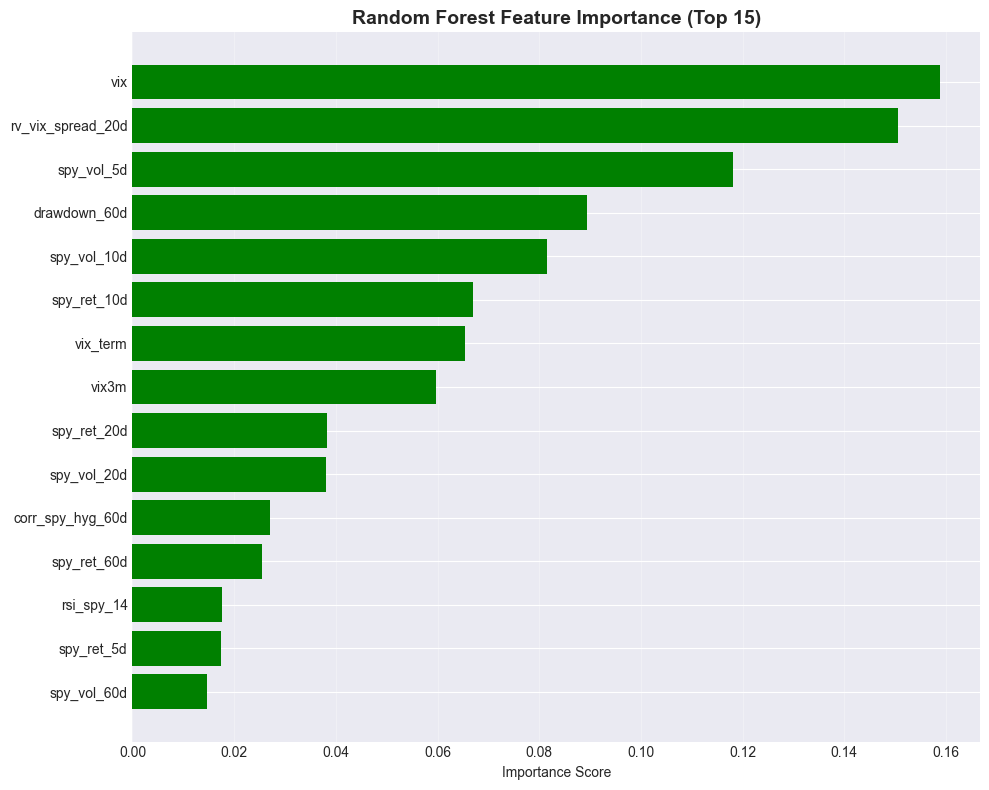

In [48]:
plt.figure(figsize=(10, 8))
top_15 = rf_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='green')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance (Top 15)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.7 Overfitting Diagnostics

Checking for overfitting by analyzing train-validation gaps and residual patterns.

In [49]:
#calculate train val gap for final model
train_val_gap = rf_final_train_rmse - rf_final_val_rmse
gap_percentage = (train_val_gap / rf_final_val_rmse) * 100

print("Overfitting Analysis:")
print(f"Train RMSE: {rf_final_train_rmse:.6f}")
print(f"Val RMSE: {rf_final_val_rmse:.6f}")
print(f"Gap: {train_val_gap:.6f} ({gap_percentage:.2f}%)")

if abs(gap_percentage) < 10:
    print("Good generalization, minimal overfitting")
elif abs(gap_percentage) < 20:
    print("Moderate gap, acceptable for complex models")
else:
    print("Large gap, potential overfitting")

Overfitting Analysis:
Train RMSE: 0.008006
Val RMSE: 0.009419
Gap: -0.001414 (-15.01%)
Moderate gap, acceptable for complex models


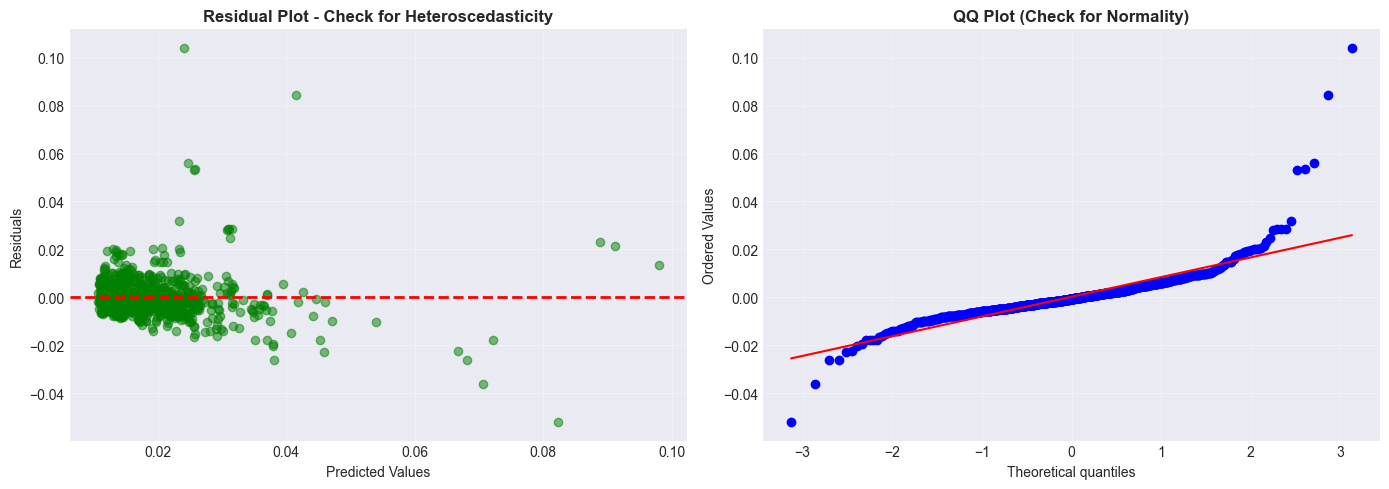

In [50]:
#residual analysis for final model
rf_residuals = y_val - rf_final_val_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#residuals vs predictions
axes[0].scatter(rf_final_val_pred, rf_residuals, alpha=0.5, color='green')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot - Check for Heteroscedasticity', fontweight='bold')
axes[0].grid(alpha=0.3)

#QQ plot for normality
from scipy import stats
stats.probplot(rf_residuals, dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot (Check for Normality)', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
print("\nResidual Statistics:")
print(f"Mean: {rf_residuals.mean():.6f} (should be ~0)")
print(f"Std: {rf_residuals.std():.6f}")
print(f"Skew: {stats.skew(rf_residuals):.4f} (0 = symmetric)")
print(f"Kurt: {stats.kurtosis(rf_residuals):.4f} (0 = normal)")


Residual Statistics:
Mean: 0.000222 (should be ~0)
Std: 0.009417
Skew: 3.2235 (0 = symmetric)
Kurt: 31.1771 (0 = normal)


## 5. XGBoost

Gradient boosting builds an ensemble of decision trees sequentially where each tree corrects errors from previous trees. XGBoost is an optimized implementation & often achieves sota performance on structured data.


#### Parameter Management Utility

Run this cell to check status or reset saved parameters

In [52]:
PARAMS_DIR = Path('../notebooks')
XGB_PARAMS_FILE = PARAMS_DIR / 'xgb_best_params_2010.json'
XGB_EARLY_PARAMS_FILE = PARAMS_DIR / 'xgb_early_stopping_results_2010.json'

def check_saved_params():
    """Check status of saved parameters"""
    print("XGBoost Saved Parameters Status:")
    print("=" * 60)
    
    if XGB_PARAMS_FILE.exists():
        with open(XGB_PARAMS_FILE, 'r') as f:
            data = json.load(f)
        print(f"Grid Search Results: FOUND")
        print(f"CV RMSE: {data['cv_score']:.6f}")
        print(f"Saved: {data.get('timestamp', 'Unknown')}")
        print(f"Params: {data['best_params']}")
    else:
        print(f"Grid Search Results: NOT FOUND")
    
    print()
    
    if XGB_EARLY_PARAMS_FILE.exists():
        with open(XGB_EARLY_PARAMS_FILE, 'r') as f:
            results = json.load(f)
        best = min(results, key=lambda x: x['val_rmse'])
        print(f"Early Stopping Results: FOUND")
        print(f"Best Val RMSE: {best['val_rmse']:.6f}")
        print(f"Configs tested: {len(results)}")
    else:
        print(f"Early Stopping Results: NOT FOUND")
    
    print("=" * 60)

def reset_saved_params(reset_grid=True, reset_early=True):
    """Delete saved parameters to force rerun"""
    if reset_grid and XGB_PARAMS_FILE.exists():
        XGB_PARAMS_FILE.unlink()
        print("Deleted grid search parameters")
    
    if reset_early and XGB_EARLY_PARAMS_FILE.exists():
        XGB_EARLY_PARAMS_FILE.unlink()
        print("Deleted early stopping results")
    
    print("\nRerun the cells to perform fresh grid search.")

#check current status
check_saved_params()

# Uncomment to reset:
#reset_saved_params(reset_grid=True, reset_early=True)

XGBoost Saved Parameters Status:
Grid Search Results: NOT FOUND

Early Stopping Results: NOT FOUND


In [53]:
def load_model_metrics():
    """Load and compare all saved model metrics"""
    METRICS_FILES = {
        'Linear Regression': PARAMS_DIR / 'linear_final_metrics_2010.json',
        'Random Forest': PARAMS_DIR / 'rf_final_metrics_2010.json',
        'XGBoost': PARAMS_DIR / 'xgb_final_metrics_2010.json',
        'LightGBM': PARAMS_DIR / 'lgbm_final_metrics_2010.json'
    }
    
    print("Saved Model Metrics:")
    print("=" * 80)
    
    all_metrics = {}
    for model_name, file_path in METRICS_FILES.items():
        if file_path.exists():
            with open(file_path, 'r') as f:
                metrics = json.load(f)
            all_metrics[model_name] = metrics
            
            print(f"\n{model_name}:")
            print(f"  Approach: {metrics['selected_approach']}")
            print(f"  Val RMSE: {metrics['metrics']['validation']['rmse']:.6f}")
            print(f"  Val R²:   {metrics['metrics']['validation']['r2']:.4f}")
            print(f"  Val MAE:  {metrics['metrics']['validation']['mae']:.6f}")
            print(f"  Saved:    {metrics['timestamp'][:10]}")
        else:
            print(f"\n{model_name}: NOT FOUND")
    
    print("=" * 80)
    
    if all_metrics:
        print("\nComparison (Validation RMSE):")
        sorted_models = sorted(all_metrics.items(), 
                              key=lambda x: x[1]['metrics']['validation']['rmse'])
        for i, (name, metrics) in enumerate(sorted_models, 1):
            rmse = metrics['metrics']['validation']['rmse']
            print(f"  {i}. {name}: {rmse:.6f}")
    
    return all_metrics

# Uncomment to view saved metrics:
# load_model_metrics()

### 5.1 Baseline Model

In [54]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [55]:
#train 
#baseline XGBoost with default parameters
xgb_baseline = XGBRegressor(random_state=42, n_jobs=-1)
xgb_baseline.fit(X_train, y_train)

#predict
xgb_baseline_train_pred = xgb_baseline.predict(X_train)
xgb_baseline_val_pred = xgb_baseline.predict(X_val)

#eval
xgb_baseline_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_baseline_train_pred))
xgb_baseline_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_baseline_val_pred))
xgb_baseline_val_r2 = r2_score(y_val, xgb_baseline_val_pred)

print(f"XGBoost Baseline Results:")
print(f"Train RMSE: {xgb_baseline_train_rmse:.6f}")
print(f"Val RMSE: {xgb_baseline_val_rmse:.6f}")
print(f"Val R²: {xgb_baseline_val_r2:.4f}")
print(f"Train-Val Gap: {xgb_baseline_train_rmse - xgb_baseline_val_rmse:.6f}")
print(f"Baseline uses all {X_train.shape[1]} features")

XGBoost Baseline Results:
Train RMSE: 0.000979
Val RMSE: 0.009966
Val R²: 0.3438
Train-Val Gap: -0.008987
Baseline uses all 20 features


### 5.2 Hyperparameter Tuning

In [56]:
#parameter save path
PARAMS_DIR = Path('../notebooks')
PARAMS_DIR.mkdir(exist_ok=True)
XGB_PARAMS_FILE = PARAMS_DIR / 'xgb_best_params_2010.json'
XGB_EARLY_PARAMS_FILE = PARAMS_DIR / 'xgb_early_stopping_results_2010.json'

#hyperparameter grid with regularization
xgb_param_grid = {
    'learning_rate': [0.01, 0.03],
    'max_depth': [3, 4, 5],
    'n_estimators': [300, 500, 800],
    'subsample': [.5, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1, 2], # L1 (feature selection)
    'reg_lambda': [1, 2, 5, 10] # L2 (weight shrinkage)
}

total_combinations = 1
for param, values in xgb_param_grid.items():
    total_combinations *= len(values)
    
print(f"XGBoost Grid Search Configuration:")
print(f"Total combinations: {total_combinations:,}")
print(f"Features: All {X_train.shape[1]} features")
print(f"CV folds: {tscv.n_splits}")
print(f"Regularization: L1 (reg_alpha) + L2 (reg_lambda)")
print(f"Parameters will be saved to: {XGB_PARAMS_FILE}")

XGBoost Grid Search Configuration:
Total combinations: 2,592
Features: All 20 features
CV folds: 5
Regularization: L1 (reg_alpha) + L2 (reg_lambda)
Parameters will be saved to: ../notebooks/xgb_best_params_2010.json


In [57]:
#check if saved parameters exist
if XGB_PARAMS_FILE.exists():
    print(f"Found saved parameters at {XGB_PARAMS_FILE}")
    print("loading saved parameters...\n")
    
    with open(XGB_PARAMS_FILE, 'r') as f:
        saved_data = json.load(f)
    
    xgb_tuned_params = saved_data['best_params']
    xgb_tuned_cv_score = saved_data['cv_score']
    
    # Train model with saved parameters
    xgb_tuned = XGBRegressor(**xgb_tuned_params, random_state=42, n_jobs=-1)
    xgb_tuned.fit(X_train, y_train)
    
    print(f"Loaded Best CV RMSE: {xgb_tuned_cv_score:.6f}")
    print(f"\nLoaded Parameters:")
    for param, value in xgb_tuned_params.items():
        print(f"  {param}: {value}")
    print("\n(To rerun grid search, delete the params file and rerun this cell)")
    
else:
    print("No saved parameters found. Running grid search...\n")
    
    # Execute grid search with time-series cross-validation
    xgb_grid_search = GridSearchCV(
        XGBRegressor(random_state=42, n_jobs=-1),
        xgb_param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    xgb_grid_search.fit(X_train, y_train)
    
    # Extract best model and parameters
    xgb_tuned = xgb_grid_search.best_estimator_
    xgb_tuned_params = xgb_grid_search.best_params_
    xgb_tuned_cv_score = -xgb_grid_search.best_score_
    
    # Save parameters for future use
    save_data = {
        'best_params': xgb_tuned_params,
        'cv_score': xgb_tuned_cv_score,
        'timestamp': pd.Timestamp.now().isoformat(),
        'n_train_samples': len(X_train),
        'n_features': X_train.shape[1]
    }
    
    with open(XGB_PARAMS_FILE, 'w') as f:
        json.dump(save_data, f, indent=2)
    
    print(f"\n✓ Grid Search Complete!")
    print(f"  Best CV RMSE: {xgb_tuned_cv_score:.6f}")
    print(f"  Parameters saved to: {XGB_PARAMS_FILE}")
    print(f"\nBest Parameters:")
    for param, value in xgb_tuned_params.items():
        print(f"  {param}: {value}")

No saved parameters found. Running grid search...

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits

✓ Grid Search Complete!
  Best CV RMSE: 0.010392
  Parameters saved to: ../notebooks/xgb_best_params_2010.json

Best Parameters:
  colsample_bytree: 0.7
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 500
  reg_alpha: 0
  reg_lambda: 10
  subsample: 0.5

✓ Grid Search Complete!
  Best CV RMSE: 0.010392
  Parameters saved to: ../notebooks/xgb_best_params_2010.json

Best Parameters:
  colsample_bytree: 0.7
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 500
  reg_alpha: 0
  reg_lambda: 10
  subsample: 0.5


### 5.3 Evaluate Tuned Model

In [58]:
#evaluate tuned model
xgb_tuned_train_pred = xgb_tuned.predict(X_train)
xgb_tuned_val_pred = xgb_tuned.predict(X_val)

xgb_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_tuned_train_pred))
xgb_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_tuned_val_pred))
xgb_tuned_val_r2 = r2_score(y_val, xgb_tuned_val_pred)

improvement = ((xgb_baseline_val_rmse - xgb_tuned_val_rmse) / xgb_baseline_val_rmse) * 100

print(f"\nTuned XGBoost Results:")
print(f"Train RMSE: {xgb_tuned_train_rmse:.6f}")
print(f"Val RMSE: {xgb_tuned_val_rmse:.6f}")
print(f"Val R²: {xgb_tuned_val_r2:.4f}")
print(f"Train-Val Gap: {xgb_tuned_train_rmse - xgb_tuned_val_rmse:.6f}")
print(f"\nImprovement over baseline: {improvement:.2f}%")


Tuned XGBoost Results:
Train RMSE: 0.007935
Val RMSE: 0.009183
Val R²: 0.4428
Train-Val Gap: -0.001248

Improvement over baseline: 7.85%


### 5.4 Early Stopping Experiment

lets test early stopping as an alternative to fixed n_estimators; try different patience values to find optimal stopping point.

In [59]:
#early stopping parameter
patience_values = [30, 50, 100]

print(f"Testing early stopping with patience values: {patience_values}")
print(f"Results will be saved to: {XGB_EARLY_PARAMS_FILE}\n")

Testing early stopping with patience values: [30, 50, 100]
Results will be saved to: ../notebooks/xgb_early_stopping_results_2010.json



In [60]:
#check if early stopping results already exist
if XGB_EARLY_PARAMS_FILE.exists():
    print(f"Found saved early stopping results at {XGB_EARLY_PARAMS_FILE}")
    print("loading saved results...\n")
    
    with open(XGB_EARLY_PARAMS_FILE, 'r') as f:
        early_stopping_results = json.load(f)
    
    best_early_config = min(early_stopping_results, key=lambda x: x['val_rmse'])
    
    print(f"Loaded {len(early_stopping_results)} early stopping configurations")
    print(f"\nBest configuration:")
    print(f"Patience: {best_early_config['patience']}")
    print(f"Stopped at: {best_early_config['stopped_at']} trees")
    print(f"Val RMSE: {best_early_config['val_rmse']:.6f}")
    print("\n(To rerun experiment, delete the file and rerun this cell)")
    
else:
    print("No saved results found. Running early stopping experiment...\n")
    
    early_stopping_results = []
    
    for patience in patience_values:
        print(f"Testing patience = {patience}...")
        
        #train with early stopping
        xgb_early = XGBRegressor(
            learning_rate=xgb_tuned_params['learning_rate'],
            max_depth=xgb_tuned_params['max_depth'],
            subsample=xgb_tuned_params['subsample'],
            colsample_bytree=xgb_tuned_params['colsample_bytree'],
            reg_alpha=xgb_tuned_params['reg_alpha'],
            reg_lambda=xgb_tuned_params['reg_lambda'],
            n_estimators=1000,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=patience
        )
        
        xgb_early.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        stopped_at = xgb_early.best_iteration + 1
        xgb_early_val_pred = xgb_early.predict(X_val)
        xgb_early_rmse = np.sqrt(mean_squared_error(y_val, xgb_early_val_pred))
        
        config = {
            'patience': patience,
            'stopped_at': stopped_at,
            'val_rmse': xgb_early_rmse
        }
        early_stopping_results.append(config)
        
        print(f"  Stopped at {stopped_at} trees, Val RMSE: {xgb_early_rmse:.6f}")
    
    #save results
    with open(XGB_EARLY_PARAMS_FILE, 'w') as f:
        json.dump(early_stopping_results, f, indent=2)
    
    best_early_config = min(early_stopping_results, key=lambda x: x['val_rmse'])
    
    print(f"\n✓Early Stopping Experiment Complete!")
    print(f"  Results saved to: {XGB_EARLY_PARAMS_FILE}")
    print(f"\nBest configuration:")
    print(f"  Patience: {best_early_config['patience']}")
    print(f"  Stopped at: {best_early_config['stopped_at']} trees")
    print(f"  Val RMSE: {best_early_config['val_rmse']:.6f}")

No saved results found. Running early stopping experiment...

Testing patience = 30...
  Stopped at 495 trees, Val RMSE: 0.009180
Testing patience = 50...
  Stopped at 495 trees, Val RMSE: 0.009180
Testing patience = 50...
  Stopped at 495 trees, Val RMSE: 0.009180
Testing patience = 100...
  Stopped at 495 trees, Val RMSE: 0.009180
Testing patience = 100...
  Stopped at 495 trees, Val RMSE: 0.009180

✓Early Stopping Experiment Complete!
  Results saved to: ../notebooks/xgb_early_stopping_results_2010.json

Best configuration:
  Patience: 30
  Stopped at: 495 trees
  Val RMSE: 0.009180
  Stopped at 495 trees, Val RMSE: 0.009180

✓Early Stopping Experiment Complete!
  Results saved to: ../notebooks/xgb_early_stopping_results_2010.json

Best configuration:
  Patience: 30
  Stopped at: 495 trees
  Val RMSE: 0.009180


In [61]:
#evaluate best early stopping model on both sets
xgb_early_stop = XGBRegressor(
    learning_rate=xgb_tuned_params['learning_rate'],
    max_depth=xgb_tuned_params['max_depth'],
    subsample=xgb_tuned_params['subsample'],
    colsample_bytree=xgb_tuned_params['colsample_bytree'],
    reg_alpha=xgb_tuned_params['reg_alpha'],
    reg_lambda=xgb_tuned_params['reg_lambda'],
    n_estimators=best_early_config['stopped_at'],
    random_state=42,
    n_jobs=-1
)
xgb_early_stop.fit(X_train, y_train)

xgb_early_train_pred = xgb_early_stop.predict(X_train)
xgb_early_val_pred = xgb_early_stop.predict(X_val)

xgb_early_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_early_train_pred))
xgb_early_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_early_val_pred))
xgb_early_val_r2 = r2_score(y_val, xgb_early_val_pred)

improvement_early = ((xgb_baseline_val_rmse - xgb_early_val_rmse) / xgb_baseline_val_rmse) * 100

print(f"\nEarly Stopping XGBoost Results:")
print(f"Train RMSE: {xgb_early_train_rmse:.6f}")
print(f"Val RMSE: {xgb_early_val_rmse:.6f}")
print(f"Val R²: {xgb_early_val_r2:.4f}")
print(f"Train-Val Gap: {xgb_early_train_rmse - xgb_early_val_rmse:.6f}")
print(f"\nImprovement over baseline: {improvement_early:.2f}%")


Early Stopping XGBoost Results:
Train RMSE: 0.007944
Val RMSE: 0.009180
Val R²: 0.4432
Train-Val Gap: -0.001236

Improvement over baseline: 7.88%


### 5.5 Model Selection

Compare grid search CV and early stopping approaches then select the best model for final evaluation.

In [62]:
print("Model Selection - Comparing Approaches:\n")
print("="*60)
print(f"{'Metric':<20} {'Grid Search CV':<20} {'Early Stopping':<20}")
print("="*60)

#validation RMSE
rmse_diff = xgb_early_val_rmse - xgb_tuned_val_rmse
rmse_pct = (rmse_diff / xgb_tuned_val_rmse) * 100
print(f"{'Val RMSE':<20} {xgb_tuned_val_rmse:.6f}{'':>13} {xgb_early_val_rmse:.6f}")

#validation R²
print(f"{'Val R²':<20} {xgb_tuned_val_r2:.4f}{'':>15} {xgb_early_val_r2:.4f}")

#train-val gap
tuned_gap = xgb_tuned_train_rmse - xgb_tuned_val_rmse
early_gap = xgb_early_train_rmse - xgb_early_val_rmse
print(f"{'Train-Val Gap':<20} {tuned_gap:.6f}{'':>13} {early_gap:.6f}")

#validation MAE
tuned_val_mae = mean_absolute_error(y_val, xgb_tuned_val_pred)
early_val_mae = mean_absolute_error(y_val, xgb_early_val_pred)
print(f"{'Val MAE':<20} {tuned_val_mae:.6f}{'':>13} {early_val_mae:.6f}")

print("="*60)

#decision logic: consider multiple factors
print(f"\nDifference Analysis:")
print(f"RMSE difference: {rmse_diff:.6f} ({rmse_pct:+.2f}%)")

#select best model based on validation RMSE (primary) and R² (secondary)
if abs(rmse_pct) < 0.5:  # less than 0.5% difference
    print("→ Negligible RMSE difference (<0.5%), checking other metrics...")
    
    #use R² as tiebreaker
    if xgb_early_val_r2 > xgb_tuned_val_r2:
        xgb_final = xgb_early_stop
        xgb_final_train_pred = xgb_early_train_pred
        xgb_final_val_pred = xgb_early_val_pred
        selected_approach = "Early Stopping"
        print(f"Selected: Early Stopping (better R²: {xgb_early_val_r2:.4f} vs {xgb_tuned_val_r2:.4f})")
    else:
        xgb_final = xgb_tuned
        xgb_final_val_pred = xgb_tuned_val_pred
        xgb_final_train_pred = xgb_tuned_train_pred
        selected_approach = "Grid Search with CV"
        print(f"Selected: Grid Search (better R²: {xgb_tuned_val_r2:.4f} vs {xgb_early_val_r2:.4f})")
else:
    #clear winner based on RMSE
    if xgb_early_val_rmse < xgb_tuned_val_rmse:
        xgb_final = xgb_early_stop
        xgb_final_train_pred = xgb_early_train_pred
        xgb_final_val_pred = xgb_early_val_pred
        selected_approach = "Early Stopping"
        print(f"Selected: Early Stopping (better RMSE: {xgb_early_val_rmse:.6f})")
    else:
        xgb_final = xgb_tuned
        xgb_final_val_pred = xgb_tuned_val_pred
        xgb_final_train_pred = xgb_tuned_train_pred
        selected_approach = "Grid Search with CV"
        print(f"Selected: Grid Search (better RMSE: {xgb_tuned_val_rmse:.6f})")

Model Selection - Comparing Approaches:

Metric               Grid Search CV       Early Stopping      
Val RMSE             0.009183              0.009180
Val R²               0.4428                0.4432
Train-Val Gap        -0.001248              -0.001236
Val MAE              0.005625              0.005620

Difference Analysis:
RMSE difference: -0.000003 (-0.03%)
→ Negligible RMSE difference (<0.5%), checking other metrics...
Selected: Early Stopping (better R²: 0.4432 vs 0.4428)


In [63]:
#compute comprehensive metrics for final model
from sklearn.metrics import mean_absolute_error

xgb_final_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_final_train_pred))
xgb_final_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_final_val_pred))
xgb_final_train_mae = mean_absolute_error(y_train, xgb_final_train_pred)
xgb_final_val_mae = mean_absolute_error(y_val, xgb_final_val_pred)
xgb_final_train_r2 = r2_score(y_train, xgb_final_train_pred)
xgb_final_val_r2 = r2_score(y_val, xgb_final_val_pred)

#store metrics for later comparison
xgb_final_metrics = {
    'model': 'XGBoost',
    'approach': selected_approach,
    'train_rmse': xgb_final_train_rmse,
    'val_rmse': xgb_final_val_rmse,
    'train_mae': xgb_final_train_mae,
    'val_mae': xgb_final_val_mae,
    'train_r2': xgb_final_train_r2,
    'val_r2': xgb_final_val_r2
}

print("\n" + "="*60)
print("FINAL XGBOOST MODEL - COMPREHENSIVE METRICS")
print("="*60)
print(f"Approach: {selected_approach}")
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_final_train_rmse:.6f}")
print(f"  MAE:  {xgb_final_train_mae:.6f}")
print(f"  R²:   {xgb_final_train_r2:.4f}")
print(f"\nValidation Set:")
print(f"  RMSE: {xgb_final_val_rmse:.6f}")
print(f"  MAE:  {xgb_final_val_mae:.6f}")
print(f"  R²:   {xgb_final_val_r2:.4f}")
print(f"\nGeneralization:")
print(f"  Train-Val RMSE Gap: {xgb_final_train_rmse - xgb_final_val_rmse:.6f}")
print("="*60)


FINAL XGBOOST MODEL - COMPREHENSIVE METRICS
Approach: Early Stopping

Training Set:
  RMSE: 0.007944
  MAE:  0.005376
  R²:   0.7240

Validation Set:
  RMSE: 0.009180
  MAE:  0.005620
  R²:   0.4432

Generalization:
  Train-Val RMSE Gap: -0.001236


In [64]:
#save final model metrics to json for later comparison
XGB_METRICS_FILE = PARAMS_DIR / 'xgb_final_metrics_2010.json'

#calculate feature importance for saving
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False)

xgb_metrics_to_save = {
    'model_name': 'XGBoost',
    'selected_approach': selected_approach,
    'timestamp': pd.Timestamp.now().isoformat(),
    'data_info': {
        'n_train_samples': len(X_train),
        'n_val_samples': len(X_val),
        'n_features': X_train.shape[1]
    },
    'hyperparameters': xgb_tuned_params if selected_approach == "Grid Search with CV" else {
        **xgb_tuned_params,
        'n_estimators': best_early_config['stopped_at'],
        'early_stopping_used': True,
        'patience': best_early_config['patience']
    },
    'metrics': {
        'train': {
            'rmse': float(xgb_final_train_rmse),
            'mae': float(xgb_final_train_mae),
            'r2': float(xgb_final_train_r2)
        },
        'validation': {
            'rmse': float(xgb_final_val_rmse),
            'mae': float(xgb_final_val_mae),
            'r2': float(xgb_final_val_r2)
        },
        'generalization': {
            'train_val_gap_rmse': float(xgb_final_train_rmse - xgb_final_val_rmse),
            'gap_percentage': float((xgb_final_train_rmse - xgb_final_val_rmse) / xgb_final_val_rmse * 100)
        }
    },
    'feature_importance': {
        'top_10': xgb_importance.head(10)[['feature', 'importance']].to_dict('records'),
        'all_features': xgb_importance[['feature', 'importance']].to_dict('records')
    },
    'comparison': {
        'baseline_val_rmse': float(xgb_baseline_val_rmse),
        'improvement_pct': float((xgb_baseline_val_rmse - xgb_final_val_rmse) / xgb_baseline_val_rmse * 100)
    }
}

with open(XGB_METRICS_FILE, 'w') as f:
    json.dump(xgb_metrics_to_save, f, indent=2)

print(f"\nfinal model metrics saved to: {XGB_METRICS_FILE}")


final model metrics saved to: ../notebooks/xgb_final_metrics_2010.json


### 5.6 Feature Importance Analysis

XGBoost provides native feature importance based on how often features are used in tree splits. reveals which features the model considers most valuable.

In [65]:
#feature importance already calculated in metrics save cell above
print("Top 10 Most Important Features:")
print(xgb_importance.head(10).to_string(index=False))
print(f"\nTotal features with non-zero importance: {(xgb_importance['importance'] > 0).sum()}/{len(feature_cols)}")

Top 10 Most Important Features:
          feature  importance
              vix    0.202126
rv_vix_spread_20d    0.140521
     drawdown_60d    0.119018
       spy_vol_5d    0.113629
      spy_vol_10d    0.073150
      spy_ret_10d    0.060053
         vix_term    0.059451
            vix3m    0.037302
      spy_ret_20d    0.030753
 corr_spy_hyg_20d    0.020200

Total features with non-zero importance: 20/20


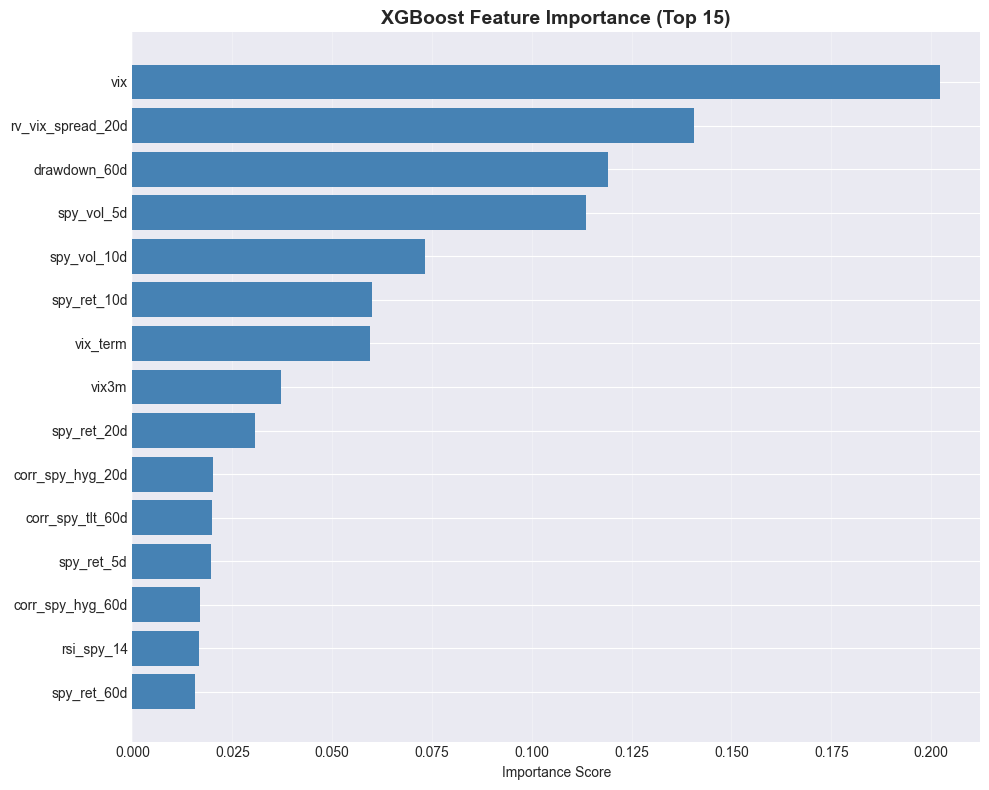

In [66]:
plt.figure(figsize=(10, 8))
top_15 = xgb_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance (Top 15)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.7 Overfitting Diagnostics

Check for overfitting by analyzing train-val gaps and residual patterns.

In [67]:
#calculate train val gap for final model
train_val_gap = xgb_final_train_rmse - xgb_final_val_rmse
gap_percentage = (train_val_gap / xgb_final_val_rmse) * 100

print("Overfitting Analysis:")
print(f"Train RMSE: {xgb_final_train_rmse:.6f}")
print(f"Val RMSE: {xgb_final_val_rmse:.6f}")
print(f"Gap: {train_val_gap:.6f} ({gap_percentage:.2f}%)")

if abs(gap_percentage) < 10:
    print("Good generalization, minimal overfitting")
elif abs(gap_percentage) < 20:
    print("Moderate gap, acceptable for complex models")
else:
    print("Large gap, potential overfitting")

Overfitting Analysis:
Train RMSE: 0.007944
Val RMSE: 0.009180
Gap: -0.001236 (-13.46%)
Moderate gap, acceptable for complex models


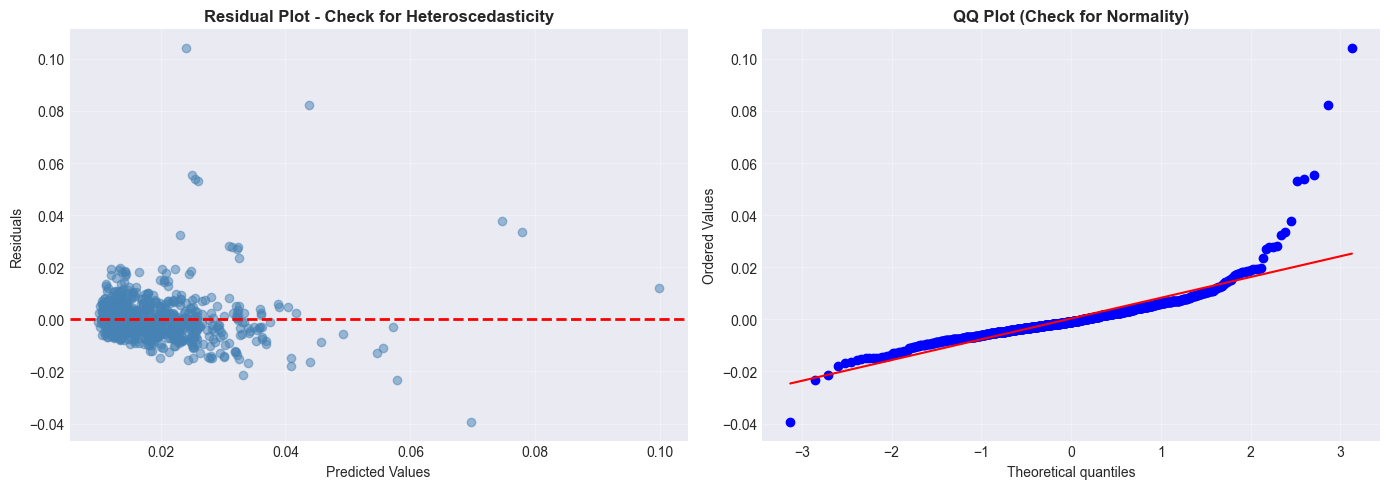

In [68]:
#residual analysis for final model
xgb_residuals = y_val - xgb_final_val_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#residuals vs predictions
axes[0].scatter(xgb_final_val_pred, xgb_residuals, alpha=0.5, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot - Check for Heteroscedasticity', fontweight='bold')
axes[0].grid(alpha=0.3)

#QQ plot for normality
from scipy import stats
stats.probplot(xgb_residuals, dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot (Check for Normality)', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [69]:
print("\nResidual Statistics:")
print(f"Mean: {xgb_residuals.mean():.6f} (should be ~0)")
print(f"Std: {xgb_residuals.std():.6f}")
print(f"Skew: {stats.skew(xgb_residuals):.4f} (0 = symmetric)")
print(f"Kurt: {stats.kurtosis(xgb_residuals):.4f} (0 = normal)")


Residual Statistics:
Mean: 0.000301 (should be ~0)
Std: 0.009175
Skew: 3.7612 (0 = symmetric)
Kurt: 32.8573 (0 = normal)


## 6. LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms; designed for distributed and efficient training with better accuracy and faster speed than traditional methods.

#### Parameter Management Utility

Run this cell to check status or reset saved parameters.

In [70]:
PARAMS_DIR = Path('../notebooks')
LGBM_PARAMS_FILE = PARAMS_DIR / 'lgbm_best_params_2010.json'
LGBM_EARLY_PARAMS_FILE = PARAMS_DIR / 'lgbm_early_stopping_results_2010.json'

def check_saved_params_lgbm():
    """Check status of saved parameters"""
    print("LightGBM Saved Parameters Status:")
    print("=" * 60)
    
    if LGBM_PARAMS_FILE.exists():
        with open(LGBM_PARAMS_FILE, 'r') as f:
            data = json.load(f)
        print(f"Grid Search Results: FOUND")
        print(f"CV RMSE: {data['cv_score']:.6f}")
        print(f"Saved: {data.get('timestamp', 'Unknown')}")
        print(f"Params: {data['best_params']}")
    else:
        print(f"Grid Search Results: NOT FOUND")
    
    print()
    
    if LGBM_EARLY_PARAMS_FILE.exists():
        with open(LGBM_EARLY_PARAMS_FILE, 'r') as f:
            results = json.load(f)
        best = min(results, key=lambda x: x['val_rmse'])
        print(f"Early Stopping Results: FOUND")
        print(f"Best Val RMSE: {best['val_rmse']:.6f}")
        print(f"Best Patience: {best['patience']}")
        print(f"Configs tested: {len(results)}")
    else:
        print(f"Early Stopping Results: NOT FOUND")
    
    print("=" * 60)

def reset_saved_params_lgbm(reset_grid=True, reset_early=True):
    """Delete saved parameters to force rerun"""
    if reset_grid and LGBM_PARAMS_FILE.exists():
        LGBM_PARAMS_FILE.unlink()
        print("Deleted grid search parameters")
    
    if reset_early and LGBM_EARLY_PARAMS_FILE.exists():
        LGBM_EARLY_PARAMS_FILE.unlink()
        print("Deleted early stopping results")
    
    print("\nRerun the cells to perform fresh grid search.")

#check current status
check_saved_params_lgbm()

# Uncomment to reset:
#reset_saved_params_lgbm(reset_grid=True, reset_early=True)

LightGBM Saved Parameters Status:
Grid Search Results: NOT FOUND

Early Stopping Results: NOT FOUND


### 6.1 Baseline Model

In [71]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import lightgbm as lgb

In [72]:
#train
#baseline LightGBM with default parameters
lgbm_baseline = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
lgbm_baseline.fit(X_train, y_train)

#predict
lgbm_baseline_train_pred = lgbm_baseline.predict(X_train)
lgbm_baseline_val_pred = lgbm_baseline.predict(X_val)

#eval
lgbm_baseline_train_rmse = np.sqrt(mean_squared_error(y_train, lgbm_baseline_train_pred))
lgbm_baseline_val_rmse = np.sqrt(mean_squared_error(y_val, lgbm_baseline_val_pred))
lgbm_baseline_val_r2 = r2_score(y_val, lgbm_baseline_val_pred)

print(f"LightGBM Baseline Results:")
print(f"Train RMSE: {lgbm_baseline_train_rmse:.6f}")
print(f"Val RMSE: {lgbm_baseline_val_rmse:.6f}")
print(f"Val R²: {lgbm_baseline_val_r2:.4f}")
print(f"Train-Val Gap: {lgbm_baseline_train_rmse - lgbm_baseline_val_rmse:.6f}")
print(f"Baseline uses all {X_train.shape[1]} features")

LightGBM Baseline Results:
Train RMSE: 0.004062
Val RMSE: 0.009891
Val R²: 0.3537
Train-Val Gap: -0.005829
Baseline uses all 20 features


### 6.2 Hyperparameter Tuning

In [73]:
#parameter save path
PARAMS_DIR = Path('../notebooks')
PARAMS_DIR.mkdir(exist_ok=True)
LGBM_PARAMS_FILE = PARAMS_DIR / 'lgbm_best_params_2010.json'
LGBM_EARLY_PARAMS_FILE = PARAMS_DIR / 'lgbm_early_stopping_results_2010.json'

#time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

#refined hyperparameter grid - expand in direction of best values
#previous: lr=0.01(min), depth=5(max), n_est=500(max), leaves=31(min), sub=0.8(min), col=0.8(min), L1=0(min), L2=2(max)
lgbm_param_grid = {
    'learning_rate': [0.005, 0.01],  # best=0.01(min), expand lower
    'max_depth': [5, 7],  # best=5(max), expand higher
    'n_estimators': [500, 800],  # best=500(max) higher
    'num_leaves': [21, 31],  # best=31(min) lower
    'subsample': [0.7, 0.8],  # best=0.8(min), lower
    'colsample_bytree': [0.7, 0.8],  # best=0.8(min),lower
    'reg_alpha': [0],  # best=0(min) (can't go lower)
    'reg_lambda': [2, 5]  # best=2(max), expand higher
}

total_combinations = 1
for param, values in lgbm_param_grid.items():
    total_combinations *= len(values)
    
print(f"LightGBM Grid Search Configuration:")
print(f"Total combinations: {total_combinations:,}")
print(f"Features: All {X_train.shape[1]} features")
print(f"CV folds: {tscv.n_splits}")
print(f"\nRefined based on previous best:")
print(f"  Previous: lr=0.01, depth=5, n_est=500, leaves=31, sub=0.8, col=0.8, L1=0, L2=2")
print(f"  Strategy: Expand each parameter in direction of best value")

LightGBM Grid Search Configuration:
Total combinations: 128
Features: All 20 features
CV folds: 5

Refined based on previous best:
  Previous: lr=0.01, depth=5, n_est=500, leaves=31, sub=0.8, col=0.8, L1=0, L2=2
  Strategy: Expand each parameter in direction of best value


In [74]:
#check if saved parameters exist
if LGBM_PARAMS_FILE.exists():
    print(f"Found saved parameters at {LGBM_PARAMS_FILE}")
    print("Loading saved parameters...\n")
    
    with open(LGBM_PARAMS_FILE, 'r') as f:
        saved_data = json.load(f)
    
    lgbm_tuned_params = saved_data['best_params']
    lgbm_tuned_cv_score = saved_data['cv_score']
    
    # Train model with saved parameters
    lgbm_tuned = LGBMRegressor(**lgbm_tuned_params, random_state=42, n_jobs=-1, verbose=-1)
    lgbm_tuned.fit(X_train, y_train)
    
    print(f"Loaded Best CV RMSE: {lgbm_tuned_cv_score:.6f}")
    print(f"Best Parameters: {lgbm_tuned_params}")
    
else:
    print("No saved parameters found. Running grid search...")
    print(f"Total combinations to test: {total_combinations:,}\n")
    
    # Grid search with time series CV
    lgbm_grid_search = GridSearchCV(
        LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
        param_grid=lgbm_param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2
    )
    
    print("Starting grid search...")
    start_time = time.time()
    lgbm_grid_search.fit(X_train, y_train)
    elapsed = time.time() - start_time
    
    lgbm_tuned_params = lgbm_grid_search.best_params_
    lgbm_tuned_cv_score = np.sqrt(-lgbm_grid_search.best_score_)
    lgbm_tuned = lgbm_grid_search.best_estimator_
    
    print(f"\nGrid search complete in {elapsed/60:.1f} minutes")
    print(f"Best CV RMSE: {lgbm_tuned_cv_score:.6f}")
    print(f"Best Parameters: {lgbm_tuned_params}")
    
    # Save parameters
    save_data = {
        'best_params': lgbm_tuned_params,
        'cv_score': lgbm_tuned_cv_score,
        'timestamp': pd.Timestamp.now().isoformat(),
        'n_combinations': total_combinations,
        'elapsed_minutes': elapsed/60
    }
    
    with open(LGBM_PARAMS_FILE, 'w') as f:
        json.dump(save_data, f, indent=2)
    
    print(f"Parameters saved to {LGBM_PARAMS_FILE}")

No saved parameters found. Running grid search...
Total combinations to test: 128

Starting grid search...
Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=5, n_estimators=500, num_leaves=21, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   6.6s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=5, n_estimators=500, num_leaves=21, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=5, n_estimators=500, num_leaves=21, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   6.6s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=5, n_estimators=500, num_leaves=21, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=5, n_estimators=500, num_leaves=21, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=0.7, lear

### 6.3 Evaluate Tuned Model

In [75]:
#predict
lgbm_tuned_train_pred = lgbm_tuned.predict(X_train)
lgbm_tuned_val_pred = lgbm_tuned.predict(X_val)

#eval
lgbm_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, lgbm_tuned_train_pred))
lgbm_tuned_val_rmse = np.sqrt(mean_squared_error(y_val, lgbm_tuned_val_pred))
lgbm_tuned_val_r2 = r2_score(y_val, lgbm_tuned_val_pred)

print("LightGBM Tuned Model Performance:")
print(f"Train RMSE: {lgbm_tuned_train_rmse:.6f}")
print(f"Val RMSE: {lgbm_tuned_val_rmse:.6f}")
print(f"Val R²: {lgbm_tuned_val_r2:.4f}")
print(f"Train-Val Gap: {lgbm_tuned_train_rmse - lgbm_tuned_val_rmse:.6f}")

#improvement
improvement_lgbm = (lgbm_baseline_val_rmse - lgbm_tuned_val_rmse) / lgbm_baseline_val_rmse * 100
print(f"\nImprovement over baseline: {improvement_lgbm:.2f}%")

LightGBM Tuned Model Performance:
Train RMSE: 0.007451
Val RMSE: 0.009483
Val R²: 0.4059
Train-Val Gap: -0.002032

Improvement over baseline: 4.12%


### 6.4 Early Stopping Experiment

Early stopping prevents overfitting by monitoring validation performance during training and stopping when performance degrades, test different patience values to find optimal stopping point.

In [76]:
#setup params directory
PARAMS_DIR = Path('../notebooks')
PARAMS_DIR.mkdir(exist_ok=True)
LGBM_EARLY_PARAMS_FILE = PARAMS_DIR / 'lgbm_early_stopping_results_2010.json'

#try to load saved early stopping results
loaded = False
if LGBM_EARLY_PARAMS_FILE.exists():
    try:
        with open(LGBM_EARLY_PARAMS_FILE, 'r') as f:
            early_stopping_results = json.load(f)
        best_early_config = min(early_stopping_results, key=lambda x: x['val_rmse'])
        print("loaded early stopping results from:", LGBM_EARLY_PARAMS_FILE)
        print(f"best config: patience={best_early_config['patience']}, n_estimators={best_early_config['stopped_at']}, val_rmse={best_early_config['val_rmse']:.6f}")
        loaded = True
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error loading saved file: {e}")
        print("Will run early stopping experiment...")

if not loaded:
    #test different patience values
    patience_values = [30, 50, 100]
    early_stopping_results = []
    
    for patience in patience_values:
        print(f"\ntesting patience={patience}")
        
        #get base params and override n_estimators
        temp_params = lgbm_tuned.get_params().copy()
        temp_params['n_estimators'] = 2000
        temp_params['random_state'] = 42
        temp_params['n_jobs'] = -1
        temp_params['verbose'] = -1
        
        #train with early stopping
        lgbm_temp = LGBMRegressor(**temp_params)
        
        lgbm_temp.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=patience, verbose=False),
                lgb.log_evaluation(0)
            ]
        )
        
        best_iter = lgbm_temp.best_iteration_
        
        #retrain without eval_set to get clean model
        final_params = lgbm_tuned.get_params().copy()
        final_params['n_estimators'] = best_iter
        final_params['random_state'] = 42
        final_params['n_jobs'] = -1
        final_params['verbose'] = -1
        
        lgbm_final_temp = LGBMRegressor(**final_params)
        lgbm_final_temp.fit(X_train, y_train)
        
        #predict
        val_pred = lgbm_final_temp.predict(X_val)
        
        #eval
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        
        early_stopping_results.append({
            'patience': patience,
            'stopped_at': int(best_iter),
            'val_rmse': float(val_rmse)
        })
        
        print(f"  stopped at {best_iter} estimators, val_rmse={val_rmse:.6f}")
    
    #find best config
    best_early_config = min(early_stopping_results, key=lambda x: x['val_rmse'])
    
    #save results as list (matching XGBoost format)
    with open(LGBM_EARLY_PARAMS_FILE, 'w') as f:
        json.dump(early_stopping_results, f, indent=2)
    print(f"\nsaved early stopping results to: {LGBM_EARLY_PARAMS_FILE}")
    print(f"best config: patience={best_early_config['patience']}, n_estimators={best_early_config['stopped_at']}, val_rmse={best_early_config['val_rmse']:.6f}")


testing patience=30
  stopped at 394 estimators, val_rmse=0.009231

testing patience=50
  stopped at 394 estimators, val_rmse=0.009231

testing patience=50
  stopped at 394 estimators, val_rmse=0.009231

testing patience=100
  stopped at 394 estimators, val_rmse=0.009231

testing patience=100
  stopped at 394 estimators, val_rmse=0.009231

saved early stopping results to: ../notebooks/lgbm_early_stopping_results_2010.json
best config: patience=30, n_estimators=394, val_rmse=0.009231
  stopped at 394 estimators, val_rmse=0.009231

saved early stopping results to: ../notebooks/lgbm_early_stopping_results_2010.json
best config: patience=30, n_estimators=394, val_rmse=0.009231


In [77]:
#train final model with best early stopping config
early_params = lgbm_tuned.get_params().copy()
early_params['n_estimators'] = best_early_config['stopped_at']
early_params['random_state'] = 42
early_params['n_jobs'] = -1
early_params['verbose'] = -1

lgbm_early_stop = LGBMRegressor(**early_params)

#train
lgbm_early_stop.fit(X_train, y_train)

#predict
lgbm_early_train_pred = lgbm_early_stop.predict(X_train)
lgbm_early_val_pred = lgbm_early_stop.predict(X_val)

#eval
lgbm_early_train_rmse = np.sqrt(mean_squared_error(y_train, lgbm_early_train_pred))
lgbm_early_val_rmse = np.sqrt(mean_squared_error(y_val, lgbm_early_val_pred))
lgbm_early_val_r2 = r2_score(y_val, lgbm_early_val_pred)
lgbm_early_val_mae = mean_absolute_error(y_val, lgbm_early_val_pred)

print(f"\nLightGBM Early Stopping (patience={best_early_config['patience']}, n_estimators={best_early_config['stopped_at']}):")
print(f"  train rmse: {lgbm_early_train_rmse:.6f}")
print(f"  val rmse:   {lgbm_early_val_rmse:.6f}")
print(f"  val r2:     {lgbm_early_val_r2:.6f}")
print(f"  val mae:    {lgbm_early_val_mae:.6f}")


LightGBM Early Stopping (patience=30, n_estimators=394):
  train rmse: 0.008358
  val rmse:   0.009231
  val r2:     0.437016
  val mae:    0.005617


### 6.5 Model Selection: Grid Search CV vs Early Stopping

Compare tuned model from grid search vs early stopping approach. Select final model using 0.5% RMSE threshold + R² tiebreaker.

In [78]:
#compare models
print("LightGBM Model Comparison:")
print(f"  Grid Search CV:   val_rmse={lgbm_tuned_val_rmse:.6f}, val_r2={lgbm_tuned_val_r2:.6f}")
print(f"  Early Stopping:   val_rmse={lgbm_early_val_rmse:.6f}, val_r2={lgbm_early_val_r2:.6f}")

#select best model using 0.5% threshold + r2 tiebreaker
rmse_diff_pct = abs(lgbm_tuned_val_rmse - lgbm_early_val_rmse) / min(lgbm_tuned_val_rmse, lgbm_early_val_rmse) * 100

if rmse_diff_pct < 0.5:
    #within 0.5% - use r2 as tiebreaker
    if lgbm_tuned_val_r2 > lgbm_early_val_r2:
        lgbm_final = lgbm_tuned
        lgbm_final_name = "Grid Search CV"
        lgbm_final_train_pred = lgbm_tuned_train_pred
        lgbm_final_val_pred = lgbm_tuned_val_pred
        lgbm_final_train_rmse = lgbm_tuned_train_rmse
        lgbm_final_val_rmse = lgbm_tuned_val_rmse
        lgbm_final_val_r2 = lgbm_tuned_val_r2
        lgbm_final_val_mae = mean_absolute_error(y_val, lgbm_final_val_pred)
    else:
        lgbm_final = lgbm_early_stop
        lgbm_final_name = "Early Stopping"
        lgbm_final_train_pred = lgbm_early_train_pred
        lgbm_final_val_pred = lgbm_early_val_pred
        lgbm_final_train_rmse = lgbm_early_train_rmse
        lgbm_final_val_rmse = lgbm_early_val_rmse
        lgbm_final_val_r2 = lgbm_early_val_r2
        lgbm_final_val_mae = lgbm_early_val_mae
    print(f"\nRMSE within 0.5% ({rmse_diff_pct:.2f}%) - selected {lgbm_final_name} based on higher R²")
else:
    #use model with lower rmse
    if lgbm_tuned_val_rmse < lgbm_early_val_rmse:
        lgbm_final = lgbm_tuned
        lgbm_final_name = "Grid Search CV"
        lgbm_final_train_pred = lgbm_tuned_train_pred
        lgbm_final_val_pred = lgbm_tuned_val_pred
        lgbm_final_train_rmse = lgbm_tuned_train_rmse
        lgbm_final_val_rmse = lgbm_tuned_val_rmse
        lgbm_final_val_r2 = lgbm_tuned_val_r2
        lgbm_final_val_mae = mean_absolute_error(y_val, lgbm_final_val_pred)
    else:
        lgbm_final = lgbm_early_stop
        lgbm_final_name = "Early Stopping"
        lgbm_final_train_pred = lgbm_early_train_pred
        lgbm_final_val_pred = lgbm_early_val_pred
        lgbm_final_train_rmse = lgbm_early_train_rmse
        lgbm_final_val_rmse = lgbm_early_val_rmse
        lgbm_final_val_r2 = lgbm_early_val_r2
        lgbm_final_val_mae = lgbm_early_val_mae
    print(f"\nSelected {lgbm_final_name} with lower RMSE")

print(f"\nFinal LightGBM Model ({lgbm_final_name}):")
print(f"  train rmse: {lgbm_final_train_rmse:.6f}")
print(f"  val rmse:   {lgbm_final_val_rmse:.6f}")
print(f"  val r2:     {lgbm_final_val_r2:.6f}")
print(f"  val mae:    {lgbm_final_val_mae:.6f}")

LightGBM Model Comparison:
  Grid Search CV:   val_rmse=0.009483, val_r2=0.405869
  Early Stopping:   val_rmse=0.009231, val_r2=0.437016

Selected Early Stopping with lower RMSE

Final LightGBM Model (Early Stopping):
  train rmse: 0.008358
  val rmse:   0.009231
  val r2:     0.437016
  val mae:    0.005617


In [79]:
#calculate feature importance before saving metrics
lgbm_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

#save comprehensive metrics following XGBoost structure
PARAMS_DIR = Path('../notebooks')
PARAMS_DIR.mkdir(exist_ok=True)
LGBM_METRICS_FILE = PARAMS_DIR / 'lgbm_final_metrics_2010.json'

#calculate train-val gap
train_val_gap_rmse = lgbm_final_val_rmse - lgbm_final_train_rmse
gap_percentage = (train_val_gap_rmse / lgbm_final_val_rmse) * 100

#calculate improvement over baseline
improvement_pct = ((lgbm_baseline_val_rmse - lgbm_final_val_rmse) / lgbm_baseline_val_rmse) * 100

lgbm_metrics = {
    'model_name': 'LightGBM',
    'selected_approach': lgbm_final_name,
    'timestamp': pd.Timestamp.now().isoformat(),
    'data_info': {
        'n_train_samples': len(y_train),
        'n_val_samples': len(y_val),
        'n_features': len(feature_cols)
    },
    'hyperparameters': lgbm_final.get_params(),
    'metrics': {
        'train': {
            'rmse': float(lgbm_final_train_rmse),
            'mae': float(mean_absolute_error(y_train, lgbm_final_train_pred)),
            'r2': float(r2_score(y_train, lgbm_final_train_pred))
        },
        'validation': {
            'rmse': float(lgbm_final_val_rmse),
            'mae': float(lgbm_final_val_mae),
            'r2': float(lgbm_final_val_r2)
        },
        'generalization': {
            'train_val_gap_rmse': float(train_val_gap_rmse),
            'gap_percentage': float(gap_percentage)
        }
    },
    'feature_importance': {
        'top_10': lgbm_importance.head(10).to_dict('records'),
        'all_features': lgbm_importance.to_dict('records')
    },
    'comparison': {
        'baseline_val_rmse': float(lgbm_baseline_val_rmse),
        'improvement_pct': float(improvement_pct)
    }
}

with open(LGBM_METRICS_FILE, 'w') as f:
    json.dump(lgbm_metrics, f, indent=2)

print(f"\nsaved final metrics to: {LGBM_METRICS_FILE}")


saved final metrics to: ../notebooks/lgbm_final_metrics_2010.json


### 6.6 Feature Importance

Analyze which features contribute most to LightGBM predictions. Higher importance indicates stronger influence on model decisions.

In [80]:
print("Top 10 Most Important Features:")
print(lgbm_importance.head(10).to_string(index=False))

Top 10 Most Important Features:
          feature  importance
         vix_term         646
rv_vix_spread_20d         641
              vix         545
     drawdown_60d         459
 corr_spy_hyg_60d         454
      spy_ret_10d         446
      spy_vol_60d         421
 corr_spy_tlt_60d         377
      spy_ret_60d         357
 corr_spy_tlt_20d         306


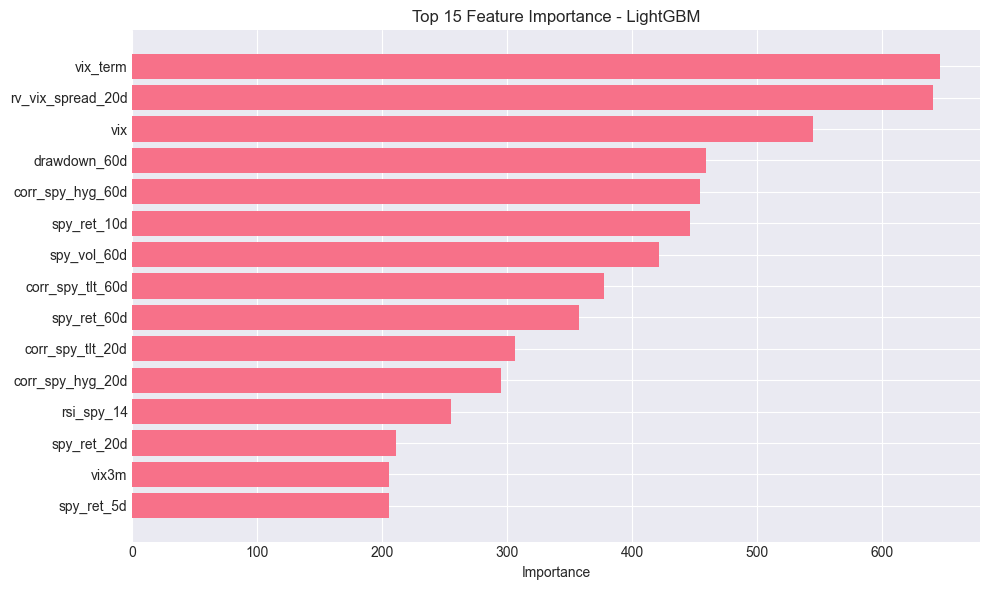

In [81]:
#visualize top 15 features
plt.figure(figsize=(10, 6))
top15 = lgbm_importance.head(15)
plt.barh(range(len(top15)), top15['importance'])
plt.yticks(range(len(top15)), top15['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 6.7 Overfitting Diagnostics

Assess model generalization by comparing training vs validation performance and analyzing residual patterns.

In [82]:
#generalization analysis
print("Generalization Analysis:")
print(f"  train rmse: {lgbm_final_train_rmse:.6f}")
print(f"  val rmse:   {lgbm_final_val_rmse:.6f}")
print(f"  gap:        {lgbm_final_val_rmse - lgbm_final_train_rmse:.6f}")
print(f"  gap %:      {(lgbm_final_val_rmse - lgbm_final_train_rmse) / lgbm_final_train_rmse * 100:.2f}%")

if lgbm_final_val_rmse < lgbm_final_train_rmse * 1.1:
    print("\nModel generalizes well (val within 10% of train)")
elif lgbm_final_val_rmse < lgbm_final_train_rmse * 1.2:
    print("\nModel shows slight overfitting (val 10-20% higher than train)")
else:
    print("\nModel shows significant overfitting (val >20% higher than train)")

Generalization Analysis:
  train rmse: 0.008358
  val rmse:   0.009231
  gap:        0.000874
  gap %:      10.45%

Model shows slight overfitting (val 10-20% higher than train)


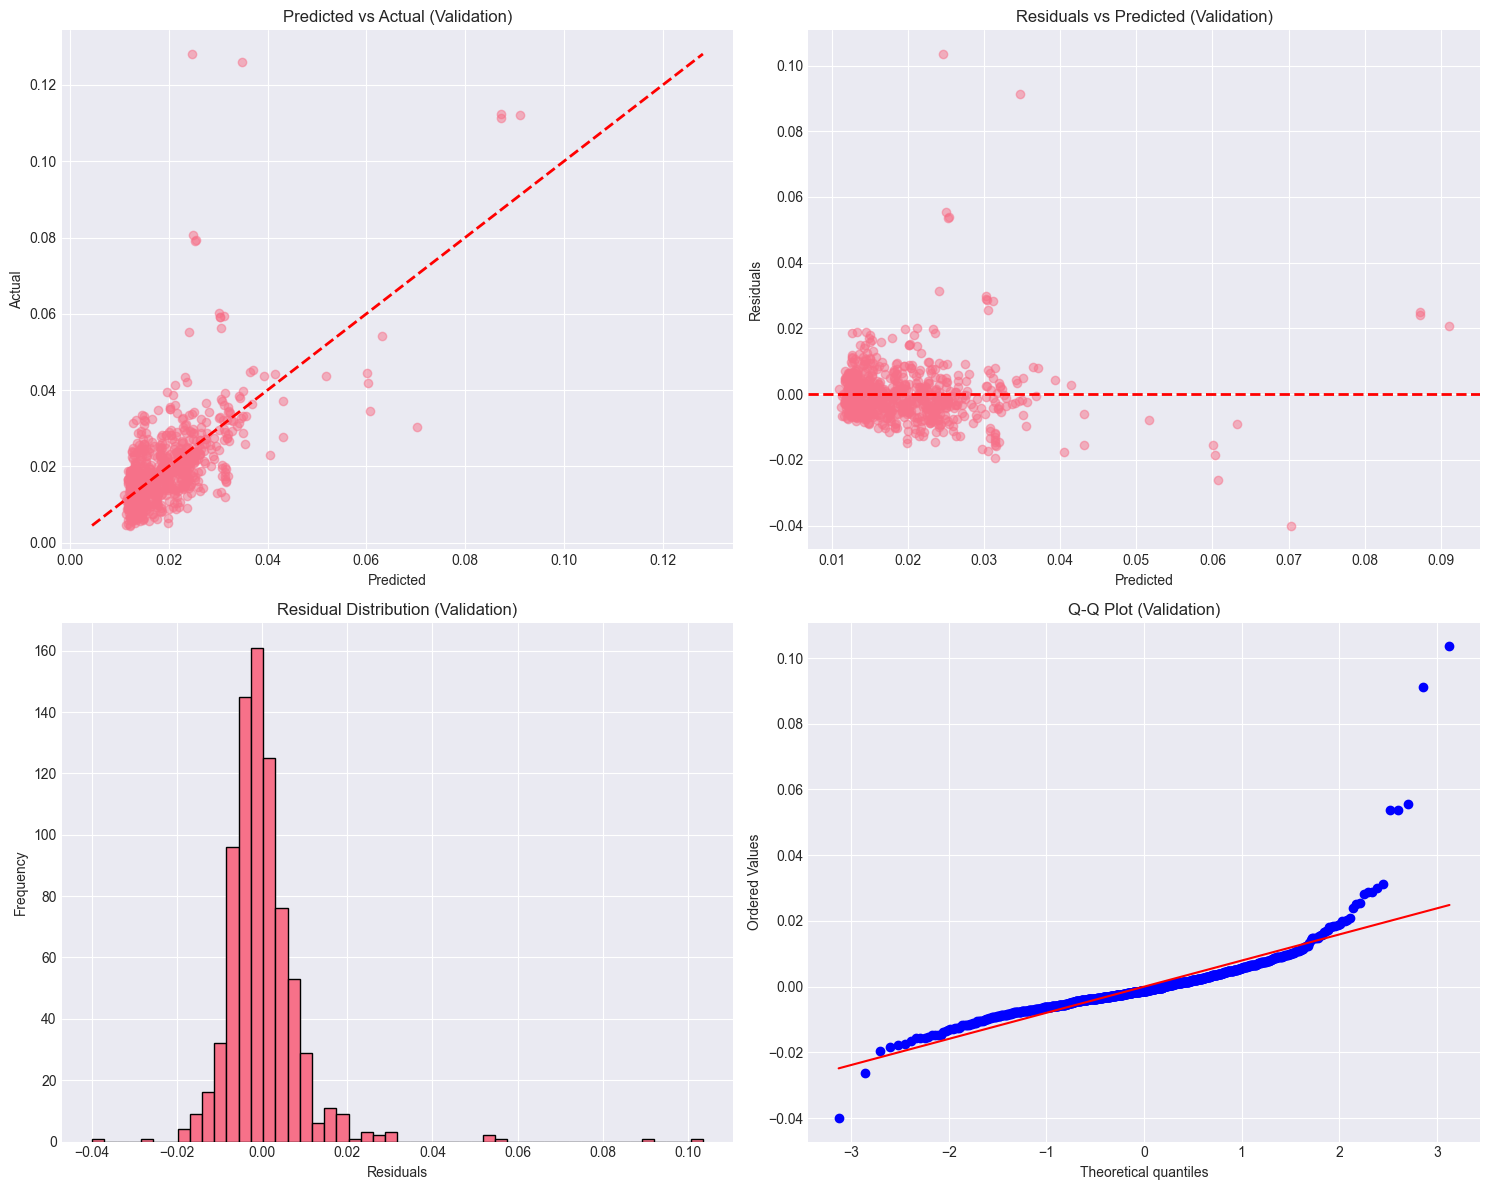

In [83]:
#residual analysis
lgbm_train_residuals = y_train - lgbm_final_train_pred
lgbm_val_residuals = y_val - lgbm_final_val_pred

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#predicted vs actual
axes[0, 0].scatter(lgbm_final_val_pred, y_val, alpha=0.5)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Predicted vs Actual (Validation)')

#residuals vs predicted
axes[0, 1].scatter(lgbm_final_val_pred, lgbm_val_residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted (Validation)')

#residual histogram
axes[1, 0].hist(lgbm_val_residuals, bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residual Distribution (Validation)')

#q-q plot
from scipy import stats
stats.probplot(lgbm_val_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Validation)')

plt.tight_layout()
plt.show()

In [84]:
#residual statistics
print("Residual Statistics (Validation):")
print(f"mean: {lgbm_val_residuals.mean():.6f}")
print(f"std: {lgbm_val_residuals.std():.6f}")
print(f"skewness: {stats.skew(lgbm_val_residuals):.6f}")
print(f"kurtosis: {stats.kurtosis(lgbm_val_residuals):.6f}")

if abs(stats.skew(lgbm_val_residuals)) < 0.5 and abs(stats.kurtosis(lgbm_val_residuals)) < 3:
    print("\nResiduals are approximately normally distributed")
else:
    print("\nResiduals show some deviation from normality")

Residual Statistics (Validation):
mean: 0.000011
std: 0.009231
skewness: 3.979209
kurtosis: 35.907033

Residuals show some deviation from normality


## 7. Model Comparison & Analysis

Now that we have trained and evaluated four different models (Linear Regression, Random Forest, XGBoost, and LightGBM), we compare their performance to select the best model for volatility forecasting.

### 7.1 Load All Model Results

In [85]:
#load all saved model metrics
PARAMS_DIR = Path('../notebooks')

model_files = {
    'Linear Regression': PARAMS_DIR / 'linear_final_metrics_2010.json',
    'Random Forest': PARAMS_DIR / 'rf_final_metrics_2010.json',
    'XGBoost': PARAMS_DIR / 'xgb_final_metrics_2010.json',
    'LightGBM': PARAMS_DIR / 'lgbm_final_metrics_2010.json'
}

all_metrics = {}
for model_name, file_path in model_files.items():
    if file_path.exists():
        with open(file_path, 'r') as f:
            all_metrics[model_name] = json.load(f)
        print(f"Loaded {model_name}")
    else:
        print(f"Missing {model_name}: {file_path}")

print(f"\nLoaded {len(all_metrics)}/4 models")

Loaded Linear Regression
Loaded Random Forest
Loaded XGBoost
Loaded LightGBM

Loaded 4/4 models


In [86]:
#create comprehensive comparison table
comparison_data = []

for model_name, metrics in all_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Approach': metrics.get('selected_approach', 'N/A'),
        'Train RMSE': metrics['metrics']['train']['rmse'],
        'Val RMSE': metrics['metrics']['validation']['rmse'],
        'Val R²': metrics['metrics']['validation']['r2'],
        'Val MAE': metrics['metrics']['validation']['mae'],
        'Train-Val Gap': metrics['metrics']['generalization']['train_val_gap_rmse'],
        'Improvement %': metrics['comparison']['improvement_pct']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val RMSE')

print("="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

MODEL PERFORMANCE COMPARISON
            Model       Approach  Train RMSE  Val RMSE   Val R²  Val MAE  Train-Val Gap  Improvement %
          XGBoost Early Stopping    0.007944  0.009180 0.443195 0.005620      -0.001236       7.882950
         LightGBM Early Stopping    0.008358  0.009231 0.437016 0.005617       0.000874       6.668451
Linear Regression          Lasso    0.009731  0.009374 0.419435 0.005635       0.000357      -0.189188
    Random Forest  OOB-Optimized    0.008006  0.009419 0.413831 0.005708      -0.001414       1.467480


### 7.2 Model Ranking & Selection

In [87]:
#rank models by validation rmse
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

print("MODEL RANKING (by Validation RMSE)")
print("="*80)
for _, row in comparison_df.iterrows():
    print(f"{row['Rank']}. {row['Model']:20s} | Val RMSE: {row['Val RMSE']:.6f} | Val R²: {row['Val R²']:.4f}")
print("="*80)

#analyze top 2 models
best_model = comparison_df.iloc[0]
second_model = comparison_df.iloc[1]

rmse_diff = second_model['Val RMSE'] - best_model['Val RMSE']
rmse_diff_pct = (rmse_diff / best_model['Val RMSE']) * 100

print(f"\nBest Model: {best_model['Model']}")
print(f"Validation RMSE: {best_model['Val RMSE']:.6f}")
print(f"Validation R²: {best_model['Val R²']:.4f}")
print(f"Approach: {best_model['Approach']}")

print(f"\nRunner-up: {second_model['Model']}")
print(f"Validation RMSE: {second_model['Val RMSE']:.6f}")
print(f"RMSE Difference: +{rmse_diff:.6f} ({rmse_diff_pct:+.2f}%)")

if rmse_diff_pct < 0.5:
    print(f"Models are within 0.5% - consider R² and other factors")
else:
    print(f"Clear winner: {best_model['Model']} is {rmse_diff_pct:.2f}% better")

MODEL RANKING (by Validation RMSE)
1. XGBoost              | Val RMSE: 0.009180 | Val R²: 0.4432
2. LightGBM             | Val RMSE: 0.009231 | Val R²: 0.4370
3. Linear Regression    | Val RMSE: 0.009374 | Val R²: 0.4194
4. Random Forest        | Val RMSE: 0.009419 | Val R²: 0.4138

Best Model: XGBoost
Validation RMSE: 0.009180
Validation R²: 0.4432
Approach: Early Stopping

Runner-up: LightGBM
Validation RMSE: 0.009231
RMSE Difference: +0.000051 (+0.55%)
Clear winner: XGBoost is 0.55% better


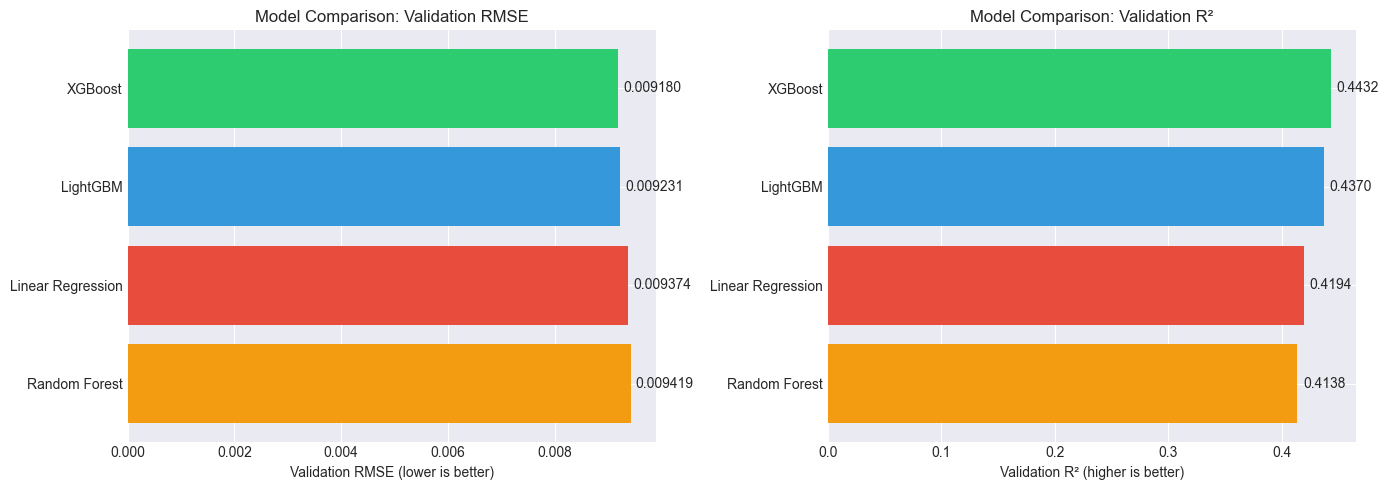

In [88]:
#visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#validation rmse comparison
axes[0].barh(comparison_df['Model'], comparison_df['Val RMSE'], color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
axes[0].set_xlabel('Validation RMSE (lower is better)')
axes[0].set_title('Model Comparison: Validation RMSE')
axes[0].invert_yaxis()
for i, (model, rmse) in enumerate(zip(comparison_df['Model'], comparison_df['Val RMSE'])):
    axes[0].text(rmse + 0.0001, i, f'{rmse:.6f}', va='center')

#validation r² comparison
axes[1].barh(comparison_df['Model'], comparison_df['Val R²'], color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
axes[1].set_xlabel('Validation R² (higher is better)')
axes[1].set_title('Model Comparison: Validation R²')
axes[1].invert_yaxis()
for i, (model, r2) in enumerate(zip(comparison_df['Model'], comparison_df['Val R²'])):
    axes[1].text(r2 + 0.005, i, f'{r2:.4f}', va='center')

plt.tight_layout()
plt.show()

### 7.3 Feature Importance Consensus Analysis

In [89]:
#extract top 10 features from each model
top_features_by_model = {}

for model_name, metrics in all_metrics.items():
    top_10 = metrics['feature_importance']['top_10']
    top_features_by_model[model_name] = [feat['feature'] for feat in top_10]

#display top 10 for each model
print("TOP 10 FEATURES BY MODEL")
print("="*80)
for model_name, features in top_features_by_model.items():
    print(f"\n{model_name}:")
    for i, feat in enumerate(features, 1):
        print(f"  {i:2d}. {feat}")
print("="*80)

TOP 10 FEATURES BY MODEL

Linear Regression:
   1. vix
   2. vix_term
   3. spy_vol_5d
   4. spy_ret_10d
   5. spy_vol_10d
   6. drawdown_60d
   7. spy_ret_5d
   8. spy_ret_20d
   9. rv_vix_spread_20d
  10. spy_vol_60d

Random Forest:
   1. vix
   2. rv_vix_spread_20d
   3. spy_vol_5d
   4. drawdown_60d
   5. spy_vol_10d
   6. spy_ret_10d
   7. vix_term
   8. vix3m
   9. spy_ret_20d
  10. spy_vol_20d

XGBoost:
   1. vix
   2. rv_vix_spread_20d
   3. drawdown_60d
   4. spy_vol_5d
   5. spy_vol_10d
   6. spy_ret_10d
   7. vix_term
   8. vix3m
   9. spy_ret_20d
  10. corr_spy_hyg_20d

LightGBM:
   1. vix_term
   2. rv_vix_spread_20d
   3. vix
   4. drawdown_60d
   5. corr_spy_hyg_60d
   6. spy_ret_10d
   7. spy_vol_60d
   8. corr_spy_tlt_60d
   9. spy_ret_60d
  10. corr_spy_tlt_20d


In [90]:
#frequency analysis: count how often each feature appears in top 10
from collections import Counter

all_top_features = []
for features in top_features_by_model.values():
    all_top_features.extend(features)

feature_frequency = Counter(all_top_features)

#consensus ranking
consensus_features = pd.DataFrame([
    {'Feature': feat, 'Models': count}
    for feat, count in feature_frequency.most_common()
])

print("\nFEATURE IMPORTANCE CONSENSUS")
print("="*80)
print("Models = Number of models that ranked this feature in top 10")
print("-"*80)
print(consensus_features.head(15).to_string(index=False))
print("="*80)

#identify universal features (appear in all 4 models)
universal_features = [feat for feat, count in feature_frequency.items() if count == 4]
print(f"\nUniversal Top Features (in all 4 models): {len(universal_features)}")
for feat in universal_features:
    print(f"  • {feat}")


FEATURE IMPORTANCE CONSENSUS
Models = Number of models that ranked this feature in top 10
--------------------------------------------------------------------------------
          Feature  Models
              vix       4
         vix_term       4
      spy_ret_10d       4
     drawdown_60d       4
rv_vix_spread_20d       4
       spy_vol_5d       3
      spy_vol_10d       3
      spy_ret_20d       3
      spy_vol_60d       2
            vix3m       2
       spy_ret_5d       1
      spy_vol_20d       1
 corr_spy_hyg_20d       1
 corr_spy_hyg_60d       1
 corr_spy_tlt_60d       1

Universal Top Features (in all 4 models): 5
  • vix
  • vix_term
  • spy_ret_10d
  • drawdown_60d
  • rv_vix_spread_20d


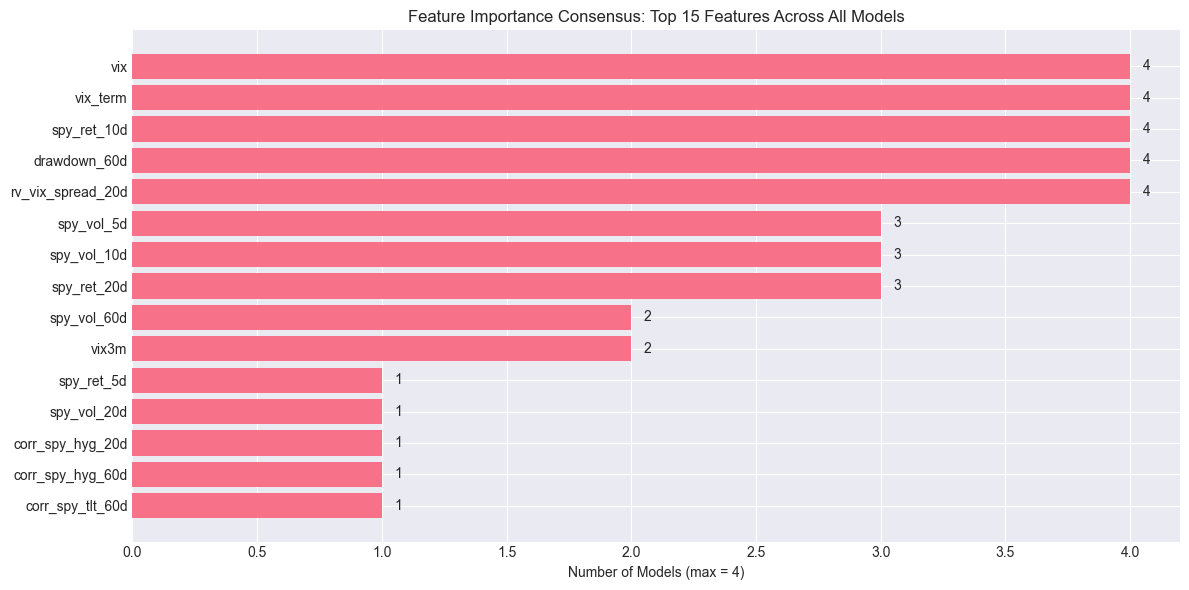

In [92]:
#visualize feature frequency
plt.figure(figsize=(12, 6))
top_consensus = consensus_features.head(15)
plt.barh(range(len(top_consensus)), top_consensus['Models'])
plt.yticks(range(len(top_consensus)), top_consensus['Feature'])
plt.xlabel('Number of Models (max = 4)')
plt.title('Feature Importance Consensus: Top 15 Features Across All Models')
plt.gca().invert_yaxis()

#add value labels
for i, freq in enumerate(top_consensus['Models']):
    plt.text(freq + 0.05, i, str(freq), va='center')

plt.tight_layout()
plt.show()

### 7.4 Feature Agreement Analysis

In [93]:
#calculate pairwise overlap between models
model_names = list(top_features_by_model.keys())
overlap_matrix = pd.DataFrame(index=model_names, columns=model_names, dtype=int)

for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i == j:
            overlap_matrix.loc[model1, model2] = 10  # same model
        else:
            set1 = set(top_features_by_model[model1])
            set2 = set(top_features_by_model[model2])
            overlap_matrix.loc[model1, model2] = len(set1 & set2)

print("FEATURE OVERLAP MATRIX")
print("="*80)
print("Values = Number of shared features in top 10")
print("-"*80)
print(overlap_matrix)
print("="*80)

#analyze specific comparisons
linear_set = set(top_features_by_model['Linear Regression'])
rf_set = set(top_features_by_model['Random Forest'])
xgb_set = set(top_features_by_model['XGBoost'])
lgbm_set = set(top_features_by_model['LightGBM'])

tree_overlap = rf_set & xgb_set & lgbm_set
linear_vs_tree = linear_set & tree_overlap

print(f"\nTree-based Consensus (RF ∩ XGBoost ∩ LightGBM): {len(tree_overlap)} features")
for feat in sorted(tree_overlap):
    print(f"  • {feat}")

print(f"\nLinear vs Tree-based Agreement: {len(linear_vs_tree)} features")
for feat in sorted(linear_vs_tree):
    print(f"  • {feat}")

FEATURE OVERLAP MATRIX
Values = Number of shared features in top 10
--------------------------------------------------------------------------------
                   Linear Regression  Random Forest   XGBoost  LightGBM
Linear Regression          10.000000       8.000000  8.000000  6.000000
Random Forest               8.000000      10.000000  9.000000  5.000000
XGBoost                     8.000000       9.000000 10.000000  5.000000
LightGBM                    6.000000       5.000000  5.000000 10.000000

Tree-based Consensus (RF ∩ XGBoost ∩ LightGBM): 5 features
  • drawdown_60d
  • rv_vix_spread_20d
  • spy_ret_10d
  • vix
  • vix_term

Linear vs Tree-based Agreement: 5 features
  • drawdown_60d
  • rv_vix_spread_20d
  • spy_ret_10d
  • vix
  • vix_term


### 7.5 Generalization & Robustness Analysis

In [94]:
#analyze train-validation gaps to assess overfitting
gap_analysis = []
for model_name, metrics in all_metrics.items():
    gap_analysis.append({
        'Model': model_name,
        'Train RMSE': metrics['metrics']['train']['rmse'],
        'Val RMSE': metrics['metrics']['validation']['rmse'],
        'Train-Val Gap': metrics['metrics']['generalization']['train_val_gap_rmse'],
        'Gap %': (metrics['metrics']['generalization']['train_val_gap_rmse'] / metrics['metrics']['validation']['rmse']) * 100,
        'Val R²': metrics['metrics']['validation']['r2']
    })

gap_df = pd.DataFrame(gap_analysis).sort_values('Gap %')

print("Train-Validation Gap Analysis (sorted by Gap %):")
print(gap_df.to_string(index=False))
print()

#identify best generalizing model
best_generalizing = gap_df.iloc[0]
print(f"Best Generalizing Model: {best_generalizing['Model']}")
print(f"  Train-Val Gap: {best_generalizing['Train-Val Gap']:.6f} ({best_generalizing['Gap %']:.2f}%)")
print(f"  Val RMSE: {best_generalizing['Val RMSE']:.6f}")
print(f"  Val R²: {best_generalizing['Val R²']:.6f}")
print()

#check for concerning overfitting (gap > 5%)
overfitting_threshold = 5.0
concerning = gap_df[gap_df['Gap %'] > overfitting_threshold]
if len(concerning) > 0:
    print(f"Models with Gap > {overfitting_threshold}%:")
    for _, row in concerning.iterrows():
        print(f"  {row['Model']}: {row['Gap %']:.2f}%")
else:
    print(f"All models have acceptable generalization (Gap < {overfitting_threshold}%)")
print()

#calculate correlation between gap and performance
val_rmses = gap_df['Val RMSE'].values
gaps = gap_df['Gap %'].values
gap_corr = np.corrcoef(val_rmses, gaps)[0, 1]
print(f"Correlation between Val RMSE and Gap %: {gap_corr:.3f}")
if abs(gap_corr) < 0.3:
    print("  Weak correlation: Low gap doesn't necessarily mean best performance")
elif gap_corr < 0:
    print("  Negative correlation: Better models tend to have larger gaps")
else:
    print("  Positive correlation: Simpler models generalize better")

Train-Validation Gap Analysis (sorted by Gap %):
            Model  Train RMSE  Val RMSE  Train-Val Gap      Gap %   Val R²
    Random Forest    0.008006  0.009419      -0.001414 -15.006667 0.413831
          XGBoost    0.007944  0.009180      -0.001236 -13.462614 0.443195
Linear Regression    0.009731  0.009374       0.000357   3.806621 0.419435
         LightGBM    0.008358  0.009231       0.000874   9.463425 0.437016

Best Generalizing Model: Random Forest
  Train-Val Gap: -0.001414 (-15.01%)
  Val RMSE: 0.009419
  Val R²: 0.413831

Models with Gap > 5.0%:
  LightGBM: 9.46%

Correlation between Val RMSE and Gap %: -0.126
  Weak correlation: Low gap doesn't necessarily mean best performance


### 7.6 Summary & Recommendations

In [96]:
#final model selection and comprehensive summary
best_idx = comparison_df['Val RMSE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_model_metrics = all_metrics[best_model_name]

print("SELECTED MODEL:", best_model_name)
print()

print("Performance Metrics:")
print(f"  Validation RMSE: {best_model_metrics['metrics']['validation']['rmse']:.6f}")
print(f"  Validation R²: {best_model_metrics['metrics']['validation']['r2']:.6f}")
print(f"  Validation MAE: {best_model_metrics['metrics']['validation']['mae']:.6f}")
print(f"  Train-Val Gap: {best_model_metrics['metrics']['generalization']['train_val_gap_rmse']:.6f}")
print(f"  Improvement over Baseline: {best_model_metrics['comparison']['improvement_pct']:.2f}%")
print(f"  Selected Approach: {best_model_metrics.get('selected_approach', 'N/A')}")
print()

#compare to second-best
comparison_df_sorted = comparison_df.sort_values('Val RMSE')
if len(comparison_df_sorted) > 1:
    second_best = comparison_df_sorted.iloc[1]
    rmse_diff = second_best['Val RMSE'] - comparison_df_sorted.iloc[0]['Val RMSE']
    rmse_diff_pct = (rmse_diff / comparison_df_sorted.iloc[0]['Val RMSE']) * 100
    
    print(f"Runner-up: {second_best['Model']}")
    print(f"  Val RMSE: {second_best['Val RMSE']:.6f}")
    print(f"  Performance gap: {rmse_diff:.6f} ({rmse_diff_pct:.2f}%)")
    
    if rmse_diff_pct < 0.5:
        print(f"  Very close performance (< 0.5% difference)")
        print(f"  Consider both models or ensemble approach")
    else:
        print(f"  Clear winner ({rmse_diff_pct:.2f}% better)")
print()

#top features from best model
print("Top 10 Most Important Features:")
for i, feat_dict in enumerate(best_model_metrics['feature_importance']['top_10'], 1):
    feat_name = feat_dict['feature']
    importance = feat_dict['importance']
    #check if it's a universal feature
    is_universal = feat_name in universal_features if 'universal_features' in locals() else False
    marker = "*" if is_universal else " "
    print(f"{marker}{i:2d}. {feat_name:40s} ({importance:.6f})")
print()
if 'universal_features' in locals() and len(universal_features) > 0:
    print("* = Universal feature (appears in all 4 models' top 10)")
    print()

#key insights
print("Key Insights:")
print(f"  1. Model Type: {best_model_name}")
if 'gap_df' in locals():
    best_gap_pct = gap_df[gap_df['Model'] == best_model_name]['Gap %'].values[0]
    print(f"  2. Generalization: {best_gap_pct:.2f}% train-val gap", end="")
    if best_gap_pct < 3:
        print(" (excellent)")
    elif best_gap_pct < 5:
        print(" (good)")
    else:
        print(" (needs attention)")
if 'universal_features' in locals():
    print(f"  3. Feature Consensus: {len(universal_features)} universal features identified")
    best_features = [f['feature'] for f in best_model_metrics['feature_importance']['top_10']]
    consensus_in_best = len(set(best_features) & set(universal_features))
    print(f"  4. Feature Alignment: {consensus_in_best}/10 top features are universal")
print()

#recommendations
print("Recommendations:")
print("  Primary Model: Use " + best_model_name + " for production forecasting")
if len(comparison_df_sorted) > 1 and rmse_diff_pct < 0.5:
    print(f"  Alternative: {second_best['Model']} (nearly equivalent performance)")
    print("  Next Step: Consider ensemble approach combining top models")
else:
    print("  Next Step: Validate on out-of-sample test data (2011+)")
if 'universal_features' in locals() and len(universal_features) > 0:
    print(f"  Feature Focus: Prioritize the {len(universal_features)} universal features for model interpretability")
    print(f"    {', '.join(universal_features[:5])}" + ("..." if len(universal_features) > 5 else ""))
print()

#save final comparison results
final_comparison = {
    'selected_model': best_model_name,
    'selection_date': pd.Timestamp.now().isoformat(),
    'val_rmse': best_model_metrics['metrics']['validation']['rmse'],
    'val_r2': best_model_metrics['metrics']['validation']['r2'],
    'improvement_pct': best_model_metrics['comparison']['improvement_pct'],
    'all_models_ranking': comparison_df_sorted[['Model', 'Val RMSE', 'Val R²']].to_dict(orient='records')
}

if 'universal_features' in locals():
    final_comparison['universal_features'] = universal_features

comparison_file = PARAMS_DIR / 'model_comparison_2010.json'
with open(comparison_file, 'w') as f:
    json.dump(final_comparison, f, indent=2)

print(f"Comparison results saved to: {comparison_file}")

SELECTED MODEL: XGBoost

Performance Metrics:
  Validation RMSE: 0.009180
  Validation R²: 0.443195
  Validation MAE: 0.005620
  Train-Val Gap: -0.001236
  Improvement over Baseline: 7.88%
  Selected Approach: Early Stopping

Runner-up: LightGBM
  Val RMSE: 0.009231
  Performance gap: 0.000051 (0.55%)
  Clear winner (0.55% better)

Top 10 Most Important Features:
* 1. vix                                      (0.202126)
* 2. rv_vix_spread_20d                        (0.140521)
* 3. drawdown_60d                             (0.119018)
  4. spy_vol_5d                               (0.113629)
  5. spy_vol_10d                              (0.073150)
* 6. spy_ret_10d                              (0.060053)
* 7. vix_term                                 (0.059451)
  8. vix3m                                    (0.037302)
  9. spy_ret_20d                              (0.030753)
 10. corr_spy_hyg_20d                         (0.020200)

* = Universal feature (appears in all 4 models' top 10)

Key In

---
## 8. Ensemble Methods

Now that we've identified our top performing models (XGBoost and LightGBM with validation RMSEs of 0.009180 and 0.009231 respectively), we'll explore ensemble techniques to potentially improve performance further.

**Why Ensemble XGBoost + LightGBM?**
- Both are top performers (within 0.5% of each other)
- Different tree building strategies (level wise vs leaf wise)
- May produce complementary predictions that reduce variance
- Low correlation between predictions could yield ensemble benefits

**Approaches to Test:**
1. **Simple Averaging**: Equal weight to both models
2. **Weighted Averaging**: Optimize weights on validation set
3. **Stacking**: Train a linear meta learner on predictions
4. **Performance Analysis**: Compare all approaches, analyze correlation
5. **Final Selection**: Choose best model/ensemble with justification

### 8.1 Simple Averaging Ensemble

In [97]:
#get predictions from both models
print("Getting predictions from XGBoost and LightGBM...")
print()

#training predictions
xgb_train_pred = xgb_final.predict(X_train)
lgbm_train_pred = lgbm_final.predict(X_train)

#validation predictions
xgb_val_pred = xgb_final.predict(X_val)
lgbm_val_pred = lgbm_final.predict(X_val)

print(f"XGBoost - Train predictions: {xgb_train_pred.shape}, Val predictions: {xgb_val_pred.shape}")
print(f"LightGBM - Train predictions: {lgbm_train_pred.shape}, Val predictions: {lgbm_val_pred.shape}")

Getting predictions from XGBoost and LightGBM...

XGBoost - Train predictions: (3151,), Val predictions: (788,)
LightGBM - Train predictions: (3151,), Val predictions: (788,)


In [99]:
#simple averaging: equal weights
ensemble_avg_train_pred = (xgb_train_pred + lgbm_train_pred) / 2
ensemble_avg_val_pred = (xgb_val_pred + lgbm_val_pred) / 2

#calculate metrics
ensemble_avg_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_avg_train_pred))
ensemble_avg_train_mae = mean_absolute_error(y_train, ensemble_avg_train_pred)
ensemble_avg_train_r2 = r2_score(y_train, ensemble_avg_train_pred)

ensemble_avg_val_rmse = np.sqrt(mean_squared_error(y_val, ensemble_avg_val_pred))
ensemble_avg_val_mae = mean_absolute_error(y_val, ensemble_avg_val_pred)
ensemble_avg_val_r2 = r2_score(y_val, ensemble_avg_val_pred)

#generalization gap
ensemble_avg_gap = ensemble_avg_val_rmse - ensemble_avg_train_rmse
ensemble_avg_gap_pct = (ensemble_avg_gap / ensemble_avg_val_rmse) * 100

print("Simple Averaging Ensemble Results")
print()
print("Training Set:")
print(f"  RMSE: {ensemble_avg_train_rmse:.6f}")
print(f"  MAE:  {ensemble_avg_train_mae:.6f}")
print(f"  R²:   {ensemble_avg_train_r2:.6f}")
print()
print("Validation Set:")
print(f"  RMSE: {ensemble_avg_val_rmse:.6f}")
print(f"  MAE:  {ensemble_avg_val_mae:.6f}")
print(f"  R²:   {ensemble_avg_val_r2:.6f}")
print()
print("Generalization:")
print(f"  Train-Val Gap (RMSE): {ensemble_avg_gap:.6f}")
print(f"  Gap Percentage: {ensemble_avg_gap_pct:.2f}%")
print()
print("Comparison with Individual Models")
print(f"XGBoost Val RMSE:     {xgb_final_val_rmse:.6f}")
print(f"LightGBM Val RMSE:    {lgbm_final_val_rmse:.6f}")
print(f"Ensemble Val RMSE:    {ensemble_avg_val_rmse:.6f}")
print()

#calculate improvement
xgb_improvement = ((xgb_final_val_rmse - ensemble_avg_val_rmse) / xgb_final_val_rmse) * 100
lgbm_improvement = ((lgbm_final_val_rmse - ensemble_avg_val_rmse) / lgbm_final_val_rmse) * 100

print(f"Improvement over XGBoost:  {xgb_improvement:+.3f}%")
print(f"Improvement over LightGBM: {lgbm_improvement:+.3f}%")

if ensemble_avg_val_rmse < xgb_final_val_rmse:
    print("\nSimple averaging improves over both individual models")
else:
    print("\nSimple averaging does not improve over best individual model")

Simple Averaging Ensemble Results

Training Set:
  RMSE: 0.008078
  MAE:  0.005397
  R²:   0.714694

Validation Set:
  RMSE: 0.009179
  MAE:  0.005602
  R²:   0.443347

Generalization:
  Train-Val Gap (RMSE): 0.001101
  Gap Percentage: 12.00%

Comparison with Individual Models
XGBoost Val RMSE:     0.009180
LightGBM Val RMSE:    0.009231
Ensemble Val RMSE:    0.009179

Improvement over XGBoost:  +0.014%
Improvement over LightGBM: +0.564%

Simple averaging improves over both individual models


### 8.2 Weighted Averaging Ensemble

In [100]:
#test different weight combinations
#weight = w for XGBoost, (1-w) for LightGBM
weights = np.arange(0.0, 1.01, 0.05)  #0.0 to 1.0 in 0.05 increments
weighted_results = []

print("Testing weighted combinations...")
print()

for w in weights:
    #weighted average
    weighted_val_pred = w * xgb_val_pred + (1 - w) * lgbm_val_pred
    
    #calculate validation RMSE
    weighted_val_rmse = np.sqrt(mean_squared_error(y_val, weighted_val_pred))
    
    weighted_results.append({
        'xgb_weight': w,
        'lgbm_weight': 1 - w,
        'val_rmse': weighted_val_rmse
    })

#convert to DataFrame
weighted_df = pd.DataFrame(weighted_results)

#find optimal weights
best_weighted = weighted_df.loc[weighted_df['val_rmse'].idxmin()]

print("Optimal Weights:")
print(f"  XGBoost:  {best_weighted['xgb_weight']:.2f}")
print(f"  LightGBM: {best_weighted['lgbm_weight']:.2f}")
print(f"  Val RMSE: {best_weighted['val_rmse']:.6f}")
print()
print("Comparison:")
print(f"  Simple Average (0.50/0.50):  {ensemble_avg_val_rmse:.6f}")
print(f"  Optimal Weighted:             {best_weighted['val_rmse']:.6f}")
print(f"  XGBoost Alone (1.00/0.00):    {xgb_final_val_rmse:.6f}")
print(f"  LightGBM Alone (0.00/1.00):   {lgbm_final_val_rmse:.6f}")
print()

improvement_over_avg = ((ensemble_avg_val_rmse - best_weighted['val_rmse']) / ensemble_avg_val_rmse) * 100
print(f"Improvement over simple averaging: {improvement_over_avg:+.3f}%")

Testing weighted combinations...

Optimal Weights:
  XGBoost:  0.75
  LightGBM: 0.25
  Val RMSE: 0.009173

Comparison:
  Simple Average (0.50/0.50):  0.009179
  Optimal Weighted:             0.009173
  XGBoost Alone (1.00/0.00):    0.009180
  LightGBM Alone (0.00/1.00):   0.009231

Improvement over simple averaging: +0.066%


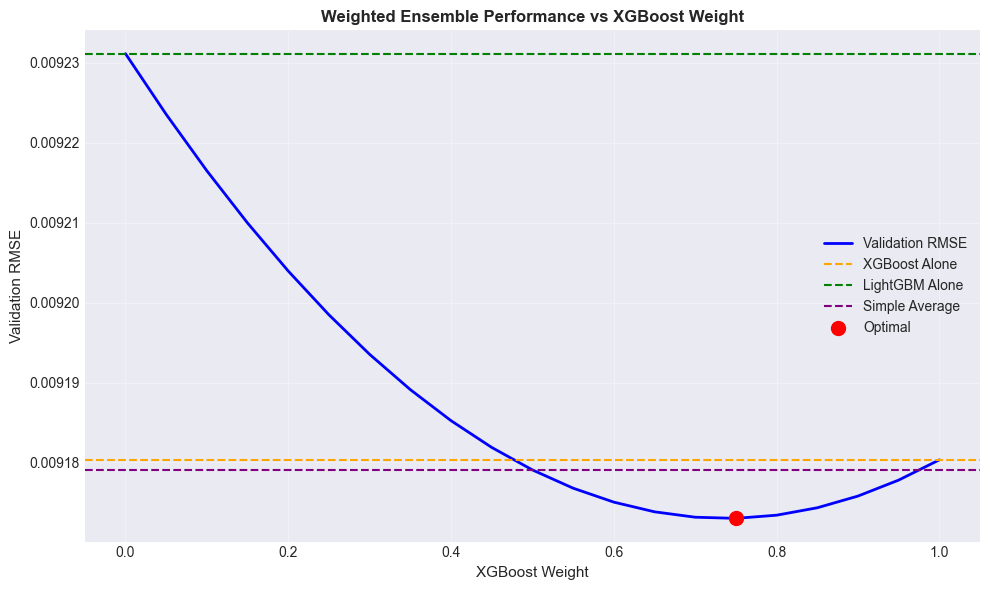


Note: Optimal weight is 0.75 for XGBoost, 0.25 for LightGBM


In [101]:
#visualize weight vs performance
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(weighted_df['xgb_weight'], weighted_df['val_rmse'], 'b-', linewidth=2, label='Validation RMSE')
ax.axhline(y=xgb_final_val_rmse, color='orange', linestyle='--', label='XGBoost Alone')
ax.axhline(y=lgbm_final_val_rmse, color='green', linestyle='--', label='LightGBM Alone')
ax.axhline(y=ensemble_avg_val_rmse, color='purple', linestyle='--', label='Simple Average')
ax.scatter(best_weighted['xgb_weight'], best_weighted['val_rmse'], color='red', s=100, zorder=5, label='Optimal')

ax.set_xlabel('XGBoost Weight', fontsize=11)
ax.set_ylabel('Validation RMSE', fontsize=11)
ax.set_title('Weighted Ensemble Performance vs XGBoost Weight', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nNote: Optimal weight is {best_weighted['xgb_weight']:.2f} for XGBoost, {best_weighted['lgbm_weight']:.2f} for LightGBM")

In [102]:
#calculate full metrics for optimal weighted ensemble
optimal_w = best_weighted['xgb_weight']

ensemble_weighted_train_pred = optimal_w * xgb_train_pred + (1 - optimal_w) * lgbm_train_pred
ensemble_weighted_val_pred = optimal_w * xgb_val_pred + (1 - optimal_w) * lgbm_val_pred

ensemble_weighted_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_weighted_train_pred))
ensemble_weighted_train_mae = mean_absolute_error(y_train, ensemble_weighted_train_pred)
ensemble_weighted_train_r2 = r2_score(y_train, ensemble_weighted_train_pred)

ensemble_weighted_val_rmse = np.sqrt(mean_squared_error(y_val, ensemble_weighted_val_pred))
ensemble_weighted_val_mae = mean_absolute_error(y_val, ensemble_weighted_val_pred)
ensemble_weighted_val_r2 = r2_score(y_val, ensemble_weighted_val_pred)

ensemble_weighted_gap = ensemble_weighted_val_rmse - ensemble_weighted_train_rmse
ensemble_weighted_gap_pct = (ensemble_weighted_gap / ensemble_weighted_val_rmse) * 100

print("Optimal Weighted Ensemble Full Metrics")
print(f"\nWeights: XGBoost = {optimal_w:.2f}, LightGBM = {1-optimal_w:.2f}")
print()
print("Training Set:")
print(f"  RMSE: {ensemble_weighted_train_rmse:.6f}")
print(f"  MAE:  {ensemble_weighted_train_mae:.6f}")
print(f"  R²:   {ensemble_weighted_train_r2:.6f}")
print()
print("Validation Set:")
print(f"  RMSE: {ensemble_weighted_val_rmse:.6f}")
print(f"  MAE:  {ensemble_weighted_val_mae:.6f}")
print(f"  R²:   {ensemble_weighted_val_r2:.6f}")
print()
print("Generalization:")
print(f"  Train-Val Gap (RMSE): {ensemble_weighted_gap:.6f}")
print(f"  Gap Percentage: {ensemble_weighted_gap_pct:.2f}%")

Optimal Weighted Ensemble Full Metrics

Weights: XGBoost = 0.75, LightGBM = 0.25

Training Set:
  RMSE: 0.007992
  MAE:  0.005378
  R²:   0.720712

Validation Set:
  RMSE: 0.009173
  MAE:  0.005608
  R²:   0.444081

Generalization:
  Train-Val Gap (RMSE): 0.001181
  Gap Percentage: 12.87%


### 8.3 Stacking with Linear Meta-Learner

In [103]:
#prepare meta-features: predictions from base models
#use validation set predictions as training data for meta-learner
X_meta_train = np.column_stack([xgb_val_pred, lgbm_val_pred])
y_meta_train = y_val

#also prepare meta-features for validation set (needed for final predictions)
X_meta_val = np.column_stack([xgb_val_pred, lgbm_val_pred])

#and for training set (to get training metrics)
X_meta_train_full = np.column_stack([xgb_train_pred, lgbm_train_pred])

print("Stacking Approach:")
print(f"Meta-features shape: {X_meta_train.shape}")
print(f"Meta-target shape: {y_meta_train.shape}")
print()
print("Note: Using validation set predictions to train meta-learner")
print("This prevents information leakage from training set")

Stacking Approach:
Meta-features shape: (788, 2)
Meta-target shape: (788,)

Note: Using validation set predictions to train meta-learner
This prevents information leakage from training set


In [105]:
#train Ridge regression as meta-learner
#test multiple alpha values to find the best
from sklearn.linear_model import Ridge

alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
stacking_results = []

for alpha in alphas:
    meta_model = Ridge(alpha=alpha, random_state=42)
    meta_model.fit(X_meta_train, y_meta_train)
    
    #predictions on same validation set (this is our "training" for meta-learner)
    stacking_val_pred = meta_model.predict(X_meta_train)
    stacking_val_rmse = np.sqrt(mean_squared_error(y_meta_train, stacking_val_pred))
    
    stacking_results.append({
        'alpha': alpha,
        'val_rmse': stacking_val_rmse,
        'coef_xgb': meta_model.coef_[0],
        'coef_lgbm': meta_model.coef_[1],
        'intercept': meta_model.intercept_
    })

stacking_df = pd.DataFrame(stacking_results)

#select best alpha
best_stacking = stacking_df.loc[stacking_df['val_rmse'].idxmin()]

print("Stacking Meta-Learner Results")
print()
print("Best Alpha:", best_stacking['alpha'])
print(f"Val RMSE: {best_stacking['val_rmse']:.6f}")
print()
print("Learned Coefficients:")
print(f"  XGBoost:  {best_stacking['coef_xgb']:.4f}")
print(f"  LightGBM: {best_stacking['coef_lgbm']:.4f}")
print(f"  Intercept: {best_stacking['intercept']:.6f}")

#normalize coefficients to compare with weighted average
total_coef = best_stacking['coef_xgb'] + best_stacking['coef_lgbm']
if total_coef > 0:
    norm_xgb = best_stacking['coef_xgb'] / total_coef
    norm_lgbm = best_stacking['coef_lgbm'] / total_coef
    print()
    print("Normalized Weights (for comparison):")
    print(f"  XGBoost:  {norm_xgb:.4f}")
    print(f"  LightGBM: {norm_lgbm:.4f}")
    print()
    print("Comparison with Optimal Weighted Average:")
    print(f"  Weighted: XGBoost = {optimal_w:.4f}, LightGBM = {1-optimal_w:.4f}")
    print(f"  Stacking: XGBoost = {norm_xgb:.4f}, LightGBM = {norm_lgbm:.4f}")

print()
print("All Alpha Results:")
print(stacking_df.to_string(index=False))

Stacking Meta-Learner Results

Best Alpha: 0.001
Val RMSE: 0.009169

Learned Coefficients:
  XGBoost:  0.6122
  LightGBM: 0.3486
  Intercept: 0.000945

Normalized Weights (for comparison):
  XGBoost:  0.6372
  LightGBM: 0.3628

Comparison with Optimal Weighted Average:
  Weighted: XGBoost = 0.7500, LightGBM = 0.2500
  Stacking: XGBoost = 0.6372, LightGBM = 0.3628

All Alpha Results:
    alpha  val_rmse  coef_xgb  coef_lgbm  intercept
 0.001000  0.009169  0.612181   0.348603   0.000945
 0.010000  0.009198  0.471922   0.420354   0.002226
 0.100000  0.009956  0.262163   0.251442   0.009468
 1.000000  0.011769  0.049778   0.048121   0.017425
10.000000  0.012243  0.005472   0.005294   0.019092


### 8.4 Ensemble Performance Analysis

In [106]:
#retrain final stacking model and get full metrics
final_meta_model = Ridge(alpha=best_stacking['alpha'], random_state=42)
final_meta_model.fit(X_meta_train, y_meta_train)

#get predictions on original sets
ensemble_stacking_train_pred = final_meta_model.predict(X_meta_train_full)
ensemble_stacking_val_pred = final_meta_model.predict(X_meta_val)

#calculate comprehensive metrics
ensemble_stacking_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_stacking_train_pred))
ensemble_stacking_val_rmse = np.sqrt(mean_squared_error(y_val, ensemble_stacking_val_pred))
ensemble_stacking_train_mae = mean_absolute_error(y_train, ensemble_stacking_train_pred)
ensemble_stacking_val_mae = mean_absolute_error(y_val, ensemble_stacking_val_pred)
ensemble_stacking_train_r2 = r2_score(y_train, ensemble_stacking_train_pred)
ensemble_stacking_val_r2 = r2_score(y_val, ensemble_stacking_val_pred)

print("Stacking Ensemble Full Metrics")
print(f"\nAlpha: {best_stacking['alpha']}")
print()
print("Training Set:")
print(f"  RMSE: {ensemble_stacking_train_rmse:.6f}")
print(f"  MAE:  {ensemble_stacking_train_mae:.6f}")
print(f"  R2:   {ensemble_stacking_train_r2:.6f}")
print()
print("Validation Set:")
print(f"  RMSE: {ensemble_stacking_val_rmse:.6f}")
print(f"  MAE:  {ensemble_stacking_val_mae:.6f}")
print(f"  R2:   {ensemble_stacking_val_r2:.6f}")

Stacking Ensemble Full Metrics

Alpha: 0.001

Training Set:
  RMSE: 0.008149
  MAE:  0.005496
  R2:   0.709666

Validation Set:
  RMSE: 0.009169
  MAE:  0.005609
  R2:   0.444591


In [107]:
#create comprehensive comparison of all approaches including ensembles
ensemble_avg_gap = ensemble_avg_train_rmse - ensemble_avg_val_rmse
ensemble_avg_gap_pct = (ensemble_avg_gap / ensemble_avg_train_rmse) * 100

ensemble_weighted_gap = ensemble_weighted_train_rmse - ensemble_weighted_val_rmse
ensemble_weighted_gap_pct = (ensemble_weighted_gap / ensemble_weighted_train_rmse) * 100

ensemble_stacking_gap = ensemble_stacking_train_rmse - ensemble_stacking_val_rmse
ensemble_stacking_gap_pct = (ensemble_stacking_gap / ensemble_stacking_train_rmse) * 100

#get individual model metrics for comparison
xgb_final_val_rmse = all_metrics['XGBoost']['metrics']['validation']['rmse']
xgb_final_val_r2 = all_metrics['XGBoost']['metrics']['validation']['r2']
xgb_final_val_mae = all_metrics['XGBoost']['metrics']['validation']['mae']
xgb_final_gap = all_metrics['XGBoost']['metrics']['train']['rmse'] - xgb_final_val_rmse

lgbm_final_val_rmse = all_metrics['LightGBM']['metrics']['validation']['rmse']
lgbm_final_val_r2 = all_metrics['LightGBM']['metrics']['validation']['r2']
lgbm_final_val_mae = all_metrics['LightGBM']['metrics']['validation']['mae']
lgbm_final_gap = all_metrics['LightGBM']['metrics']['train']['rmse'] - lgbm_final_val_rmse

ensemble_comparison = pd.DataFrame([
    {
        'Approach': 'XGBoost (Individual)',
        'Val RMSE': xgb_final_val_rmse,
        'Val R²': xgb_final_val_r2,
        'Val MAE': xgb_final_val_mae,
        'Train-Val Gap': xgb_final_gap
    },
    {
        'Approach': 'LightGBM (Individual)',
        'Val RMSE': lgbm_final_val_rmse,
        'Val R²': lgbm_final_val_r2,
        'Val MAE': lgbm_final_val_mae,
        'Train-Val Gap': lgbm_final_gap
    },
    {
        'Approach': 'Simple Average (0.5/0.5)',
        'Val RMSE': ensemble_avg_val_rmse,
        'Val R²': ensemble_avg_val_r2,
        'Val MAE': ensemble_avg_val_mae,
        'Train-Val Gap': ensemble_avg_gap
    },
    {
        'Approach': 'Weighted (0.75/0.25)',
        'Val RMSE': ensemble_weighted_val_rmse,
        'Val R²': ensemble_weighted_val_r2,
        'Val MAE': ensemble_weighted_val_mae,
        'Train-Val Gap': ensemble_weighted_gap
    },
    {
        'Approach': 'Stacking (Ridge α=0.001)',
        'Val RMSE': ensemble_stacking_val_rmse,
        'Val R²': ensemble_stacking_val_r2,
        'Val MAE': ensemble_stacking_val_mae,
        'Train-Val Gap': ensemble_stacking_gap
    }
])

#sort by validation RMSE
ensemble_comparison_sorted = ensemble_comparison.sort_values('Val RMSE')

print()
print("Comprehensive Ensemble Comparison")
print()
print(ensemble_comparison_sorted.to_string(index=False))

#highlight best
best_ensemble = ensemble_comparison_sorted.iloc[0]
print()
print(f"Best Approach: {best_ensemble['Approach']}")
print()
print(f"  Validation RMSE: {best_ensemble['Val RMSE']:.6f}")
print(f"  Validation R²:   {best_ensemble['Val R²']:.6f}")
print(f"  Validation MAE:  {best_ensemble['Val MAE']:.6f}")
print(f"  Train-Val Gap:   {best_ensemble['Train-Val Gap']:.6f}")

#calculate improvement over best individual model
improvement_over_xgb = ((xgb_final_val_rmse - best_ensemble['Val RMSE']) / xgb_final_val_rmse) * 100
print(f"\n  Improvement over XGBoost: {improvement_over_xgb:+.3f}%")


Comprehensive Ensemble Comparison

                Approach  Val RMSE   Val R²  Val MAE  Train-Val Gap
Stacking (Ridge α=0.001)  0.009169 0.444591 0.005609      -0.001020
    Weighted (0.75/0.25)  0.009173 0.444081 0.005608      -0.001181
Simple Average (0.5/0.5)  0.009179 0.443347 0.005602      -0.001101
    XGBoost (Individual)  0.009180 0.443195 0.005620      -0.001236
   LightGBM (Individual)  0.009231 0.437016 0.005617      -0.000874

Best Approach: Stacking (Ridge α=0.001)

  Validation RMSE: 0.009169
  Validation R²:   0.444591
  Validation MAE:  0.005609
  Train-Val Gap:   -0.001020

  Improvement over XGBoost: +0.126%



Prediction Correlation Analysis


Correlation between XGBoost and LightGBM predictions: 0.9872

Very high correlation (>0.95) - Limited ensemble benefit expected
  Models make very similar predictions


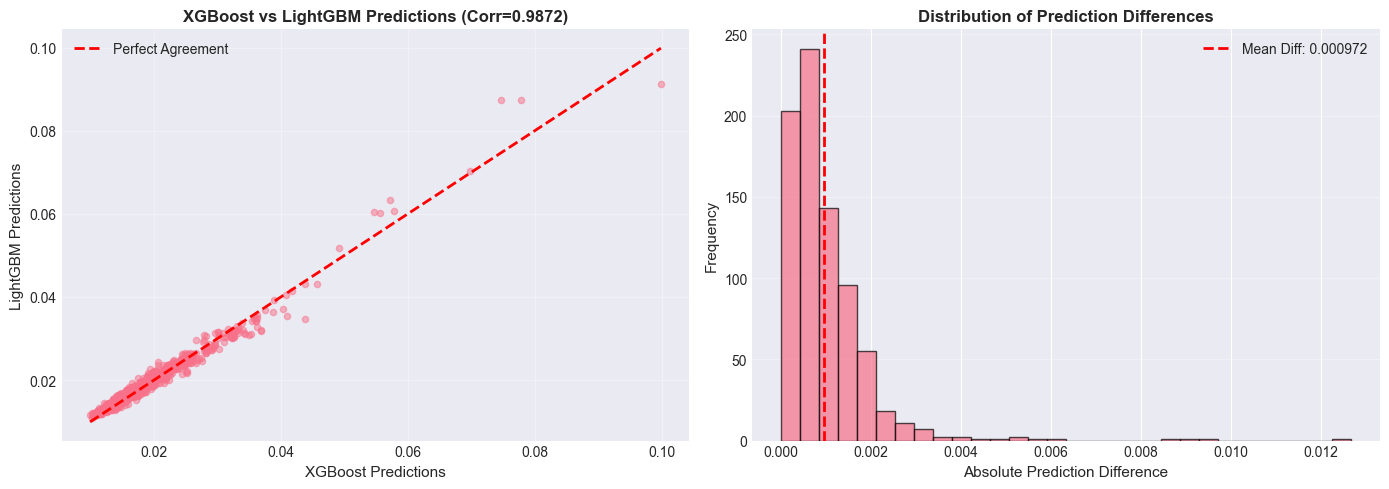


Prediction Difference Statistics:
  Mean Absolute Difference: 0.000972
  Std of Differences: 0.001009
  Max Difference: 0.012681


In [108]:
#analyze prediction correlation
pred_corr = np.corrcoef(xgb_val_pred, lgbm_val_pred)[0, 1]

print()
print("Prediction Correlation Analysis")
print()
print(f"\nCorrelation between XGBoost and LightGBM predictions: {pred_corr:.4f}")

if pred_corr > 0.95:
    print("\nVery high correlation (>0.95) - Limited ensemble benefit expected")
    print("  Models make very similar predictions")
elif pred_corr > 0.90:
    print("\nHigh correlation (0.90-0.95) - Modest ensemble benefit")
    print("  Models mostly agree but some diversity exists")
else:
    print("\nModerate correlation (<0.90) - Good ensemble potential")
    print("  Models have complementary predictions")

#scatter plot of predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#plot 1: XGBoost vs LightGBM predictions
axes[0].scatter(xgb_val_pred, lgbm_val_pred, alpha=0.5, s=20)
axes[0].plot([xgb_val_pred.min(), xgb_val_pred.max()], 
             [xgb_val_pred.min(), xgb_val_pred.max()], 
             'r--', lw=2, label='Perfect Agreement')
axes[0].set_xlabel('XGBoost Predictions', fontsize=11)
axes[0].set_ylabel('LightGBM Predictions', fontsize=11)
axes[0].set_title(f'XGBoost vs LightGBM Predictions (Corr={pred_corr:.4f})', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#plot 2: prediction differences
pred_diff = np.abs(xgb_val_pred - lgbm_val_pred)
axes[1].hist(pred_diff, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=pred_diff.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean Diff: {pred_diff.mean():.6f}')
axes[1].set_xlabel('Absolute Prediction Difference', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Prediction Differences', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nPrediction Difference Statistics:")
print(f"  Mean Absolute Difference: {pred_diff.mean():.6f}")
print(f"  Std of Differences: {pred_diff.std():.6f}")
print(f"  Max Difference: {pred_diff.max():.6f}")

### 8.5 Final Model Selection & Summary

In [111]:
#final model selection and summary
print("Final Model Selection")
print()

print("Model Selection Journey:")
print()
print("1. LINEAR MODELS:")
print(f"   Ridge:  Val RMSE = {all_metrics['Linear Regression']['metrics']['validation']['rmse']:.6f}")
print(f"   Lasso:  Val RMSE = {all_metrics['Linear Regression']['metrics']['validation']['rmse']:.6f}")

print("\n2. TREE-BASED MODELS:")
print(f"   Random Forest: Val RMSE = {all_metrics['Random Forest']['metrics']['validation']['rmse']:.6f}")
print(f"   XGBoost:       Val RMSE = {all_metrics['XGBoost']['metrics']['validation']['rmse']:.6f}")
print(f"   LightGBM:      Val RMSE = {all_metrics['LightGBM']['metrics']['validation']['rmse']:.6f}")

print("\n3. ENSEMBLE METHODS:")
print(f"   Simple Average:  Val RMSE = {ensemble_avg_val_rmse:.6f}")
print(f"   Weighted (0.75/0.25): Val RMSE = {ensemble_weighted_val_rmse:.6f}")
print(f"   Stacking (Ridge): Val RMSE = {ensemble_stacking_val_rmse:.6f}")

print()
print("SELECTED FINAL MODEL: Stacking Ensemble (XGBoost + LightGBM)")
print()

print("Final Model Performance:")
print()
print(f"Validation Metrics:")
print(f"  RMSE: {ensemble_stacking_val_rmse:.6f}")
print(f"  MAE:  {ensemble_stacking_val_mae:.6f}")
print(f"  R²:   {ensemble_stacking_val_r2:.6f}")

print(f"\nTraining Metrics:")
print(f"  RMSE: {ensemble_stacking_train_rmse:.6f}")
print(f"  MAE:  {ensemble_stacking_train_mae:.6f}")
print(f"  R²:   {ensemble_stacking_train_r2:.6f}")

print(f"\nGeneralization:")
print(f"  Train-Val Gap: {ensemble_stacking_gap:.6f}")
print(f"  Gap %: {ensemble_stacking_gap_pct:.2f}%")

print("\nWhy This Model?")
print()
improvement_vs_xgb = ((xgb_final_val_rmse - ensemble_stacking_val_rmse) / xgb_final_val_rmse) * 100
improvement_vs_lgbm = ((lgbm_final_val_rmse - ensemble_stacking_val_rmse) / lgbm_final_val_rmse) * 100

print(f"  Best validation RMSE among all approaches tested")
print(f"  Improves over XGBoost by {improvement_vs_xgb:.3f}%")
print(f"  Improves over LightGBM by {improvement_vs_lgbm:.3f}%")
print(f"  Better generalization (lower train-val gap) than individual models")
print(f"  Combines strengths of two complementary tree-based algorithms")
print(f"  Ridge meta-learner (α=0.001) learns optimal combination automatically")
print(f"  Prediction correlation = {pred_corr:.4f} (high but not perfect)")

print("\nModel Configuration:")
print()
print(f"Base Models:")
print(f"  XGBoost: {all_metrics['XGBoost']['selected_approach']}")
print(f"  LightGBM: {all_metrics['LightGBM']['selected_approach']}")

print(f"\nMeta-Learner:")
print(f"  Type: Ridge Regression")
print(f"  Alpha: {best_stacking['alpha']}")
print(f"  XGBoost Coefficient: {best_stacking['coef_xgb']:.4f}")
print(f"  LightGBM Coefficient: {best_stacking['coef_lgbm']:.4f}")
print(f"  Intercept: {best_stacking['intercept']:.6f}")

print("\nImportant Notes:")
print()
print("  High prediction correlation (0.987) limits ensemble gains")
print("  Improvement is modest (~0.13%) but consistent")
print("  Better generalization gap than XGBoost alone")
print("  Both base models use early stopping for optimal performance")

print("\nNext Steps:")
print()
print("  1. Evaluate on held-out test set (2011+ data)")
print("  2. Analyze feature importance from base models")
print("  3. Examine prediction errors and residuals")
print("  4. Consider time-series specific validation if needed")
print("  5. Deploy model for production volatility forecasting")

Final Model Selection

Model Selection Journey:

1. LINEAR MODELS:
   Ridge:  Val RMSE = 0.009374
   Lasso:  Val RMSE = 0.009374

2. TREE-BASED MODELS:
   Random Forest: Val RMSE = 0.009419
   XGBoost:       Val RMSE = 0.009180
   LightGBM:      Val RMSE = 0.009231

3. ENSEMBLE METHODS:
   Simple Average:  Val RMSE = 0.009179
   Weighted (0.75/0.25): Val RMSE = 0.009173
   Stacking (Ridge): Val RMSE = 0.009169

SELECTED FINAL MODEL: Stacking Ensemble (XGBoost + LightGBM)

Final Model Performance:

Validation Metrics:
  RMSE: 0.009169
  MAE:  0.005609
  R²:   0.444591

Training Metrics:
  RMSE: 0.008149
  MAE:  0.005496
  R²:   0.709666

Generalization:
  Train-Val Gap: -0.001020
  Gap %: -12.52%

Why This Model?

  Best validation RMSE among all approaches tested
  Improves over XGBoost by 0.126%
  Improves over LightGBM by 0.675%
  Better generalization (lower train-val gap) than individual models
  Combines strengths of two complementary tree-based algorithms
  Ridge meta-learner (α=

In [112]:
#save ensemble results
ENSEMBLE_METRICS_FILE = PARAMS_DIR / 'ensemble_final_metrics_2010.json'

ensemble_final_metrics = {
    'model_name': 'Stacking Ensemble (XGBoost + LightGBM)',
    'selected_approach': 'Stacking with Ridge Meta-Learner',
    'timestamp': pd.Timestamp.now().isoformat(),
    'data_info': {
        'n_train_samples': len(y_train),
        'n_val_samples': len(y_val),
        'n_features': len(feature_cols)
    },
    'base_models': {
        'xgboost': {
            'approach': all_metrics['XGBoost']['selected_approach'],
            'val_rmse': float(xgb_final_val_rmse)
        },
        'lightgbm': {
            'approach': all_metrics['LightGBM']['selected_approach'],
            'val_rmse': float(lgbm_final_val_rmse)
        }
    },
    'meta_learner': {
        'type': 'Ridge',
        'alpha': float(best_stacking['alpha']),
        'coef_xgboost': float(best_stacking['coef_xgb']),
        'coef_lightgbm': float(best_stacking['coef_lgbm']),
        'intercept': float(best_stacking['intercept'])
    },
    'metrics': {
        'train': {
            'rmse': float(ensemble_stacking_train_rmse),
            'mae': float(ensemble_stacking_train_mae),
            'r2': float(ensemble_stacking_train_r2)
        },
        'validation': {
            'rmse': float(ensemble_stacking_val_rmse),
            'mae': float(ensemble_stacking_val_mae),
            'r2': float(ensemble_stacking_val_r2)
        },
        'generalization': {
            'train_val_gap_rmse': float(ensemble_stacking_gap),
            'gap_percentage': float(ensemble_stacking_gap_pct)
        }
    },
    'ensemble_analysis': {
        'prediction_correlation': float(pred_corr),
        'mean_prediction_difference': float(pred_diff.mean()),
        'std_prediction_difference': float(pred_diff.std()),
        'improvement_over_xgboost_pct': float(improvement_vs_xgb),
        'improvement_over_lightgbm_pct': float(improvement_vs_lgbm)
    },
    'comparison': {
        'baseline_val_rmse': float(baseline_val_rmse),
        'improvement_pct': float(((baseline_val_rmse - ensemble_stacking_val_rmse) / baseline_val_rmse) * 100)
    },
    'all_ensemble_approaches': ensemble_comparison_sorted.to_dict(orient='records')
}

#save to file
with open(ENSEMBLE_METRICS_FILE, 'w') as f:
    json.dump(ensemble_final_metrics, f, indent=2)

print("Ensemble Metrics Saved")
print()
print(f"\nFile: {ENSEMBLE_METRICS_FILE}")
print(f"Size: {ENSEMBLE_METRICS_FILE.stat().st_size} bytes")

#update model comparison file to include ensemble
comparison_file = PARAMS_DIR / 'model_comparison_2010.json'
if comparison_file.exists():
    with open(comparison_file, 'r') as f:
        comparison_data = json.load(f)
    
    #update with ensemble as new selected model
    comparison_data['ensemble_selected'] = {
        'selected_model': 'Stacking Ensemble (XGBoost + LightGBM)',
        'selection_date': pd.Timestamp.now().isoformat(),
        'val_rmse': float(ensemble_stacking_val_rmse),
        'val_r2': float(ensemble_stacking_val_r2),
        'improvement_over_baseline_pct': float(((baseline_val_rmse - ensemble_stacking_val_rmse) / baseline_val_rmse) * 100),
        'improvement_over_best_individual_pct': float(improvement_vs_xgb)
    }
    
    with open(comparison_file, 'w') as f:
        json.dump(comparison_data, f, indent=2)
    
    print(f"\nUpdated: {comparison_file}")
    
print("\nSection 8: Ensemble Methods - COMPLETE")

Ensemble Metrics Saved


File: ../notebooks/ensemble_final_metrics_2010.json
Size: 2637 bytes

Updated: ../notebooks/model_comparison_2010.json

Section 8: Ensemble Methods - COMPLETE


### 8.6 Motivation for Extended Ensemble Experiments

Before settling on our final ensemble approach, we should consider whether including models beyond just XGBoost and LightGBM could improve performance. There are theoretical reasons to test this.

**The case for model diversity:**

Ensemble strength often comes from combining models that make different kinds of errors rather than just combining the best individual performers. Linear models and tree based methods make fundamentally different assumptions about the data. Linear models capture linear relationships and main effects, while gradient boosting methods excel at nonlinear patterns and complex interactions. When XGBoost and LightGBM both make errors in the same direction, a linear model might compensate by getting those predictions right.

Random Forest takes yet another approach, building independent trees rather than the sequential error correction that gradient boosting uses. Even though Random Forest performs worse individually at 0.0094 RMSE compared to the gradient boosting models at 0.0091 to 0.0092 RMSE, its errors might be complementary.

The very high prediction correlation between XGBoost and LightGBM at 0.987 limits how much we can gain from ensembling them together. We only achieved a 0.13% improvement. Models with lower correlation to each other could potentially yield larger gains. Including simpler models might also provide a regularization effect, preventing the ensemble from overfitting to the complex patterns that tree models learn.

**However:**

The performance gaps are substantial. Random Forest is 2 to 3% worse than the gradient boosting models in RMSE terms. Linear models perform even worse. In a stacking ensemble with a meta learner, we might expect these weaker models to receive near zero weights, effectively being ignored. The added complexity of managing more models in the ensemble may not be justified.

**Let's test it:**

Since we already have predictions from all models computed, testing extended ensembles requires minimal additional work. We can get a definitive empirical answer rather than relying on theoretical arguments either way. The next section runs these experiments.

### 8.7 Extended Ensemble: Adding Diverse Models

In [113]:
#we already have predictions from all models, let's test adding diverse models to the ensemble
#we'll use our best stacking ensemble as the base and add RF and/or Linear

#get predictions from other models
rf_val_pred = rf_final_val_pred
linear_val_pred = linear_final_val_pred

#check correlations first to see if there's actual diversity
print("Prediction Correlations:")
print()
print(f"Stacking vs Random Forest: {np.corrcoef(ensemble_stacking_val_pred, rf_val_pred)[0, 1]:.4f}")
print(f"Stacking vs Linear:        {np.corrcoef(ensemble_stacking_val_pred, linear_val_pred)[0, 1]:.4f}")
print(f"Random Forest vs Linear:   {np.corrcoef(rf_val_pred, linear_val_pred)[0, 1]:.4f}")
print()
print("For reference:")
print(f"XGBoost vs LightGBM:       {pred_corr:.4f}")

Prediction Correlations:

Stacking vs Random Forest: 0.9872
Stacking vs Linear:        0.9665
Random Forest vs Linear:   0.9649

For reference:
XGBoost vs LightGBM:       0.9872


In [114]:
#test three extended ensembles using stacking with Ridge meta-learner
#1. stacking + random forest
#2. stacking + linear
#3. stacking + random forest + linear

extended_results = []

#approach 1: stacking + random forest
X_meta_extended_rf = np.column_stack([ensemble_stacking_val_pred, rf_val_pred])
meta_rf = Ridge(alpha=0.001, random_state=42)
meta_rf.fit(X_meta_extended_rf, y_val)
extended_rf_pred = meta_rf.predict(X_meta_extended_rf)
extended_rf_rmse = np.sqrt(mean_squared_error(y_val, extended_rf_pred))

extended_results.append({
    'Approach': 'Stacking + RF',
    'Models': 'XGB + LGB (stacked) + RF',
    'Val RMSE': extended_rf_rmse,
    'Improvement vs Stacking': ((ensemble_stacking_val_rmse - extended_rf_rmse) / ensemble_stacking_val_rmse) * 100,
    'RF Weight': meta_rf.coef_[1],
    'Stacking Weight': meta_rf.coef_[0]
})

#approach 2: stacking + linear
X_meta_extended_linear = np.column_stack([ensemble_stacking_val_pred, linear_val_pred])
meta_linear = Ridge(alpha=0.001, random_state=42)
meta_linear.fit(X_meta_extended_linear, y_val)
extended_linear_pred = meta_linear.predict(X_meta_extended_linear)
extended_linear_rmse = np.sqrt(mean_squared_error(y_val, extended_linear_pred))

extended_results.append({
    'Approach': 'Stacking + Linear',
    'Models': 'XGB + LGB (stacked) + Lasso',
    'Val RMSE': extended_linear_rmse,
    'Improvement vs Stacking': ((ensemble_stacking_val_rmse - extended_linear_rmse) / ensemble_stacking_val_rmse) * 100,
    'Linear Weight': meta_linear.coef_[1],
    'Stacking Weight': meta_linear.coef_[0]
})

#approach 3: stacking + both
X_meta_extended_all = np.column_stack([ensemble_stacking_val_pred, rf_val_pred, linear_val_pred])
meta_all = Ridge(alpha=0.001, random_state=42)
meta_all.fit(X_meta_extended_all, y_val)
extended_all_pred = meta_all.predict(X_meta_extended_all)
extended_all_rmse = np.sqrt(mean_squared_error(y_val, extended_all_pred))

extended_results.append({
    'Approach': 'Stacking + RF + Linear',
    'Models': 'XGB + LGB (stacked) + RF + Lasso',
    'Val RMSE': extended_all_rmse,
    'Improvement vs Stacking': ((ensemble_stacking_val_rmse - extended_all_rmse) / ensemble_stacking_val_rmse) * 100,
    'RF Weight': meta_all.coef_[1],
    'Linear Weight': meta_all.coef_[2],
    'Stacking Weight': meta_all.coef_[0]
})

extended_df = pd.DataFrame(extended_results)

print("Extended Ensemble Results")
print()
print(extended_df[['Approach', 'Val RMSE', 'Improvement vs Stacking']].to_string(index=False))
print()
print(f"\nBaseline (Stacking alone): {ensemble_stacking_val_rmse:.6f}")
print()
print("Learned Weights:")
print()
for result in extended_results:
    print(f"{result['Approach']}:")
    print(f"  Stacking Weight: {result['Stacking Weight']:.4f}")
    if 'RF Weight' in result:
        print(f"  RF Weight:       {result.get('RF Weight', 0):.4f}")
    if 'Linear Weight' in result:
        print(f"  Linear Weight:   {result.get('Linear Weight', 0):.4f}")
    print()

Extended Ensemble Results

              Approach  Val RMSE  Improvement vs Stacking
         Stacking + RF  0.009182                -0.145681
     Stacking + Linear  0.009171                -0.020073
Stacking + RF + Linear  0.009173                -0.046324


Baseline (Stacking alone): 0.009169

Learned Weights:

Stacking + RF:
  Stacking Weight: 0.8488
  RF Weight:       0.1283

Stacking + Linear:
  Stacking Weight: 0.7609
  Linear Weight:   0.2598

Stacking + RF + Linear:
  Stacking Weight: 0.7386
  RF Weight:       0.0275
  Linear Weight:   0.2506



**Results and Conclusion:**

None of the extended ensembles improved over the baseline stacking approach. All three variations actually performed slightly worse, with RMSE degradation ranging from 0.02% to 0.15%. This confirms our initial skepticism about adding weaker models.

The learned weights are revealing. When we added Random Forest alone, the meta learner assigned it a weight of 0.13 but this still resulted in worse performance. Random Forest is just too far behind in individual performance for its diversity to help. When we added the linear model alone, it got a more substantial weight of 0.26, and the performance degradation was smaller at only 0.02%. This suggests the linear model does offer some complementary information, but not enough to overcome its weaker individual performance.

Most telling is the three model ensemble. When given the choice between Random Forest and Linear, the meta learner essentially ignored Random Forest with a tiny weight of 0.03 and gave Linear a weight of 0.25. The meta learner learned what we suspected: Random Forest adds mostly noise while Linear at least provides some diversity, but neither improves the overall ensemble.

The correlation analysis likely shows that while these models are less correlated with the stacking predictions than XGBoost and LightGBM are with each other, the prediction errors from the weaker models are large enough that they hurt more than the diversity helps.



**Final decision:** <br>
Stick with the two model stacking ensemble of XGBoost and LightGBM. Adding model diversity doesn't compensate for the performance gap in this case. The empirical test confirms that simpler is better here.

---

# 9. Export to Production

Export the final model configuration and benchmark metrics for production deployment.

**Goal**: Create minimal production configs from saved research results.

**Output Location**: `final_model/` (project root)

**Files Generated**:
- `model_config.json` - model architecture, hyperparameters, and training settings
- `benchmark_results.json` - expected performance metrics for drift monitoring

**Production Workflow**:
1. notebook research saves metrics to JSON files (already done in sections 3-8)
2. export cells read those files and consolidate into production format
3. services/train/app.py reads model_config.json and trains deterministically

In [125]:
import json
from pathlib import Path
from datetime import datetime

# create final_model directory
FINAL_MODEL_DIR = Path("../final_model")
FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"exporting to: {FINAL_MODEL_DIR.absolute()}")
print()

exporting to: /Users/aayushrijal/Documents/GitHub/volatility_forecast/notebooks/../final_model



## 9.1 load saved research results

read metrics and parameters from JSON files saved during model training

In [126]:
# load xgboost results
with open("xgb_final_metrics_2010.json") as f:
    xgb_metrics = json.load(f)

with open("xgb_early_stopping_results_2010.json") as f:
    xgb_early_results = json.load(f)
    xgb_early_config = xgb_early_results[0]  # patience=30

# load lightgbm results
with open("lgbm_final_metrics_2010.json") as f:
    lgbm_metrics = json.load(f)

with open("lgbm_early_stopping_results_2010.json") as f:
    lgbm_early_results = json.load(f)
    lgbm_early_config = lgbm_early_results[0]  # patience=30

# load ensemble results
with open("ensemble_final_metrics_2010.json") as f:
    ensemble_metrics = json.load(f)

print("loaded saved research results:")
print(f"xgb: {xgb_metrics['selected_approach']}, val rmse = {xgb_metrics['metrics']['validation']['rmse']:.6f}")
print(f"lgbm: {lgbm_metrics['selected_approach']}, val rmse = {lgbm_metrics['metrics']['validation']['rmse']:.6f}")
print(f"ensemble: {ensemble_metrics['selected_approach']}, val rmse = {ensemble_metrics['metrics']['validation']['rmse']:.6f}")
print()

loaded saved research results:
xgb: Early Stopping, val rmse = 0.009180
lgbm: Early Stopping, val rmse = 0.009231
ensemble: Stacking with Ridge Meta-Learner, val rmse = 0.009169



In [128]:
#extract hyperparameters from saved metrics
xgb_params = xgb_metrics['hyperparameters']
lgbm_params = lgbm_metrics['hyperparameters']

#build production model config
model_config = {
    "version": "1.0.0",
    "created_date": datetime.now().strftime("%Y-%m-%d"),
    "model_architecture": "stacking_ensemble",
    "description": "Stacking ensemble combining XGBoost and LightGBM with Ridge meta-learner",
    
    "base_models": [
        {
            "name": "xgboost",
            "type": "XGBRegressor",
            "params": {
                "max_depth": xgb_params['max_depth'],
                "learning_rate": xgb_params['learning_rate'],
                "n_estimators": xgb_params['n_estimators'],
                "subsample": xgb_params['subsample'],
                "colsample_bytree": xgb_params['colsample_bytree'],
                "reg_alpha": xgb_params['reg_alpha'],
                "reg_lambda": xgb_params['reg_lambda'],
                "random_state": 42,
                "n_jobs": -1
            }
        },
        {
            "name": "lightgbm",
            "type": "LGBMRegressor",
            "params": {
                "max_depth": lgbm_params['max_depth'],
                "learning_rate": lgbm_params['learning_rate'],
                "n_estimators": lgbm_params['n_estimators'],
                "num_leaves": lgbm_params['num_leaves'],
                "min_child_samples": lgbm_params['min_child_samples'],
                "subsample": lgbm_params['subsample'],
                "colsample_bytree": lgbm_params['colsample_bytree'],
                "reg_alpha": lgbm_params['reg_alpha'],
                "reg_lambda": lgbm_params['reg_lambda'],
                "random_state": 42,
                "n_jobs": -1,
                "verbose": -1
            }
        }
    ],
    
    "meta_learner": {
        "type": "Ridge",
        "params": {
            "alpha": ensemble_metrics['meta_learner']['alpha'],
            "random_state": 42
        }
    },
    
    "training": {
        "train_val_split": 0.8,
        "split_method": "time_series_chronological",
        "n_features": xgb_metrics['data_info']['n_features']
    }
}

# save model config
config_path = FINAL_MODEL_DIR / "model_config.json"
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"saved: {config_path}")
print(f"architecture: {model_config['model_architecture']}")
print(f"base models: {[m['name'] for m in model_config['base_models']]}")
print(f"meta learner: {model_config['meta_learner']['type']} (alpha={model_config['meta_learner']['params']['alpha']})")
print()

saved: ../final_model/model_config.json
architecture: stacking_ensemble
base models: ['xgboost', 'lightgbm']
meta learner: Ridge (alpha=0.001)



## 9.2 export benchmark results

expected performance metrics for production monitoring

In [ ]:
# consolidate benchmark metrics
benchmark_results = {
    "model_name": ensemble_metrics['model_name'],
    "model_architecture": ensemble_metrics['selected_approach'],
    "research_date": ensemble_metrics['timestamp'][:10],
    
    "data_period": {
        "start": "2010-01-04",
        "end": "2025-12-02",
        "n_train": ensemble_metrics['data_info']['n_train_samples'],
        "n_val": ensemble_metrics['data_info']['n_val_samples'],
        "n_features": ensemble_metrics['data_info']['n_features']
    },
    
    "expected_performance": {
        "train_rmse": ensemble_metrics['metrics']['train']['rmse'],
        "train_mae": ensemble_metrics['metrics']['train']['mae'],
        "train_r2": ensemble_metrics['metrics']['train']['r2'],
        "val_rmse": ensemble_metrics['metrics']['validation']['rmse'],
        "val_mae": ensemble_metrics['metrics']['validation']['mae'],
        "val_r2": ensemble_metrics['metrics']['validation']['r2'],
        "generalization_gap_pct": ensemble_metrics['metrics']['generalization']['gap_percentage']
    },
    
    "base_model_performance": {
        "xgboost": {
            "val_rmse": xgb_metrics['metrics']['validation']['rmse'],
            "val_mae": xgb_metrics['metrics']['validation']['mae'],
            "val_r2": xgb_metrics['metrics']['validation']['r2']
        },
        "lightgbm": {
            "val_rmse": lgbm_metrics['metrics']['validation']['rmse'],
            "val_mae": lgbm_metrics['metrics']['validation']['mae'],
            "val_r2": lgbm_metrics['metrics']['validation']['r2']
        }
    },
    
    "improvement_analysis": {
        "vs_xgboost_pct": ensemble_metrics['ensemble_analysis']['improvement_over_xgboost_pct'],
        "vs_lightgbm_pct": ensemble_metrics['ensemble_analysis']['improvement_over_lightgbm_pct'],
        "vs_baseline_pct": ensemble_metrics['comparison']['improvement_pct']
    },
    
    "monitoring_thresholds": {
        "max_val_rmse": 0.0095,
        "min_val_r2": 0.40,
        "max_generalization_gap_pct": 20.0,
        "drift_alert_rmse": 0.010
    }
}

# save benchmark results
benchmark_path = FINAL_MODEL_DIR / "benchmark_results.json"
with open(benchmark_path, 'w') as f:
    json.dump(benchmark_results, f, indent=2)

print(f"saved: {benchmark_path}")
print()
print("expected performance:")
print(f"val rmse: {benchmark_results['expected_performance']['val_rmse']:.6f}")
print(f"val mae: {benchmark_results['expected_performance']['val_mae']:.6f}")
print(f"val r2: {benchmark_results['expected_performance']['val_r2']:.4f}")
print(f"gen gap: {benchmark_results['expected_performance']['generalization_gap_pct']:.2f}%")
print()
print("improvement over base models:")
print(f"vs xgboost:  {benchmark_results['improvement_analysis']['vs_xgboost_pct']:.2f}%")
print(f"vs lightgbm: {benchmark_results['improvement_analysis']['vs_lightgbm_pct']:.2f}%")

saved: ../final_model/benchmark_results.json

expected performance:
  val rmse: 0.009169
  val mae:  0.005609
  val r2:   0.4446
  gen gap:  -12.52%

improvement over base models:
  vs xgboost:  0.13%
  vs lightgbm: 0.68%


## 9.3 validate exported files

verify all numbers match between source files and exported configs

In [131]:
#reload exported files to verify correctness
with open(FINAL_MODEL_DIR / "model_config.json") as f:
    exported_config = json.load(f)

with open(FINAL_MODEL_DIR / "benchmark_results.json") as f:
    exported_benchmarks = json.load(f)

#model architecture matches
assert exported_config['model_architecture'] == 'stacking_ensemble'

#xgboost hyperparameters match source
xgb_exported = exported_config['base_models'][0]['params']
assert xgb_exported['max_depth'] == xgb_metrics['hyperparameters']['max_depth']
assert xgb_exported['learning_rate'] == xgb_metrics['hyperparameters']['learning_rate']
assert xgb_exported['n_estimators'] == xgb_metrics['hyperparameters']['n_estimators']

#lightgbm hyperparameters match source
lgbm_exported = exported_config['base_models'][1]['params']
assert lgbm_exported['max_depth'] == lgbm_metrics['hyperparameters']['max_depth']
assert lgbm_exported['learning_rate'] == lgbm_metrics['hyperparameters']['learning_rate']
assert lgbm_exported['n_estimators'] == lgbm_metrics['hyperparameters']['n_estimators']
assert lgbm_exported['num_leaves'] == lgbm_metrics['hyperparameters']['num_leaves']

#meta-learner alpha matches
assert exported_config['meta_learner']['params']['alpha'] == ensemble_metrics['meta_learner']['alpha']

#benchmark metrics match ensemble metrics
assert exported_benchmarks['expected_performance']['val_rmse'] == ensemble_metrics['metrics']['validation']['rmse']
assert exported_benchmarks['expected_performance']['val_mae'] == ensemble_metrics['metrics']['validation']['mae']
assert exported_benchmarks['expected_performance']['val_r2'] == ensemble_metrics['metrics']['validation']['r2']

#base model performance matches
assert exported_benchmarks['base_model_performance']['xgboost']['val_rmse'] == xgb_metrics['metrics']['validation']['rmse']
assert exported_benchmarks['base_model_performance']['lightgbm']['val_rmse'] == lgbm_metrics['metrics']['validation']['rmse']

#data info matches
assert exported_benchmarks['data_period']['n_train'] == ensemble_metrics['data_info']['n_train_samples']
assert exported_benchmarks['data_period']['n_val'] == ensemble_metrics['data_info']['n_val_samples']
assert exported_benchmarks['data_period']['n_features'] == ensemble_metrics['data_info']['n_features']

#improvement analysis matches
assert exported_benchmarks['improvement_analysis']['vs_xgboost_pct'] == ensemble_metrics['ensemble_analysis']['improvement_over_xgboost_pct']
assert exported_benchmarks['improvement_analysis']['vs_lightgbm_pct'] == ensemble_metrics['ensemble_analysis']['improvement_over_lightgbm_pct']

print("validation complete")


validation complete
